## Setup

In [338]:
# Importing required libraries
import xgboost as xgb
from sklearn import tree, neighbors, datasets, linear_model, svm, naive_bayes, ensemble
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import cross_validate,GridSearchCV, RandomizedSearchCV, KFold
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction import DictVectorizer
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt
import scikitplot as skplt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestRegressor

## Define Necessary Functions

In [339]:
def model_fit(alg,x_train,x_test,y_train,y_test):
    #fit model
    print(y_train)
    alg.fit(x_train,y_train)
    
    #predict using model
    y_train_predict=alg.predict(x_train)
    y_test_predict=alg.predict(x_test)

    train_rsq = round(metrics.r2_score(y_train,y_train_predict),2)
    #print report
    print("Training R-squared: ",train_rsq)
    print("Training Explained Variation: ",round(metrics.explained_variance_score(y_train,y_train_predict),2))
    print("Training RMSE: ",round(np.sqrt(metrics.mean_squared_error(y_train,y_train_predict)),2))
    print("Training MAE: ",round(metrics.mean_absolute_error(y_train,y_train_predict),2)," \n")
    
    test_rsq = round(metrics.r2_score(y_test,y_test_predict),2)
    test_rmse = round(np.sqrt(metrics.mean_squared_error(y_test,y_test_predict)),2)
    test_mae = round(metrics.mean_absolute_error(y_test,y_test_predict),2)
    # Calculate accuracy score on predicted values
    print("Test R-squared: ",test_rsq)
    print("Test Explained Variation: ",round(metrics.explained_variance_score(y_test,y_test_predict),2))
    print("Test RMSE: ",test_rmse)
    print("Test MAE: ",test_mae)
    
    feat_imp = pd.Series(alg.best_estimator_.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    plt.figure(figsize=(20,20))
    plt.show()
    
    return y_train_predict, y_test_predict, feat_imp, test_rsq, test_rmse, train_rsq, test_mae

In [357]:
def prepare_data(filename = "Final_Data/Soybean_Futures_May_2020.csv", export_diff = True):
    #reading files
    close_merge =pd.read_csv(filename)
    trump=pd.read_csv("Final_Data/Trump.txt",sep="\t",parse_dates=[0])
    tweet=pd.read_csv("Final_Data/Others.txt",sep="\t",index_col='Date', parse_dates=True)
    #agweb=pd.read_csv("Final_Data/AgWeb.csv",index_col='Date', parse_dates=True)
    #crude_forex=pd.read_csv("Final_Data/crude_forex.csv",index_col='Date', parse_dates=True)
    us_index=pd.read_csv("Final_Data/us_index_final.csv",index_col='Date', parse_dates=True)
    us_index = us_index.drop(columns=['Open', 'High', 'Low', 'Change', 'Volume'])
    us_index.columns = ['US_INDEX_CLOSE']
    export_diff = pd.read_csv('Final_Data/export_diff_us_comp.csv',index_col='Date', parse_dates=True)
    sp_index = pd.read_csv('Final_Data/SP500Commodities.csv',index_col='Date', parse_dates=True)
    export_diff = export_diff.resample('D').ffill()
    
    
    
    #google = pd.read_csv('Final_Data/google.csv',index_col='Date', parse_dates=True)
    #google = google.resample('D').ffill()

    #adding date index
    trump.index=trump.Date
    close_merge.index= close_merge.Date
    
    #merging data
    data = pd.merge(close_merge,
                     tweet,
                     how='left',
                     left_index=True,
                    right_index=True)
    print("post tweet\n",data.tail())
    
    data = pd.merge(data,
                     export_diff,
                     how='left',
                     left_index=True,
                    right_index=True)
    print("post exp diff\n",data.tail())

    data = pd.merge(data,
                 trump,
                 how='left',
                 left_index=True,
                right_index=True)
    print("post trump\n",data.tail())

    data = pd.merge(data,
                 sp_index,
                 how='left',
                 left_index=True,
                right_index=True)
    print("post sp index\n",data.tail())

    # adding crude forex
    #data = pd.merge(data,
    #             crude_forex,
    #             how='left',
    #             left_index=True,
    #            right_index=True)
   
    data = pd.merge(data,
                 us_index,
                 how='left',
                 left_index=True,
                right_index=True)
    print("post us index\n",data.tail())

    #data = pd.merge(data,
    #             agweb,
    #             how='left',
    #             left_index=True,
    #            right_index=True)

#data = pd.merge(data,
#             google,
#             how='left',
#             left_index=True,
#            right_index=True)

    drop_cols = [c for c in data.columns if c.startswith('Date')]

    data=data.drop(columns=drop_cols)
    
    data['diff']=data['Last']-data['Open']
    data['max-min'] = data['High']-data['Low']
    data = data.drop(columns=['High', 'Low', 'Change', 'Volume', 'Open Int'])
    return data

In [359]:
def add_lags(data, lag_prices = 10, lag_trump = 5, lag_tweets = 5, lag_google = 10):
    
    #adding lags to tweets and prices
    lags = range(1, lag_prices)
    lag_col= ['Last','diff']
    data=data.assign(**{
        '{} (t-{})'.format(col, t): data[col].shift(t)
        for t in lags
        for col in lag_col
    })
    
    data = data.drop(columns=['Last','diff'])
    
    #adding lags to google search trends
    #lags = range(5, lag_google)
    #lag_col= ['soybean_news_search','soybean_finance_web_search']
    #data=data.assign(**{
    #    '{} (t-{})'.format(col, t): data[col].shift(t)
    #    for t in lags
    #    for col in lag_col
    #})
    #
    #data = data.drop(columns=lag_col)
    
    lags = range(5, lag_prices)
    lag_col= ['S&P DCFI Index', 'max-min',
              #'CNY USD XR','BRL USD XR','ARS USD XR',
              #'Brent Crude','WTI Crude','OPEC Crude Oil Price',
             'US_INDEX_CLOSE']

    data=data.assign(**{
        '{} (t-{})'.format(col, t): data[col].shift(t)
        for t in lags
        for col in lag_col
    })
    
    data = data.drop(columns=lag_col)
    
    lags = range(1, lag_tweets)
    lag_col= ['Other_Positive','Other_Negative','Other_Neutral']
    data=data.assign(**{
        '{} (t-{})'.format(col, t): data[col].shift(t)
        for t in lags
        for col in lag_col
    })
    
    lags = range(1, lag_trump)
    lag_col= ['Trump_Positive','Trump_Negative','Trump_Neutral']
    data=data.assign(**{
        '{} (t-{})'.format(col, t): data[col].shift(t)
        for t in lags
        for col in lag_col
    })
    
    rows_removed_lag = max(lag_tweets,lag_prices,lag_trump) + 1
    data=data.iloc[rows_removed_lag:,]
    return data

In [360]:
def predict_soybean_futures(data, forex = False, printlogs = True, predict = 'Open',
                           exportdiff = True):
    
    rows,cols = data.shape
    #train test splits
    split = int(0.8*rows)

    train=data.iloc[:split,]
    test=data.iloc[split:,]

    train_y=train[[predict]]
    train_x=train.loc[:,train.columns != predict]
    print('columns being used:')
    print(train_x.columns)
    print()
    test_y=test[[predict]]
    test_x=test.loc[:,test.columns != predict]
    # xg boost parameter tuning
    param_test = {
    'learning_rate':[0.1,0.05,0.01],
    'n_estimators':range(5,200,10),
    'max_depth':range(3,20),
    'min_child_weight':range(1,6),
    'gamma':[i/10.0 for i in range(0,5)],
    'subsample':[i/10.0 for i in range(6,10)],
    'colsample_bytree':[i/10.0 for i in range(6,10)],
    'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
    }
#xg_random=xgb.XGBRegressor(learning_rate=0.35,reg_lambda=1,
#                                            n_estimators=100,
#                                            max_depth=24,
#                                            min_child_weight=1,
#                                            gamma=0,
#                                            subsample=0.9,
#                                            colsample_bytree=0.8,
#                                            njobs=-1,
#                                            scale_pos_weight=1,
#                                            seed=123)
    gbm = xgb.XGBRegressor(njobs=-1,
                         scale_pos_weight=1,
                         seed=123)
    
    xg_random = RandomizedSearchCV(estimator=gbm, param_distributions=param_test,
                                    n_iter=100, scoring='neg_median_absolute_error', 
                                   cv=KFold(n_splits=3, shuffle=True, random_state=45),
                                   verbose=1, n_jobs=-1, random_state=45)

    train_predict, test_predict, feat_imp, test_rsq, test_rmse, \
                        train_rsq, test_mae = model_fit(xg_random,train_x,test_x,train_y,test_y)
    print()
    print('best params \n',xg_random.best_params_)
    print()
    test_result=test_y
    test_result['predict']=test_predict
    test_result['diff']=test_result[predict]-test_result['predict']
    test_result.describe()
    
    plt.plot(train[predict])
    plt.plot(test_result[[predict, 'predict']])
    plt.show()

    return test_rsq, test_rmse, test_mae, train_rsq, xg_random, test_x.tail(20), feat_imp,test_result

# Execution

In [268]:
data = prepare_data("Final_Data/Soybean_Futures_May_2020.csv")
print(data.columns)
data.tail(10)

post tweet
                   Date    Open    High     Low    Last  Change  Volume  \
Date                                                                     
2019-10-28  10/28/2019  957.75  963.00  957.75  958.75    1.25   11931   
2019-10-29  10/29/2019  958.75  963.25  954.75  957.75   -1.00   18413   
2019-10-30  10/30/2019  957.00  961.00  954.50  955.00   -2.75   18456   
2019-10-31  10/31/2019  954.75  959.25  950.25  957.00    2.00   16525   
2019-11-01   11/1/2019  955.50  962.00  952.50  960.75    3.75    9603   

            Open Int  Other_Positive  Other_Negative  Other_Neutral  
Date                                                                 
2019-10-28     72058           0.489           0.039          2.472  
2019-10-29     71699           1.256           0.206          8.538  
2019-10-30     73891           0.595           0.069          3.336  
2019-10-31     76076           0.994           0.074         11.931  
2019-11-01         0             NaN             

Last  Other_Positive  Other_Negative  Other_Neutral  \
Date                                                                
2019-10-21  967.50             NaN             NaN            NaN   
2019-10-22  968.50           0.000           0.000          1.000   
2019-10-23  968.00           0.000           0.000          1.000   
2019-10-24  968.25             NaN             NaN            NaN   
2019-10-25  957.50             NaN             NaN            NaN   
2019-10-28  958.75           0.489           0.039          2.472   
2019-10-29  957.75           1.256           0.206          8.538   
2019-10-30  955.00           0.595           0.069          3.336   
2019-10-31  957.00           0.994           0.074         11.931   
2019-11-01  960.75             NaN             NaN            NaN   

            Agricultural Exports  Beef & Beef Products     Bulk  \
Date                                                              
2019-10-21              -12.0892              -11.6055 -18.0102   
2019-10-22              -12.0892              -11.6055 -18.0102   
2019-10-23              -12.0892              -11.6055 -18.0102   
2019-10-24              -12.0892              -11.6055 -18.0102   
2019-10-25              -12.0892              -11.6055 -18.0102   
2019-10-28              -12.0892              -11.6055 -18.0102   
2019-10-29              -12.0892              -11.6055 -18.0102   
2019-10-30              -12.0892              -11.6055 -18.0102   
2019-10-31              -12.0892              -11.6055 -18.0102   
2019-11-01              -12.2800              -11.5268 -18.1140   

            Consumer Oriented     Corn  Cotton  ...  Tree Nuts    Wheat  \
Date                                            ...                       
2019-10-21            -5.6166 -15.6872 -9.7190  ...    -5.2488 -11.1210   
2019-10-22            -5.6166 -15.6872 -9.7190  ...    -5.2488 -11.1210   
2019-10-23            -5.6166 -15.6872 -9.7190  ...    -5.2488 -11.1210   
2019-10-24            -5.6166 -15.6872 -9.7190  ...    -5.2488 -11.1210   
2019-10-25            -5.6166 -15.6872 -9.7190  ...    -5.2488 -11.1210   
2019-10-28            -5.6166 -15.6872 -9.7190  ...    -5.2488 -11.1210   
2019-10-29            -5.6166 -15.6872 -9.7190  ...    -5.2488 -11.1210   
2019-10-30            -5.6166 -15.6872 -9.7190  ...    -5.2488 -11.1210   
2019-10-31            -5.6166 -15.6872 -9.7190  ...    -5.2488 -11.1210   
2019-11-01            -5.4908 -15.9724 -9.6885  ...    -5.0531 -10.7255   

            Wine & Beer  Trump_Positive  Trump_Negative  Trump_Neutral  \
Date                                                                     
2019-10-21      -5.7693             NaN             NaN            NaN   
2019-10-22      -5.7693             NaN             NaN            NaN   
2019-10-23      -5.7693             NaN             NaN            NaN   
2019-10-24      -5.7693             NaN             NaN            NaN   
2019-10-25      -5.7693             NaN             NaN            NaN   
2019-10-28      -5.7693             NaN             NaN            NaN   
2019-10-29      -5.7693             NaN             NaN            NaN   
2019-10-30      -5.7693             NaN             NaN            NaN   
2019-10-31      -5.7693             NaN             NaN            NaN   
2019-11-01      -5.5764             NaN             NaN            NaN   

            S&P DCFI Index  US_INDEX_CLOSE   diff  max-min  
Date                                                        
2019-10-21          121.92           97.30   3.00    11.00  
2019-10-22          121.85           97.50   2.00    12.25  
2019-10-23          120.87           97.45   0.00     9.25  
2019-10-24          121.09           97.68   0.25     5.50  
2019-10-25          120.70           97.82 -10.50    16.25  
2019-10-28          120.82           97.75   1.00     5.25  
2019-10-29          120.88           97.68  -1.00     8.50  
2019-10-30          120.69           97.4

In [269]:
lagged_data = add_lags(data, lag_prices = 11, lag_trump = 9, lag_tweets = 2)
print(lagged_data.columns)
lagged_data.head(5)

Index(['Last', 'Other_Positive', 'Other_Negative', 'Other_Neutral',
       'Agricultural Exports', 'Beef & Beef Products', 'Bulk',
       'Consumer Oriented', 'Corn', 'Cotton', 'Dairy Products',
       'Feeds & Fodders', 'Fresh & Processed Fruit',
       'Fresh & Processed Vegetables', 'Hides & Skins', 'Intermediates',
       'Juices & Beverages', 'Merchandise Exports', 'Pork & Pork Products',
       'Poultry Meat & Products', 'Prepared Food', 'Rice',
       'Soybean & Vegetable Oil', 'Soybeans', 'Soymeal', 'Tobacco',
       'Tree Nuts', 'Wheat', 'Wine & Beer', 'Trump_Positive', 'Trump_Negative',
       'Trump_Neutral', 'Last (t-1)', 'diff (t-1)', 'Last (t-2)', 'diff (t-2)',
       'Last (t-3)', 'diff (t-3)', 'Last (t-4)', 'diff (t-4)', 'Last (t-5)',
       'diff (t-5)', 'Last (t-6)', 'diff (t-6)', 'Last (t-7)', 'diff (t-7)',
       'Last (t-8)', 'diff (t-8)', 'Last (t-9)', 'diff (t-9)', 'Last (t-10)',
       'diff (t-10)', 'S&P DCFI Index (t-5)', 'max-min (t-5)',
       'US_INDEX_CLOS

Last  Other_Positive  Other_Negative  Other_Neutral  \
Date                                                                 
2017-12-04  1012.75             NaN             NaN            NaN   
2017-12-05  1018.00             NaN             NaN            NaN   
2017-12-06  1014.25             NaN             NaN            NaN   
2017-12-07  1005.25             NaN             NaN            NaN   
2017-12-08  1004.00             NaN             NaN            NaN   

            Agricultural Exports  Beef & Beef Products    Bulk  \
Date                                                             
2017-12-04               -2.2717                2.1845 -6.3935   
2017-12-05               -2.2717                2.1845 -6.3935   
2017-12-06               -2.2717                2.1845 -6.3935   
2017-12-07               -2.2717                2.1845 -6.3935   
2017-12-08               -2.2717                2.1845 -6.3935   

            Consumer Oriented    Corn  Cotton  ...  Trump_Neutral (t-5)  \
Date                                           ...                        
2017-12-04             1.9111 -0.4855 -6.9222  ...                  NaN   
2017-12-05             1.9111 -0.4855 -6.9222  ...                  NaN   
2017-12-06             1.9111 -0.4855 -6.9222  ...                1.896   
2017-12-07             1.9111 -0.4855 -6.9222  ...                1.584   
2017-12-08             1.9111 -0.4855 -6.9222  ...                  NaN   

            Trump_Positive (t-6)  Trump_Negative (t-6)  Trump_Neutral (t-6)  \
Date                                                                          
2017-12-04                   NaN                   NaN                  NaN   
2017-12-05                   NaN                   NaN                  NaN   
2017-12-06                   NaN                   NaN                  NaN   
2017-12-07                   0.0                 0.104                1.896   
2017-12-08                   0.0                 0.416                1.584   

            Trump_Positive (t-7)  Trump_Negative (t-7)  Trump_Neutral (t-7)  \
Date                                                                          
2017-12-04                 0.178                 0.684                3.138   
2017-12-05                   NaN                   NaN                  NaN   
2017-12-06                   NaN                   NaN                  NaN   
2017-12-07                   NaN                   NaN                  NaN   
2017-12-08                 0.000                 0.104                1.896   

            Trump_Positive (t-8)  Trump_Negative (t-8)  Trump_Neutral (t-8)  
Date                                                                         
2017-12-04                   NaN                   NaN                  NaN  
2017-12-05                 0.178                 0.684                3.138  
2017-12-06                   NaN                   NaN                  NaN  
2017-12-07                   NaN                   NaN                  NaN  
2017-12-08                   NaN                   NaN                  NaN  

[5 rows x 97 columns]

In [270]:
drp_unimp_feat_data = lagged_data.drop(columns=['Tree Nuts', 'Fresh & Processed Vegetables', 'Juices & Beverages', 'Hides & Skins', 'Dairy Products', 'Rice', 'Feeds & Fodders', 'Intermediates', 'Fresh & Processed Fruit', 'Soybeans', 'Tobacco', 'Soymeal', 'Poultry Meat & Products', 'Pork & Pork Products', 'Soybean & Vegetable Oil'])

columns being used:
Index(['Other_Positive', 'Other_Negative', 'Other_Neutral',
       'Agricultural Exports', 'Beef & Beef Products', 'Bulk',
       'Consumer Oriented', 'Corn', 'Cotton', 'Merchandise Exports',
       'Prepared Food', 'Wheat', 'Wine & Beer', 'Trump_Positive',
       'Trump_Negative', 'Trump_Neutral', 'Last (t-1)', 'diff (t-1)',
       'Last (t-2)', 'diff (t-2)', 'Last (t-3)', 'diff (t-3)', 'Last (t-4)',
       'diff (t-4)', 'Last (t-5)', 'diff (t-5)', 'Last (t-6)', 'diff (t-6)',
       'Last (t-7)', 'diff (t-7)', 'Last (t-8)', 'diff (t-8)', 'Last (t-9)',
       'diff (t-9)', 'Last (t-10)', 'diff (t-10)', 'S&P DCFI Index (t-5)',
       'max-min (t-5)', 'US_INDEX_CLOSE (t-5)', 'S&P DCFI Index (t-6)',
       'max-min (t-6)', 'US_INDEX_CLOSE (t-6)', 'S&P DCFI Index (t-7)',
       'max-min (t-7)', 'US_INDEX_CLOSE (t-7)', 'S&P DCFI Index (t-8)',
       'max-min (t-8)', 'US_INDEX_CLOSE (t-8)', 'S&P DCFI Index (t-9)',
       'max-min (t-9)', 'US_INDEX_CLOSE (t-9)', 'S&P DCFI 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    7.8s finished


[19:21:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training R-squared:  1.0
Training Explained Variation:  1.0
Training RMSE:  1.72
Training MAE:  1.13  

Test R-squared:  0.84
Test Explained Variation:  0.84
Test RMSE:  8.7
Test MAE:  7.13


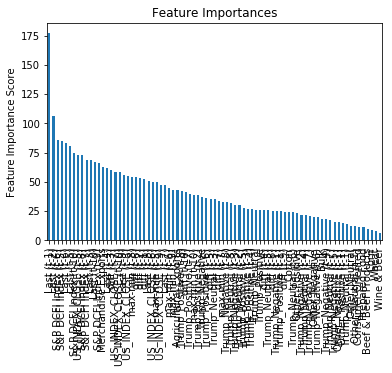

<Figure size 1440x1440 with 0 Axes>


best params 
 {'subsample': 0.6, 'reg_alpha': 0.1, 'n_estimators': 175, 'min_child_weight': 4, 'max_depth': 13, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 0.6}



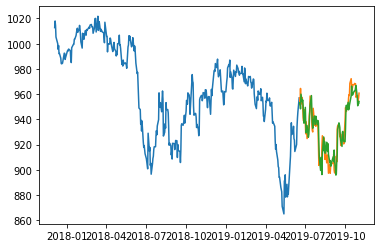

In [290]:
test_rsq, test_rmse, test_mae, train_rsq, xg_random, test_x20, \
    feat_imp,test_results = predict_soybean_futures(drp_unimp_feat_data)

In [291]:
test_results

Last     predict       diff
Date                                     
2019-06-18  957.00  952.575317   4.424683
2019-06-19  951.25  953.359619  -2.109619
2019-06-20  964.50  948.340820  16.159180
2019-06-21  952.00  959.940979  -7.940979
2019-06-24  957.25  953.841797   3.408203
...            ...         ...        ...
2019-10-28  958.75  957.534729   1.215271
2019-10-29  957.75  950.750061   6.999939
2019-10-30  955.00  953.371765   1.628235
2019-10-31  957.00  952.359375   4.640625
2019-11-01  960.75  954.166199   6.583801

[97 rows x 3 columns]

columns being used:
Index(['Other_Positive', 'Other_Negative', 'Other_Neutral',
       'Agricultural Exports', 'Beef & Beef Products', 'Bulk',
       'Consumer Oriented', 'Corn', 'Cotton', 'Dairy Products',
       'Feeds & Fodders', 'Fresh & Processed Fruit',
       'Fresh & Processed Vegetables', 'Hides & Skins', 'Intermediates',
       'Juices & Beverages', 'Merchandise Exports', 'Pork & Pork Products',
       'Poultry Meat & Products', 'Prepared Food', 'Rice',
       'Soybean & Vegetable Oil', 'Soybeans', 'Soymeal', 'Tobacco',
       'Tree Nuts', 'Wheat', 'Wine & Beer', 'Trump_Positive', 'Trump_Negative',
       'Trump_Neutral', 'Last (t-1)', 'diff (t-1)', 'Last (t-2)', 'diff (t-2)',
       'Last (t-3)', 'diff (t-3)', 'Last (t-4)', 'diff (t-4)', 'Last (t-5)',
       'diff (t-5)', 'Last (t-6)', 'diff (t-6)', 'Last (t-7)', 'diff (t-7)',
       'Last (t-8)', 'diff (t-8)', 'Last (t-9)', 'diff (t-9)', 'Last (t-10)',
       'diff (t-10)', 'S&P DCFI Index (t-5)', 'max-min (t-5)',
       'S

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 855 tasks      | elapsed:   30.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   35.2s finished


[15:22:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training R-squared:  1.0
Training Explained Variation:  1.0
Training RMSE:  0.21
Training MAE:  0.15  

Test R-squared:  0.89
Test Explained Variation:  0.89
Test RMSE:  7.27
Test MAE:  5.67


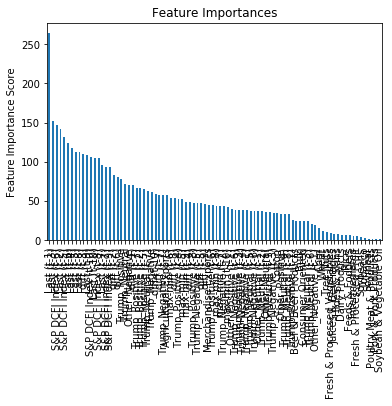

<Figure size 1440x1440 with 0 Axes>


best params 
 {'subsample': 0.8, 'reg_alpha': 0.01, 'n_estimators': 165, 'min_child_weight': 2, 'max_depth': 19, 'learning_rate': 0.1, 'gamma': 0.4, 'colsample_bytree': 0.7}



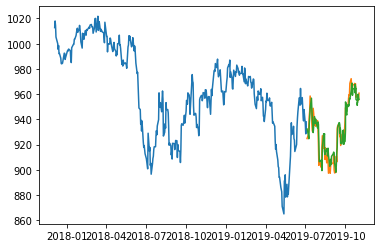

In [110]:
test_rsq, test_rmse, test_mae, train_rsq, xg_random, test_x20, \
    feat_imp = predict_soybean_futures(lagged_data)

In [248]:
feat_imp.to_csv('feature_importances_may_new.csv')

columns being used:
Index(['Other_Positive', 'Other_Negative', 'Other_Neutral',
       'Agricultural Exports', 'Beef & Beef Products', 'Bulk',
       'Consumer Oriented', 'Corn', 'Cotton', 'Merchandise Exports',
       'Prepared Food', 'Wheat', 'Wine & Beer', 'Trump_Positive',
       'Trump_Negative', 'Trump_Neutral', 'Last (t-1)', 'diff (t-1)',
       'Last (t-2)', 'diff (t-2)', 'Last (t-3)', 'diff (t-3)', 'Last (t-4)',
       'diff (t-4)', 'Last (t-5)', 'diff (t-5)', 'Last (t-6)', 'diff (t-6)',
       'Last (t-7)', 'diff (t-7)', 'Last (t-8)', 'diff (t-8)', 'Last (t-9)',
       'diff (t-9)', 'Last (t-10)', 'diff (t-10)', 'S&P DCFI Index (t-5)',
       'max-min (t-5)', 'S&P DCFI Index (t-6)', 'max-min (t-6)',
       'S&P DCFI Index (t-7)', 'max-min (t-7)', 'S&P DCFI Index (t-8)',
       'max-min (t-8)', 'S&P DCFI Index (t-9)', 'max-min (t-9)',
       'S&P DCFI Index (t-10)', 'max-min (t-10)', 'Other_Positive (t-1)',
       'Other_Negative (t-1)', 'Other_Neutral (t-1)', 'Trump_Positive 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 816 tasks      | elapsed:   27.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   32.3s finished


[15:45:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training R-squared:  1.0
Training Explained Variation:  1.0
Training RMSE:  0.48
Training MAE:  0.28  

Test R-squared:  0.89
Test Explained Variation:  0.9
Test RMSE:  7.25
Test MAE:  5.8


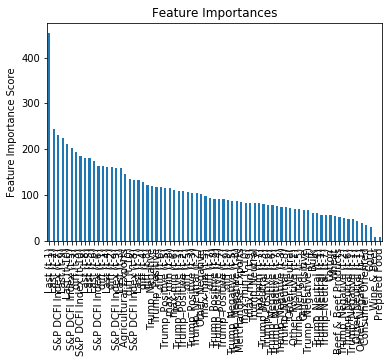

<Figure size 1440x1440 with 0 Axes>


best params 
 {'subsample': 0.9, 'reg_alpha': 1, 'n_estimators': 195, 'min_child_weight': 2, 'max_depth': 16, 'learning_rate': 0.05, 'gamma': 0.0, 'colsample_bytree': 0.8}



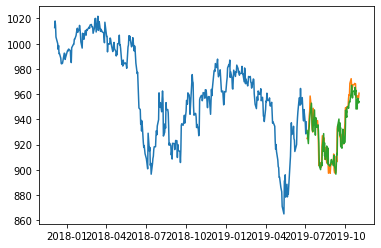

In [114]:
test_rsq, test_rmse, test_mae, train_rsq, xg_random, test_x20, \
    feat_imp = predict_soybean_futures(drp_unimp_feat_data)

In [272]:
data2 = data
data = drp_unimp_feat_data
predict = 'Last'

rows,cols = data.shape
#train test splits
split = int(0.8*rows)

train=data.iloc[:split,]
test=data.iloc[split:,]

train_y=train[[predict]]
train_x=train.loc[:,train.columns != predict]
print('columns being used:')
print(train_x.columns)
print()
test_y=test[[predict]]
test_x=test.loc[:,test.columns != predict]

columns being used:
Index(['Other_Positive', 'Other_Negative', 'Other_Neutral',
       'Agricultural Exports', 'Beef & Beef Products', 'Bulk',
       'Consumer Oriented', 'Corn', 'Cotton', 'Merchandise Exports',
       'Prepared Food', 'Wheat', 'Wine & Beer', 'Trump_Positive',
       'Trump_Negative', 'Trump_Neutral', 'Last (t-1)', 'diff (t-1)',
       'Last (t-2)', 'diff (t-2)', 'Last (t-3)', 'diff (t-3)', 'Last (t-4)',
       'diff (t-4)', 'Last (t-5)', 'diff (t-5)', 'Last (t-6)', 'diff (t-6)',
       'Last (t-7)', 'diff (t-7)', 'Last (t-8)', 'diff (t-8)', 'Last (t-9)',
       'diff (t-9)', 'Last (t-10)', 'diff (t-10)', 'S&P DCFI Index (t-5)',
       'max-min (t-5)', 'US_INDEX_CLOSE (t-5)', 'S&P DCFI Index (t-6)',
       'max-min (t-6)', 'US_INDEX_CLOSE (t-6)', 'S&P DCFI Index (t-7)',
       'max-min (t-7)', 'US_INDEX_CLOSE (t-7)', 'S&P DCFI Index (t-8)',
       'max-min (t-8)', 'US_INDEX_CLOSE (t-8)', 'S&P DCFI Index (t-9)',
       'max-min (t-9)', 'US_INDEX_CLOSE (t-9)', 'S&P DCFI 

In [274]:
# Grid Search for best parameters
param_test = {'max_depth':list(range(10,25,2)), 
              'min_child_weight':list(range(1,8,2))}

gsearch=GridSearchCV(estimator=xgb.XGBRegressor(learning_rate=0.15,
                                                n_estimators=100,
                                                max_depth=24,
                                                min_child_weight=1,
                                                gamma=0,
                                                subsample=0.9,
                                                colsample_bytree=0.8,
                                                njobs=-1,
                                                scale_pos_weight=1,
                                                seed=123),
                      param_grid=param_test,
                      scoring='neg_median_absolute_error',
                      n_jobs=-1,
                      iid=True,
                      cv=5, verbose=1)

gsearch.fit(train_x,train_y)
print("Best Score:",gsearch.best_score_)
print("Best parameters:",gsearch.best_params_)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    8.8s finished


[19:09:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best Score: -6.382892667938391
Best parameters: {'max_depth': 24, 'min_child_weight': 1}


In [275]:
# Grid Search for best parameters
param_test = {'learning_rate':list(np.arange(0.05,1,0.05)), 
              'n_estimators':list(range(100,225,10))}

gsearch=GridSearchCV(estimator=xgb.XGBRegressor(learning_rate=0.35,
                                                n_estimators=100,
                                                max_depth=24,
                                                min_child_weight=1,
                                                gamma=0,
                                                subsample=0.9,
                                                colsample_bytree=0.8,
                                                njobs=-1,
                                                scale_pos_weight=1,
                                                seed=123),
                      param_grid=param_test,
                      scoring='neg_median_absolute_error',
                      n_jobs=-1,
                      iid=True,
                      cv=5, verbose=1)

gsearch.fit(train_x,train_y)
print("Best Score:",gsearch.best_score_)
print("Best parameters:",gsearch.best_params_)

Fitting 5 folds for each of 247 candidates, totalling 1235 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   41.6s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1235 out of 1235 | elapsed:  1.8min finished


[19:11:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best Score: -6.220795152100874
Best parameters: {'learning_rate': 0.35000000000000003, 'n_estimators': 100}


In [276]:
# Grid Search for best parameters
param_test = {'reg_lambda':[0.001,1,0.01]}

gsearch=GridSearchCV(estimator=xgb.XGBRegressor(learning_rate=0.35,
                                                n_estimators=100,
                                                max_depth=24,
                                                min_child_weight=1,
                                                gamma=0,
                                                subsample=0.9,
                                                colsample_bytree=0.8,
                                                njobs=-1,
                                                scale_pos_weight=1,
                                                seed=123),
                      param_grid=param_test,
                      scoring='neg_median_absolute_error',
                      n_jobs=-1,
                      iid=True,
                      cv=5, verbose=1)

gsearch.fit(train_x,train_y)
print("Best Score:",gsearch.best_score_)
print("Best parameters:",gsearch.best_params_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    0.5s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.6s finished


[19:13:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best Score: -6.220795152100874
Best parameters: {'reg_lambda': 1}


In [312]:
data = prepare_data("Final_Data/Soybean_Futures_July_2020.csv")
print(data.columns)
data.tail(10)

post tweet
                   Date    Open    High     Low    Last  Change  Volume  \
Date                                                                     
2019-10-28  10/28/2019  967.00  973.00  967.00  969.00    2.00   14491   
2019-10-29  10/29/2019  969.00  973.00  965.50  968.25   -0.75   17773   
2019-10-30  10/30/2019  968.00  971.25  964.50  965.25   -3.00   16641   
2019-10-31  10/31/2019  964.00  968.75  960.25  967.25    2.00   13453   
2019-11-01   11/1/2019  965.75  971.75  965.50  970.75    3.50   11136   

            Open Int  Other_Positive  Other_Negative  Other_Neutral  
Date                                                                 
2019-10-28     74882           0.489           0.039          2.472  
2019-10-29     75906           1.256           0.206          8.538  
2019-10-30     76017           0.595           0.069          3.336  
2019-10-31     78269           0.994           0.074         11.931  
2019-11-01         0             NaN             

Open    Last  Other_Positive  Other_Negative  Other_Neutral  \
Date                                                                        
2019-10-21  973.00  975.50             NaN             NaN            NaN   
2019-10-22  974.75  976.75           0.000           0.000          1.000   
2019-10-23  976.25  976.50           0.000           0.000          1.000   
2019-10-24  976.00  976.75             NaN             NaN            NaN   
2019-10-25  976.00  967.00             NaN             NaN            NaN   
2019-10-28  967.00  969.00           0.489           0.039          2.472   
2019-10-29  969.00  968.25           1.256           0.206          8.538   
2019-10-30  968.00  965.25           0.595           0.069          3.336   
2019-10-31  964.00  967.25           0.994           0.074         11.931   
2019-11-01  965.75  970.75             NaN             NaN            NaN   

            Agricultural Exports  Beef & Beef Products     Bulk  \
Date                                                              
2019-10-21              -12.0892              -11.6055 -18.0102   
2019-10-22              -12.0892              -11.6055 -18.0102   
2019-10-23              -12.0892              -11.6055 -18.0102   
2019-10-24              -12.0892              -11.6055 -18.0102   
2019-10-25              -12.0892              -11.6055 -18.0102   
2019-10-28              -12.0892              -11.6055 -18.0102   
2019-10-29              -12.0892              -11.6055 -18.0102   
2019-10-30              -12.0892              -11.6055 -18.0102   
2019-10-31              -12.0892              -11.6055 -18.0102   
2019-11-01              -12.2800              -11.5268 -18.1140   

            Consumer Oriented     Corn  ...  Tree Nuts    Wheat  Wine & Beer  \
Date                                    ...                                    
2019-10-21            -5.6166 -15.6872  ...    -5.2488 -11.1210      -5.7693   
2019-10-22            -5.6166 -15.6872  ...    -5.2488 -11.1210      -5.7693   
2019-10-23            -5.6166 -15.6872  ...    -5.2488 -11.1210      -5.7693   
2019-10-24            -5.6166 -15.6872  ...    -5.2488 -11.1210      -5.7693   
2019-10-25            -5.6166 -15.6872  ...    -5.2488 -11.1210      -5.7693   
2019-10-28            -5.6166 -15.6872  ...    -5.2488 -11.1210      -5.7693   
2019-10-29            -5.6166 -15.6872  ...    -5.2488 -11.1210      -5.7693   
2019-10-30            -5.6166 -15.6872  ...    -5.2488 -11.1210      -5.7693   
2019-10-31            -5.6166 -15.6872  ...    -5.2488 -11.1210      -5.7693   
2019-11-01            -5.4908 -15.9724  ...    -5.0531 -10.7255      -5.5764   

            Trump_Positive  Trump_Negative  Trump_Neutral  S&P DCFI Index  \
Date                                                                        
2019-10-21             NaN             NaN            NaN          121.92   
2019-10-22             NaN             NaN            NaN          121.85   
2019-10-23             NaN             NaN            NaN          120.87   
2019-10-24             NaN             NaN            NaN          121.09   
2019-10-25             NaN             NaN            NaN          120.70   
2019-10-28             NaN             NaN            NaN          120.82   
2019-10-29             NaN             NaN            NaN          120.88   
2019-10-30             NaN             NaN            NaN          120.69   
2019-10-31             NaN             NaN            NaN          121.70   
2019-11-01             NaN             NaN            NaN          120.52   

            US_INDEX_CLOSE  diff  max-min  
Date                                       
2019-10-21           97.30  2.50    10.75  
2019-10-22           97.50  2.00    11.25  
2019-10-23           97.45  0.25     8.50  
2019-10-24           97.68  0.75     6.00  
2019-10-25           97.82 -9.00    16.00  
2019-10-28           97.75  2.00     6.00  
2019-10-29           97.68 -0.75     7.50  
20

In [313]:
lagged_data.tail(10)

Open  Other_Positive  Other_Negative  Other_Neutral  \
Date                                                                
2019-10-21  973.00             NaN             NaN            NaN   
2019-10-22  974.75           0.000           0.000          1.000   
2019-10-23  976.25           0.000           0.000          1.000   
2019-10-24  976.00             NaN             NaN            NaN   
2019-10-25  976.00             NaN             NaN            NaN   
2019-10-28  967.00           0.489           0.039          2.472   
2019-10-29  969.00           1.256           0.206          8.538   
2019-10-30  968.00           0.595           0.069          3.336   
2019-10-31  964.00           0.994           0.074         11.931   
2019-11-01  965.75             NaN             NaN            NaN   

            Agricultural Exports  Beef & Beef Products     Bulk  \
Date                                                              
2019-10-21              -12.0892              -11.6055 -18.0102   
2019-10-22              -12.0892              -11.6055 -18.0102   
2019-10-23              -12.0892              -11.6055 -18.0102   
2019-10-24              -12.0892              -11.6055 -18.0102   
2019-10-25              -12.0892              -11.6055 -18.0102   
2019-10-28              -12.0892              -11.6055 -18.0102   
2019-10-29              -12.0892              -11.6055 -18.0102   
2019-10-30              -12.0892              -11.6055 -18.0102   
2019-10-31              -12.0892              -11.6055 -18.0102   
2019-11-01              -12.2800              -11.5268 -18.1140   

            Consumer Oriented     Corn  Cotton  ...  Other_Neutral (t-7)  \
Date                                            ...                        
2019-10-21            -5.6166 -15.6872 -9.7190  ...                  NaN   
2019-10-22            -5.6166 -15.6872 -9.7190  ...                  NaN   
2019-10-23            -5.6166 -15.6872 -9.7190  ...                  NaN   
2019-10-24            -5.6166 -15.6872 -9.7190  ...                0.771   
2019-10-25            -5.6166 -15.6872 -9.7190  ...                1.000   
2019-10-28            -5.6166 -15.6872 -9.7190  ...                  NaN   
2019-10-29            -5.6166 -15.6872 -9.7190  ...                  NaN   
2019-10-30            -5.6166 -15.6872 -9.7190  ...                  NaN   
2019-10-31            -5.6166 -15.6872 -9.7190  ...                1.000   
2019-11-01            -5.4908 -15.9724 -9.6885  ...                1.000   

            Other_Positive (t-8)  Other_Negative (t-8)  Other_Neutral (t-8)  \
Date                                                                          
2019-10-21                   NaN                   NaN                  NaN   
2019-10-22                   NaN                   NaN                  NaN   
2019-10-23                   NaN                   NaN                  NaN   
2019-10-24                   NaN                   NaN                  NaN   
2019-10-25                   0.0                 0.229                0.771   
2019-10-28                   0.0                 0.000                1.000   
2019-10-29                   NaN                   NaN                  NaN   
2019-10-30                   NaN                   NaN                  NaN   
2019-10-31                   NaN                   NaN                  NaN   
2019-11-01                   0.0                 0.000                1.000   

            Other_Positive (t-9)  Other_Negative (t-9)  Other_Neutral (t-9)  \
Date                                                                          
2019-10-21                   NaN                   NaN                  NaN   
2019-10-22                   NaN                   NaN                  NaN   
2019-10-23                   NaN                   NaN                  NaN   
2019-10-24                   NaN                   NaN                  NaN   
2019-10-25                   NaN            


lagging prices by : 8
lagging trump tweets by : 6
lagging tweets by : 1
columns being used:
Index(['Other_Positive', 'Other_Negative', 'Other_Neutral',
       'Agricultural Exports', 'Beef & Beef Products', 'Bulk',
       'Consumer Oriented', 'Corn', 'Cotton', 'Dairy Products',
       'Feeds & Fodders', 'Fresh & Processed Fruit',
       'Fresh & Processed Vegetables', 'Hides & Skins', 'Intermediates',
       'Juices & Beverages', 'Merchandise Exports', 'Pork & Pork Products',
       'Poultry Meat & Products', 'Prepared Food', 'Rice',
       'Soybean & Vegetable Oil', 'Soybeans', 'Soymeal', 'Tobacco',
       'Tree Nuts', 'Wheat', 'Wine & Beer', 'Trump_Positive', 'Trump_Negative',
       'Trump_Neutral', 'Last (t-1)', 'diff (t-1)', 'Last (t-2)', 'diff (t-2)',
       'Last (t-3)', 'diff (t-3)', 'Last (t-4)', 'diff (t-4)', 'Last (t-5)',
       'diff (t-5)', 'Last (t-6)', 'diff (t-6)', 'Last (t-7)', 'diff (t-7)',
       'S&P DCFI Index (t-5)', 'max-min (t-5)', 'US_INDEX_CLOSE (t-5)',
     

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    8.0s finished


[18:29:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training R-squared:  1.0
Training Explained Variation:  1.0
Training RMSE:  0.57
Training MAE:  0.31  

Test R-squared:  0.84
Test Explained Variation:  0.84
Test RMSE:  8.36
Test MAE:  6.66


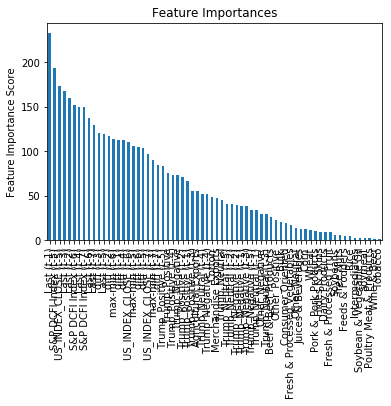

<Figure size 1440x1440 with 0 Axes>


best params 
 {'subsample': 0.7, 'reg_alpha': 1, 'n_estimators': 125, 'min_child_weight': 3, 'max_depth': 17, 'learning_rate': 0.1, 'gamma': 0.0, 'colsample_bytree': 0.8}



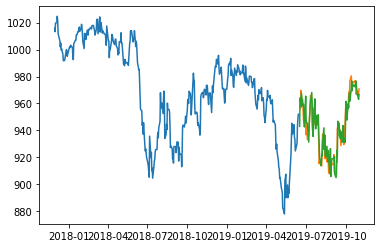


lagging prices by : 8
lagging trump tweets by : 6
lagging tweets by : 2
columns being used:
Index(['Other_Positive', 'Other_Negative', 'Other_Neutral',
       'Agricultural Exports', 'Beef & Beef Products', 'Bulk',
       'Consumer Oriented', 'Corn', 'Cotton', 'Dairy Products',
       'Feeds & Fodders', 'Fresh & Processed Fruit',
       'Fresh & Processed Vegetables', 'Hides & Skins', 'Intermediates',
       'Juices & Beverages', 'Merchandise Exports', 'Pork & Pork Products',
       'Poultry Meat & Products', 'Prepared Food', 'Rice',
       'Soybean & Vegetable Oil', 'Soybeans', 'Soymeal', 'Tobacco',
       'Tree Nuts', 'Wheat', 'Wine & Beer', 'Trump_Positive', 'Trump_Negative',
       'Trump_Neutral', 'Last (t-1)', 'diff (t-1)', 'Last (t-2)', 'diff (t-2)',
       'Last (t-3)', 'diff (t-3)', 'Last (t-4)', 'diff (t-4)', 'Last (t-5)',
       'diff (t-5)', 'Last (t-6)', 'diff (t-6)', 'Last (t-7)', 'diff (t-7)',
       'S&P DCFI Index (t-5)', 'max-min (t-5)', 'US_INDEX_CLOSE (t-5)',
     

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    9.0s finished


[18:29:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training R-squared:  1.0
Training Explained Variation:  1.0
Training RMSE:  1.9
Training MAE:  1.31  

Test R-squared:  0.83
Test Explained Variation:  0.83
Test RMSE:  8.5
Test MAE:  7.0


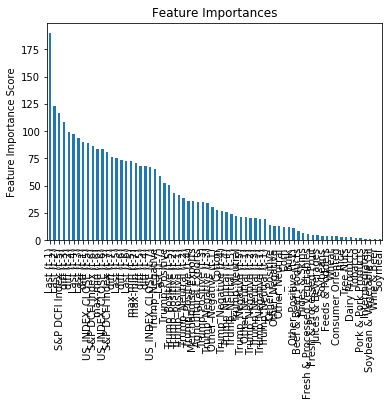

<Figure size 1440x1440 with 0 Axes>


best params 
 {'subsample': 0.6, 'reg_alpha': 1, 'n_estimators': 195, 'min_child_weight': 4, 'max_depth': 9, 'learning_rate': 0.05, 'gamma': 0.3, 'colsample_bytree': 0.9}



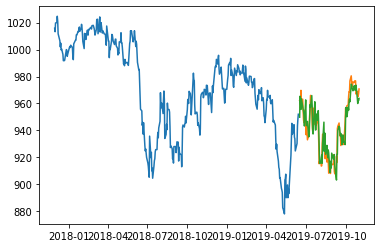


lagging prices by : 8
lagging trump tweets by : 6
lagging tweets by : 3
columns being used:
Index(['Other_Positive', 'Other_Negative', 'Other_Neutral',
       'Agricultural Exports', 'Beef & Beef Products', 'Bulk',
       'Consumer Oriented', 'Corn', 'Cotton', 'Dairy Products',
       'Feeds & Fodders', 'Fresh & Processed Fruit',
       'Fresh & Processed Vegetables', 'Hides & Skins', 'Intermediates',
       'Juices & Beverages', 'Merchandise Exports', 'Pork & Pork Products',
       'Poultry Meat & Products', 'Prepared Food', 'Rice',
       'Soybean & Vegetable Oil', 'Soybeans', 'Soymeal', 'Tobacco',
       'Tree Nuts', 'Wheat', 'Wine & Beer', 'Trump_Positive', 'Trump_Negative',
       'Trump_Neutral', 'Last (t-1)', 'diff (t-1)', 'Last (t-2)', 'diff (t-2)',
       'Last (t-3)', 'diff (t-3)', 'Last (t-4)', 'diff (t-4)', 'Last (t-5)',
       'diff (t-5)', 'Last (t-6)', 'diff (t-6)', 'Last (t-7)', 'diff (t-7)',
       'S&P DCFI Index (t-5)', 'max-min (t-5)', 'US_INDEX_CLOSE (t-5)',
     

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    8.6s finished


[18:29:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training R-squared:  1.0
Training Explained Variation:  1.0
Training RMSE:  1.83
Training MAE:  1.26  

Test R-squared:  0.83
Test Explained Variation:  0.83
Test RMSE:  8.47
Test MAE:  7.11


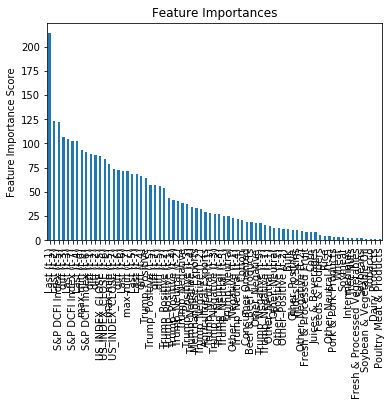

<Figure size 1440x1440 with 0 Axes>


best params 
 {'subsample': 0.6, 'reg_alpha': 1, 'n_estimators': 195, 'min_child_weight': 4, 'max_depth': 9, 'learning_rate': 0.05, 'gamma': 0.3, 'colsample_bytree': 0.9}



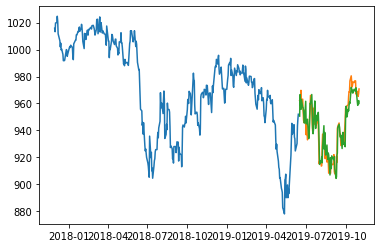


lagging prices by : 8
lagging trump tweets by : 7
lagging tweets by : 1
columns being used:
Index(['Other_Positive', 'Other_Negative', 'Other_Neutral',
       'Agricultural Exports', 'Beef & Beef Products', 'Bulk',
       'Consumer Oriented', 'Corn', 'Cotton', 'Dairy Products',
       'Feeds & Fodders', 'Fresh & Processed Fruit',
       'Fresh & Processed Vegetables', 'Hides & Skins', 'Intermediates',
       'Juices & Beverages', 'Merchandise Exports', 'Pork & Pork Products',
       'Poultry Meat & Products', 'Prepared Food', 'Rice',
       'Soybean & Vegetable Oil', 'Soybeans', 'Soymeal', 'Tobacco',
       'Tree Nuts', 'Wheat', 'Wine & Beer', 'Trump_Positive', 'Trump_Negative',
       'Trump_Neutral', 'Last (t-1)', 'diff (t-1)', 'Last (t-2)', 'diff (t-2)',
       'Last (t-3)', 'diff (t-3)', 'Last (t-4)', 'diff (t-4)', 'Last (t-5)',
       'diff (t-5)', 'Last (t-6)', 'diff (t-6)', 'Last (t-7)', 'diff (t-7)',
       'S&P DCFI Index (t-5)', 'max-min (t-5)', 'US_INDEX_CLOSE (t-5)',
     

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    8.9s finished


[18:29:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training R-squared:  1.0
Training Explained Variation:  1.0
Training RMSE:  1.9
Training MAE:  1.25  

Test R-squared:  0.83
Test Explained Variation:  0.83
Test RMSE:  8.55
Test MAE:  7.16


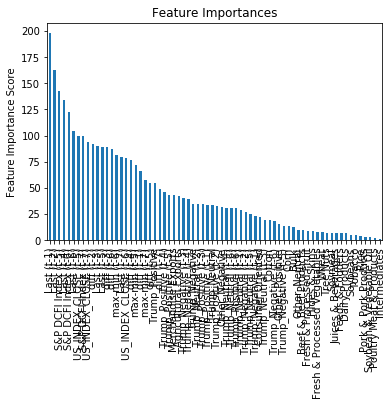

<Figure size 1440x1440 with 0 Axes>


best params 
 {'subsample': 0.6, 'reg_alpha': 0.1, 'n_estimators': 175, 'min_child_weight': 4, 'max_depth': 13, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 0.6}



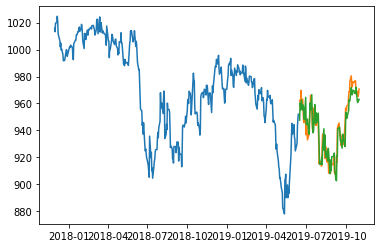


lagging prices by : 8
lagging trump tweets by : 7
lagging tweets by : 2
columns being used:
Index(['Other_Positive', 'Other_Negative', 'Other_Neutral',
       'Agricultural Exports', 'Beef & Beef Products', 'Bulk',
       'Consumer Oriented', 'Corn', 'Cotton', 'Dairy Products',
       'Feeds & Fodders', 'Fresh & Processed Fruit',
       'Fresh & Processed Vegetables', 'Hides & Skins', 'Intermediates',
       'Juices & Beverages', 'Merchandise Exports', 'Pork & Pork Products',
       'Poultry Meat & Products', 'Prepared Food', 'Rice',
       'Soybean & Vegetable Oil', 'Soybeans', 'Soymeal', 'Tobacco',
       'Tree Nuts', 'Wheat', 'Wine & Beer', 'Trump_Positive', 'Trump_Negative',
       'Trump_Neutral', 'Last (t-1)', 'diff (t-1)', 'Last (t-2)', 'diff (t-2)',
       'Last (t-3)', 'diff (t-3)', 'Last (t-4)', 'diff (t-4)', 'Last (t-5)',
       'diff (t-5)', 'Last (t-6)', 'diff (t-6)', 'Last (t-7)', 'diff (t-7)',
       'S&P DCFI Index (t-5)', 'max-min (t-5)', 'US_INDEX_CLOSE (t-5)',
     

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 267 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    9.4s finished


[18:29:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training R-squared:  1.0
Training Explained Variation:  1.0
Training RMSE:  0.53
Training MAE:  0.29  

Test R-squared:  0.82
Test Explained Variation:  0.82
Test RMSE:  8.83
Test MAE:  7.33


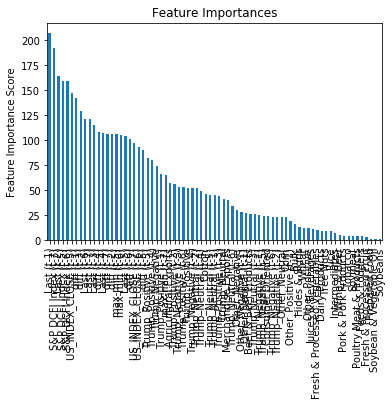

<Figure size 1440x1440 with 0 Axes>


best params 
 {'subsample': 0.7, 'reg_alpha': 1, 'n_estimators': 125, 'min_child_weight': 3, 'max_depth': 17, 'learning_rate': 0.1, 'gamma': 0.0, 'colsample_bytree': 0.8}



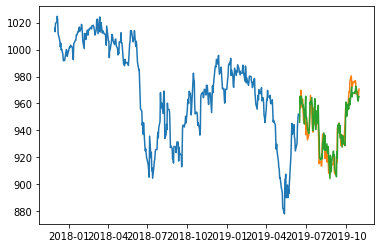


lagging prices by : 8
lagging trump tweets by : 7
lagging tweets by : 3
columns being used:
Index(['Other_Positive', 'Other_Negative', 'Other_Neutral',
       'Agricultural Exports', 'Beef & Beef Products', 'Bulk',
       'Consumer Oriented', 'Corn', 'Cotton', 'Dairy Products',
       'Feeds & Fodders', 'Fresh & Processed Fruit',
       'Fresh & Processed Vegetables', 'Hides & Skins', 'Intermediates',
       'Juices & Beverages', 'Merchandise Exports', 'Pork & Pork Products',
       'Poultry Meat & Products', 'Prepared Food', 'Rice',
       'Soybean & Vegetable Oil', 'Soybeans', 'Soymeal', 'Tobacco',
       'Tree Nuts', 'Wheat', 'Wine & Beer', 'Trump_Positive', 'Trump_Negative',
       'Trump_Neutral', 'Last (t-1)', 'diff (t-1)', 'Last (t-2)', 'diff (t-2)',
       'Last (t-3)', 'diff (t-3)', 'Last (t-4)', 'diff (t-4)', 'Last (t-5)',
       'diff (t-5)', 'Last (t-6)', 'diff (t-6)', 'Last (t-7)', 'diff (t-7)',
       'S&P DCFI Index (t-5)', 'max-min (t-5)', 'US_INDEX_CLOSE (t-5)',
     

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    9.1s finished


[18:30:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training R-squared:  0.99
Training Explained Variation:  1.0
Training RMSE:  2.55
Training MAE:  1.83  

Test R-squared:  0.83
Test Explained Variation:  0.83
Test RMSE:  8.57
Test MAE:  6.95


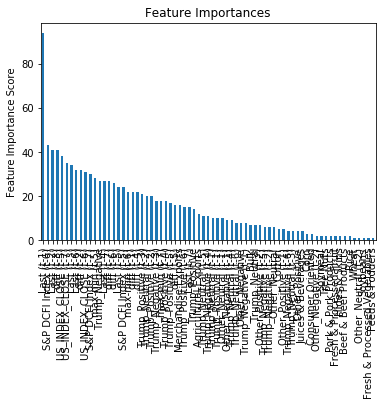

<Figure size 1440x1440 with 0 Axes>


best params 
 {'subsample': 0.9, 'reg_alpha': 0.01, 'n_estimators': 65, 'min_child_weight': 4, 'max_depth': 14, 'learning_rate': 0.1, 'gamma': 0.4, 'colsample_bytree': 0.9}



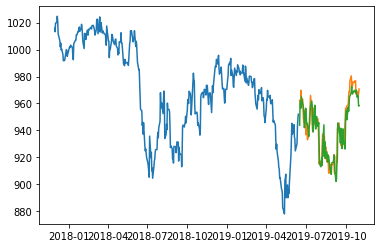


lagging prices by : 8
lagging trump tweets by : 8
lagging tweets by : 1
columns being used:
Index(['Other_Positive', 'Other_Negative', 'Other_Neutral',
       'Agricultural Exports', 'Beef & Beef Products', 'Bulk',
       'Consumer Oriented', 'Corn', 'Cotton', 'Dairy Products',
       'Feeds & Fodders', 'Fresh & Processed Fruit',
       'Fresh & Processed Vegetables', 'Hides & Skins', 'Intermediates',
       'Juices & Beverages', 'Merchandise Exports', 'Pork & Pork Products',
       'Poultry Meat & Products', 'Prepared Food', 'Rice',
       'Soybean & Vegetable Oil', 'Soybeans', 'Soymeal', 'Tobacco',
       'Tree Nuts', 'Wheat', 'Wine & Beer', 'Trump_Positive', 'Trump_Negative',
       'Trump_Neutral', 'Last (t-1)', 'diff (t-1)', 'Last (t-2)', 'diff (t-2)',
       'Last (t-3)', 'diff (t-3)', 'Last (t-4)', 'diff (t-4)', 'Last (t-5)',
       'diff (t-5)', 'Last (t-6)', 'diff (t-6)', 'Last (t-7)', 'diff (t-7)',
       'S&P DCFI Index (t-5)', 'max-min (t-5)', 'US_INDEX_CLOSE (t-5)',
     

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   10.3s finished


[18:30:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training R-squared:  1.0
Training Explained Variation:  1.0
Training RMSE:  1.46
Training MAE:  0.97  

Test R-squared:  0.83
Test Explained Variation:  0.84
Test RMSE:  8.66
Test MAE:  7.07


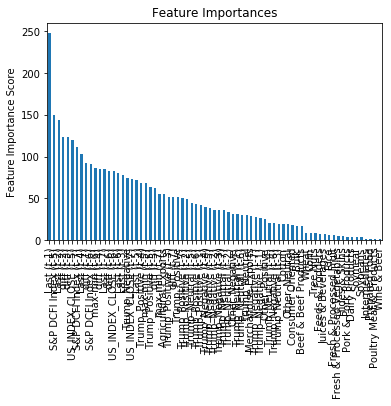

<Figure size 1440x1440 with 0 Axes>


best params 
 {'subsample': 0.9, 'reg_alpha': 1, 'n_estimators': 155, 'min_child_weight': 3, 'max_depth': 14, 'learning_rate': 0.05, 'gamma': 0.3, 'colsample_bytree': 0.8}



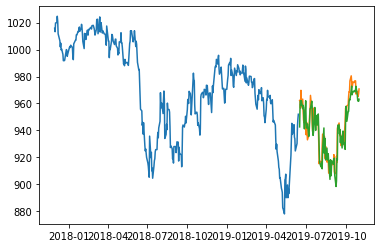


lagging prices by : 8
lagging trump tweets by : 8
lagging tweets by : 2
columns being used:
Index(['Other_Positive', 'Other_Negative', 'Other_Neutral',
       'Agricultural Exports', 'Beef & Beef Products', 'Bulk',
       'Consumer Oriented', 'Corn', 'Cotton', 'Dairy Products',
       'Feeds & Fodders', 'Fresh & Processed Fruit',
       'Fresh & Processed Vegetables', 'Hides & Skins', 'Intermediates',
       'Juices & Beverages', 'Merchandise Exports', 'Pork & Pork Products',
       'Poultry Meat & Products', 'Prepared Food', 'Rice',
       'Soybean & Vegetable Oil', 'Soybeans', 'Soymeal', 'Tobacco',
       'Tree Nuts', 'Wheat', 'Wine & Beer', 'Trump_Positive', 'Trump_Negative',
       'Trump_Neutral', 'Last (t-1)', 'diff (t-1)', 'Last (t-2)', 'diff (t-2)',
       'Last (t-3)', 'diff (t-3)', 'Last (t-4)', 'diff (t-4)', 'Last (t-5)',
       'diff (t-5)', 'Last (t-6)', 'diff (t-6)', 'Last (t-7)', 'diff (t-7)',
       'S&P DCFI Index (t-5)', 'max-min (t-5)', 'US_INDEX_CLOSE (t-5)',
     

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    9.7s finished


[18:30:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training R-squared:  1.0
Training Explained Variation:  1.0
Training RMSE:  0.58
Training MAE:  0.31  

Test R-squared:  0.79
Test Explained Variation:  0.79
Test RMSE:  9.48
Test MAE:  7.94


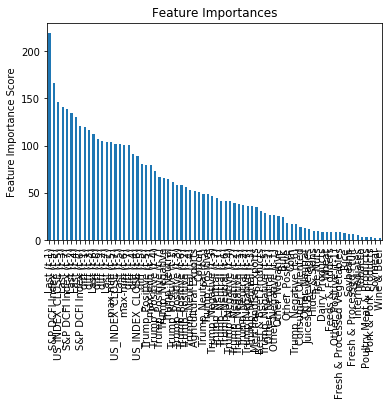

<Figure size 1440x1440 with 0 Axes>


best params 
 {'subsample': 0.7, 'reg_alpha': 1, 'n_estimators': 125, 'min_child_weight': 3, 'max_depth': 17, 'learning_rate': 0.1, 'gamma': 0.0, 'colsample_bytree': 0.8}



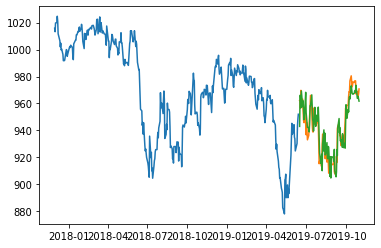


lagging prices by : 8
lagging trump tweets by : 8
lagging tweets by : 3
columns being used:
Index(['Other_Positive', 'Other_Negative', 'Other_Neutral',
       'Agricultural Exports', 'Beef & Beef Products', 'Bulk',
       'Consumer Oriented', 'Corn', 'Cotton', 'Dairy Products',
       'Feeds & Fodders', 'Fresh & Processed Fruit',
       'Fresh & Processed Vegetables', 'Hides & Skins', 'Intermediates',
       'Juices & Beverages', 'Merchandise Exports', 'Pork & Pork Products',
       'Poultry Meat & Products', 'Prepared Food', 'Rice',
       'Soybean & Vegetable Oil', 'Soybeans', 'Soymeal', 'Tobacco',
       'Tree Nuts', 'Wheat', 'Wine & Beer', 'Trump_Positive', 'Trump_Negative',
       'Trump_Neutral', 'Last (t-1)', 'diff (t-1)', 'Last (t-2)', 'diff (t-2)',
       'Last (t-3)', 'diff (t-3)', 'Last (t-4)', 'diff (t-4)', 'Last (t-5)',
       'diff (t-5)', 'Last (t-6)', 'diff (t-6)', 'Last (t-7)', 'diff (t-7)',
       'S&P DCFI Index (t-5)', 'max-min (t-5)', 'US_INDEX_CLOSE (t-5)',
     

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 270 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    9.6s finished


[18:30:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training R-squared:  1.0
Training Explained Variation:  1.0
Training RMSE:  1.63
Training MAE:  0.98  

Test R-squared:  0.8
Test Explained Variation:  0.8
Test RMSE:  9.2
Test MAE:  7.49


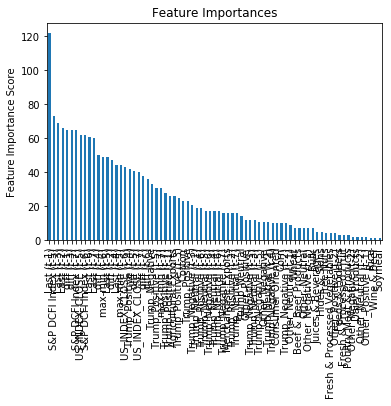

<Figure size 1440x1440 with 0 Axes>


best params 
 {'subsample': 0.7, 'reg_alpha': 0.01, 'n_estimators': 85, 'min_child_weight': 4, 'max_depth': 17, 'learning_rate': 0.1, 'gamma': 0.2, 'colsample_bytree': 0.8}



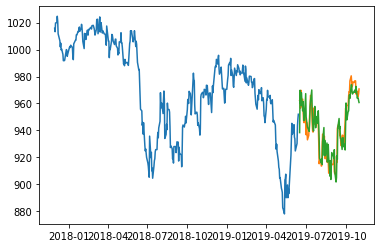


lagging prices by : 8
lagging trump tweets by : 9
lagging tweets by : 1
columns being used:
Index(['Other_Positive', 'Other_Negative', 'Other_Neutral',
       'Agricultural Exports', 'Beef & Beef Products', 'Bulk',
       'Consumer Oriented', 'Corn', 'Cotton', 'Dairy Products',
       'Feeds & Fodders', 'Fresh & Processed Fruit',
       'Fresh & Processed Vegetables', 'Hides & Skins', 'Intermediates',
       'Juices & Beverages', 'Merchandise Exports', 'Pork & Pork Products',
       'Poultry Meat & Products', 'Prepared Food', 'Rice',
       'Soybean & Vegetable Oil', 'Soybeans', 'Soymeal', 'Tobacco',
       'Tree Nuts', 'Wheat', 'Wine & Beer', 'Trump_Positive', 'Trump_Negative',
       'Trump_Neutral', 'Last (t-1)', 'diff (t-1)', 'Last (t-2)', 'diff (t-2)',
       'Last (t-3)', 'diff (t-3)', 'Last (t-4)', 'diff (t-4)', 'Last (t-5)',
       'diff (t-5)', 'Last (t-6)', 'diff (t-6)', 'Last (t-7)', 'diff (t-7)',
       'S&P DCFI Index (t-5)', 'max-min (t-5)', 'US_INDEX_CLOSE (t-5)',
     

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 269 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    9.9s finished


[18:31:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training R-squared:  1.0
Training Explained Variation:  1.0
Training RMSE:  1.91
Training MAE:  1.28  

Test R-squared:  0.84
Test Explained Variation:  0.84
Test RMSE:  8.18
Test MAE:  6.54


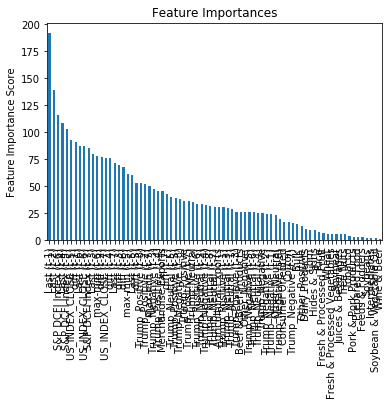

<Figure size 1440x1440 with 0 Axes>


best params 
 {'subsample': 0.6, 'reg_alpha': 0.1, 'n_estimators': 175, 'min_child_weight': 4, 'max_depth': 13, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 0.6}



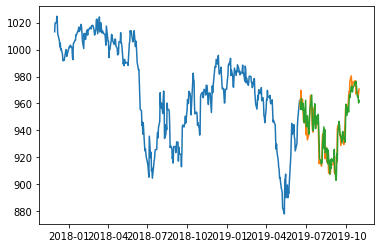


lagging prices by : 8
lagging trump tweets by : 9
lagging tweets by : 2
columns being used:
Index(['Other_Positive', 'Other_Negative', 'Other_Neutral',
       'Agricultural Exports', 'Beef & Beef Products', 'Bulk',
       'Consumer Oriented', 'Corn', 'Cotton', 'Dairy Products',
       'Feeds & Fodders', 'Fresh & Processed Fruit',
       'Fresh & Processed Vegetables', 'Hides & Skins', 'Intermediates',
       'Juices & Beverages', 'Merchandise Exports', 'Pork & Pork Products',
       'Poultry Meat & Products', 'Prepared Food', 'Rice',
       'Soybean & Vegetable Oil', 'Soybeans', 'Soymeal', 'Tobacco',
       'Tree Nuts', 'Wheat', 'Wine & Beer', 'Trump_Positive', 'Trump_Negative',
       'Trump_Neutral', 'Last (t-1)', 'diff (t-1)', 'Last (t-2)', 'diff (t-2)',
       'Last (t-3)', 'diff (t-3)', 'Last (t-4)', 'diff (t-4)', 'Last (t-5)',
       'diff (t-5)', 'Last (t-6)', 'diff (t-6)', 'Last (t-7)', 'diff (t-7)',
       'S&P DCFI Index (t-5)', 'max-min (t-5)', 'US_INDEX_CLOSE (t-5)',
     

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 269 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    9.5s finished


[18:31:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training R-squared:  1.0
Training Explained Variation:  1.0
Training RMSE:  2.1
Training MAE:  1.42  

Test R-squared:  0.84
Test Explained Variation:  0.84
Test RMSE:  8.25
Test MAE:  6.76


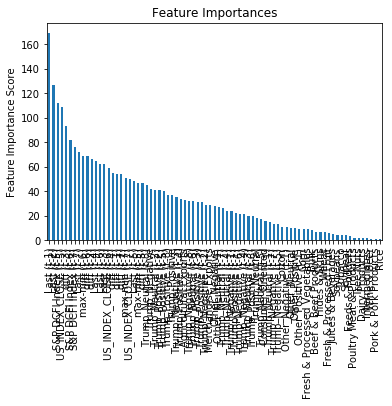

<Figure size 1440x1440 with 0 Axes>


best params 
 {'subsample': 0.7, 'reg_alpha': 1, 'n_estimators': 155, 'min_child_weight': 4, 'max_depth': 16, 'learning_rate': 0.05, 'gamma': 0.4, 'colsample_bytree': 0.7}



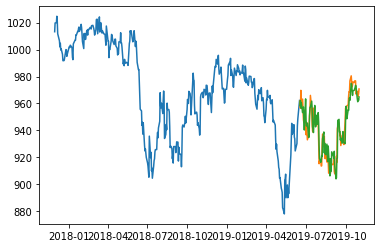


lagging prices by : 8
lagging trump tweets by : 9
lagging tweets by : 3
columns being used:
Index(['Other_Positive', 'Other_Negative', 'Other_Neutral',
       'Agricultural Exports', 'Beef & Beef Products', 'Bulk',
       'Consumer Oriented', 'Corn', 'Cotton', 'Dairy Products',
       'Feeds & Fodders', 'Fresh & Processed Fruit',
       'Fresh & Processed Vegetables', 'Hides & Skins', 'Intermediates',
       'Juices & Beverages', 'Merchandise Exports', 'Pork & Pork Products',
       'Poultry Meat & Products', 'Prepared Food', 'Rice',
       'Soybean & Vegetable Oil', 'Soybeans', 'Soymeal', 'Tobacco',
       'Tree Nuts', 'Wheat', 'Wine & Beer', 'Trump_Positive', 'Trump_Negative',
       'Trump_Neutral', 'Last (t-1)', 'diff (t-1)', 'Last (t-2)', 'diff (t-2)',
       'Last (t-3)', 'diff (t-3)', 'Last (t-4)', 'diff (t-4)', 'Last (t-5)',
       'diff (t-5)', 'Last (t-6)', 'diff (t-6)', 'Last (t-7)', 'diff (t-7)',
       'S&P DCFI Index (t-5)', 'max-min (t-5)', 'US_INDEX_CLOSE (t-5)',
     

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 267 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    9.8s finished


[18:31:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training R-squared:  1.0
Training Explained Variation:  1.0
Training RMSE:  2.07
Training MAE:  1.4  

Test R-squared:  0.85
Test Explained Variation:  0.85
Test RMSE:  7.97
Test MAE:  6.4


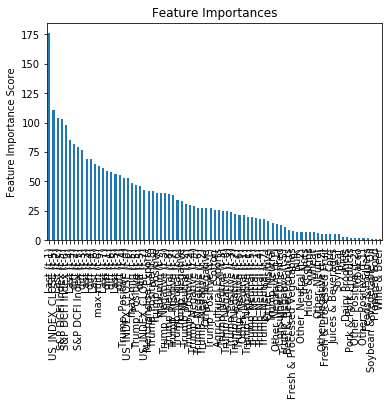

<Figure size 1440x1440 with 0 Axes>


best params 
 {'subsample': 0.7, 'reg_alpha': 1, 'n_estimators': 155, 'min_child_weight': 4, 'max_depth': 16, 'learning_rate': 0.05, 'gamma': 0.4, 'colsample_bytree': 0.7}



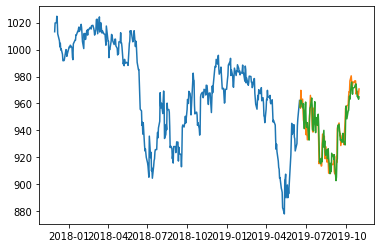


lagging prices by : 8
lagging trump tweets by : 10
lagging tweets by : 1
columns being used:
Index(['Other_Positive', 'Other_Negative', 'Other_Neutral',
       'Agricultural Exports', 'Beef & Beef Products', 'Bulk',
       'Consumer Oriented', 'Corn', 'Cotton', 'Dairy Products',
       'Feeds & Fodders', 'Fresh & Processed Fruit',
       'Fresh & Processed Vegetables', 'Hides & Skins', 'Intermediates',
       'Juices & Beverages', 'Merchandise Exports', 'Pork & Pork Products',
       'Poultry Meat & Products', 'Prepared Food', 'Rice',
       'Soybean & Vegetable Oil', 'Soybeans', 'Soymeal', 'Tobacco',
       'Tree Nuts', 'Wheat', 'Wine & Beer', 'Trump_Positive', 'Trump_Negative',
       'Trump_Neutral', 'Last (t-1)', 'diff (t-1)', 'Last (t-2)', 'diff (t-2)',
       'Last (t-3)', 'diff (t-3)', 'Last (t-4)', 'diff (t-4)', 'Last (t-5)',
       'diff (t-5)', 'Last (t-6)', 'diff (t-6)', 'Last (t-7)', 'diff (t-7)',
       'S&P DCFI Index (t-5)', 'max-min (t-5)', 'US_INDEX_CLOSE (t-5)',
    

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 263 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    9.5s finished


[18:31:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training R-squared:  1.0
Training Explained Variation:  1.0
Training RMSE:  1.73
Training MAE:  1.24  

Test R-squared:  0.81
Test Explained Variation:  0.82
Test RMSE:  8.93
Test MAE:  7.15


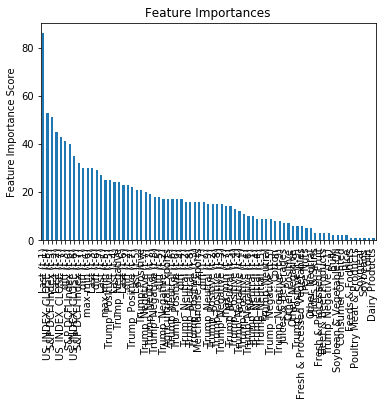

<Figure size 1440x1440 with 0 Axes>


best params 
 {'subsample': 0.8, 'reg_alpha': 1, 'n_estimators': 105, 'min_child_weight': 4, 'max_depth': 6, 'learning_rate': 0.1, 'gamma': 0.2, 'colsample_bytree': 0.8}



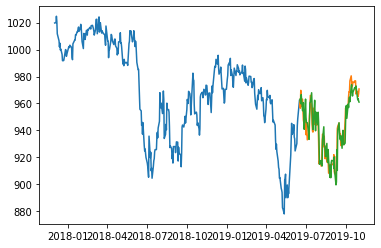


lagging prices by : 8
lagging trump tweets by : 10
lagging tweets by : 2
columns being used:
Index(['Other_Positive', 'Other_Negative', 'Other_Neutral',
       'Agricultural Exports', 'Beef & Beef Products', 'Bulk',
       'Consumer Oriented', 'Corn', 'Cotton', 'Dairy Products',
       'Feeds & Fodders', 'Fresh & Processed Fruit',
       'Fresh & Processed Vegetables', 'Hides & Skins', 'Intermediates',
       'Juices & Beverages', 'Merchandise Exports', 'Pork & Pork Products',
       'Poultry Meat & Products', 'Prepared Food', 'Rice',
       'Soybean & Vegetable Oil', 'Soybeans', 'Soymeal', 'Tobacco',
       'Tree Nuts', 'Wheat', 'Wine & Beer', 'Trump_Positive', 'Trump_Negative',
       'Trump_Neutral', 'Last (t-1)', 'diff (t-1)', 'Last (t-2)', 'diff (t-2)',
       'Last (t-3)', 'diff (t-3)', 'Last (t-4)', 'diff (t-4)', 'Last (t-5)',
       'diff (t-5)', 'Last (t-6)', 'diff (t-6)', 'Last (t-7)', 'diff (t-7)',
       'S&P DCFI Index (t-5)', 'max-min (t-5)', 'US_INDEX_CLOSE (t-5)',
    

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 269 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   10.4s finished


[18:31:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training R-squared:  0.99
Training Explained Variation:  0.99
Training RMSE:  3.17
Training MAE:  2.25  

Test R-squared:  0.83
Test Explained Variation:  0.84
Test RMSE:  8.55
Test MAE:  6.85


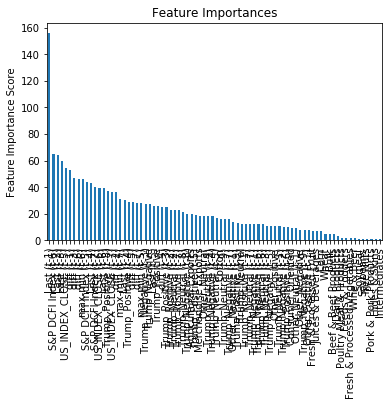

<Figure size 1440x1440 with 0 Axes>


best params 
 {'subsample': 0.6, 'reg_alpha': 0.1, 'n_estimators': 135, 'min_child_weight': 4, 'max_depth': 16, 'learning_rate': 0.05, 'gamma': 0.4, 'colsample_bytree': 0.8}



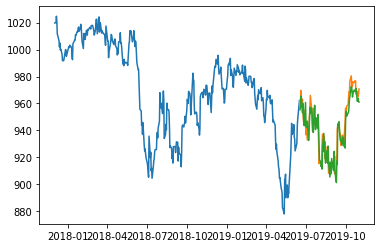


lagging prices by : 8
lagging trump tweets by : 10
lagging tweets by : 3
columns being used:
Index(['Other_Positive', 'Other_Negative', 'Other_Neutral',
       'Agricultural Exports', 'Beef & Beef Products', 'Bulk',
       'Consumer Oriented', 'Corn', 'Cotton', 'Dairy Products',
       'Feeds & Fodders', 'Fresh & Processed Fruit',
       'Fresh & Processed Vegetables', 'Hides & Skins', 'Intermediates',
       'Juices & Beverages', 'Merchandise Exports', 'Pork & Pork Products',
       'Poultry Meat & Products', 'Prepared Food', 'Rice',
       'Soybean & Vegetable Oil', 'Soybeans', 'Soymeal', 'Tobacco',
       'Tree Nuts', 'Wheat', 'Wine & Beer', 'Trump_Positive', 'Trump_Negative',
       'Trump_Neutral', 'Last (t-1)', 'diff (t-1)', 'Last (t-2)', 'diff (t-2)',
       'Last (t-3)', 'diff (t-3)', 'Last (t-4)', 'diff (t-4)', 'Last (t-5)',
       'diff (t-5)', 'Last (t-6)', 'diff (t-6)', 'Last (t-7)', 'diff (t-7)',
       'S&P DCFI Index (t-5)', 'max-min (t-5)', 'US_INDEX_CLOSE (t-5)',
    

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    9.4s finished


[18:32:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training R-squared:  1.0
Training Explained Variation:  1.0
Training RMSE:  0.39
Training MAE:  0.26  

Test R-squared:  0.82
Test Explained Variation:  0.82
Test RMSE:  8.74
Test MAE:  7.07


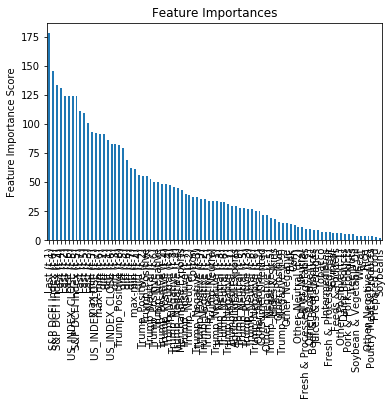

<Figure size 1440x1440 with 0 Axes>


best params 
 {'subsample': 0.7, 'reg_alpha': 1, 'n_estimators': 185, 'min_child_weight': 5, 'max_depth': 18, 'learning_rate': 0.1, 'gamma': 0.4, 'colsample_bytree': 0.7}



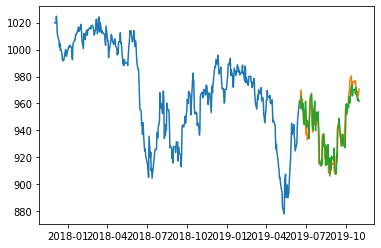


lagging prices by : 8
lagging trump tweets by : 11
lagging tweets by : 1
columns being used:
Index(['Other_Positive', 'Other_Negative', 'Other_Neutral',
       'Agricultural Exports', 'Beef & Beef Products', 'Bulk',
       'Consumer Oriented', 'Corn', 'Cotton', 'Dairy Products',
       'Feeds & Fodders', 'Fresh & Processed Fruit',
       'Fresh & Processed Vegetables', 'Hides & Skins', 'Intermediates',
       'Juices & Beverages', 'Merchandise Exports', 'Pork & Pork Products',
       'Poultry Meat & Products', 'Prepared Food', 'Rice',
       'Soybean & Vegetable Oil', 'Soybeans', 'Soymeal', 'Tobacco',
       'Tree Nuts', 'Wheat', 'Wine & Beer', 'Trump_Positive', 'Trump_Negative',
       'Trump_Neutral', 'Last (t-1)', 'diff (t-1)', 'Last (t-2)', 'diff (t-2)',
       'Last (t-3)', 'diff (t-3)', 'Last (t-4)', 'diff (t-4)', 'Last (t-5)',
       'diff (t-5)', 'Last (t-6)', 'diff (t-6)', 'Last (t-7)', 'diff (t-7)',
       'S&P DCFI Index (t-5)', 'max-min (t-5)', 'US_INDEX_CLOSE (t-5)',
    

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 271 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    9.6s finished


[18:32:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training R-squared:  1.0
Training Explained Variation:  1.0
Training RMSE:  2.2
Training MAE:  1.45  

Test R-squared:  0.85
Test Explained Variation:  0.85
Test RMSE:  8.07
Test MAE:  6.27


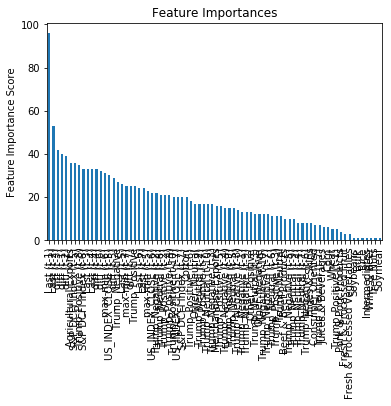

<Figure size 1440x1440 with 0 Axes>


best params 
 {'subsample': 0.6, 'reg_alpha': 1, 'n_estimators': 75, 'min_child_weight': 2, 'max_depth': 12, 'learning_rate': 0.1, 'gamma': 0.3, 'colsample_bytree': 0.9}



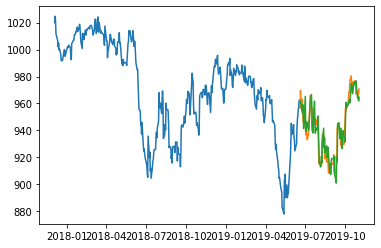


lagging prices by : 8
lagging trump tweets by : 11
lagging tweets by : 2
columns being used:
Index(['Other_Positive', 'Other_Negative', 'Other_Neutral',
       'Agricultural Exports', 'Beef & Beef Products', 'Bulk',
       'Consumer Oriented', 'Corn', 'Cotton', 'Dairy Products',
       'Feeds & Fodders', 'Fresh & Processed Fruit',
       'Fresh & Processed Vegetables', 'Hides & Skins', 'Intermediates',
       'Juices & Beverages', 'Merchandise Exports', 'Pork & Pork Products',
       'Poultry Meat & Products', 'Prepared Food', 'Rice',
       'Soybean & Vegetable Oil', 'Soybeans', 'Soymeal', 'Tobacco',
       'Tree Nuts', 'Wheat', 'Wine & Beer', 'Trump_Positive', 'Trump_Negative',
       'Trump_Neutral', 'Last (t-1)', 'diff (t-1)', 'Last (t-2)', 'diff (t-2)',
       'Last (t-3)', 'diff (t-3)', 'Last (t-4)', 'diff (t-4)', 'Last (t-5)',
       'diff (t-5)', 'Last (t-6)', 'diff (t-6)', 'Last (t-7)', 'diff (t-7)',
       'S&P DCFI Index (t-5)', 'max-min (t-5)', 'US_INDEX_CLOSE (t-5)',
    

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    9.5s finished


[18:32:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training R-squared:  1.0
Training Explained Variation:  1.0
Training RMSE:  0.53
Training MAE:  0.3  

Test R-squared:  0.84
Test Explained Variation:  0.84
Test RMSE:  8.18
Test MAE:  6.82


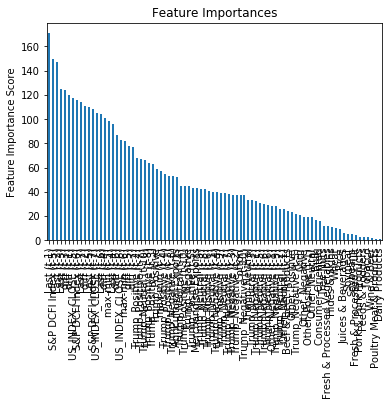

<Figure size 1440x1440 with 0 Axes>


best params 
 {'subsample': 0.7, 'reg_alpha': 1, 'n_estimators': 125, 'min_child_weight': 3, 'max_depth': 17, 'learning_rate': 0.1, 'gamma': 0.0, 'colsample_bytree': 0.8}



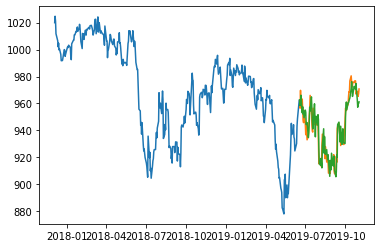


lagging prices by : 8
lagging trump tweets by : 11
lagging tweets by : 3
columns being used:
Index(['Other_Positive', 'Other_Negative', 'Other_Neutral',
       'Agricultural Exports', 'Beef & Beef Products', 'Bulk',
       'Consumer Oriented', 'Corn', 'Cotton', 'Dairy Products',
       'Feeds & Fodders', 'Fresh & Processed Fruit',
       'Fresh & Processed Vegetables', 'Hides & Skins', 'Intermediates',
       'Juices & Beverages', 'Merchandise Exports', 'Pork & Pork Products',
       'Poultry Meat & Products', 'Prepared Food', 'Rice',
       'Soybean & Vegetable Oil', 'Soybeans', 'Soymeal', 'Tobacco',
       'Tree Nuts', 'Wheat', 'Wine & Beer', 'Trump_Positive', 'Trump_Negative',
       'Trump_Neutral', 'Last (t-1)', 'diff (t-1)', 'Last (t-2)', 'diff (t-2)',
       'Last (t-3)', 'diff (t-3)', 'Last (t-4)', 'diff (t-4)', 'Last (t-5)',
       'diff (t-5)', 'Last (t-6)', 'diff (t-6)', 'Last (t-7)', 'diff (t-7)',
       'S&P DCFI Index (t-5)', 'max-min (t-5)', 'US_INDEX_CLOSE (t-5)',
    

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 266 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   10.3s finished


[18:32:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training R-squared:  1.0
Training Explained Variation:  1.0
Training RMSE:  1.28
Training MAE:  0.77  

Test R-squared:  0.85
Test Explained Variation:  0.85
Test RMSE:  8.13
Test MAE:  6.62


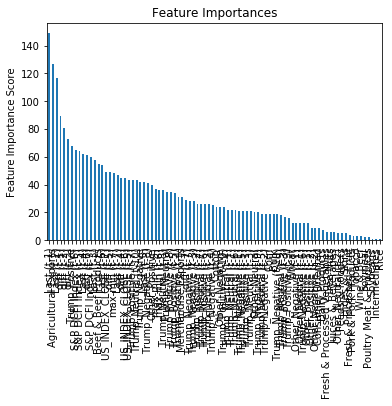

<Figure size 1440x1440 with 0 Axes>


best params 
 {'subsample': 0.6, 'reg_alpha': 1e-05, 'n_estimators': 85, 'min_child_weight': 1, 'max_depth': 19, 'learning_rate': 0.1, 'gamma': 0.4, 'colsample_bytree': 0.7}



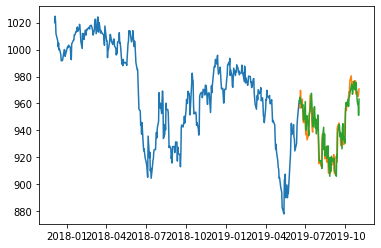


lagging prices by : 9
lagging trump tweets by : 6
lagging tweets by : 1
columns being used:
Index(['Other_Positive', 'Other_Negative', 'Other_Neutral',
       'Agricultural Exports', 'Beef & Beef Products', 'Bulk',
       'Consumer Oriented', 'Corn', 'Cotton', 'Dairy Products',
       'Feeds & Fodders', 'Fresh & Processed Fruit',
       'Fresh & Processed Vegetables', 'Hides & Skins', 'Intermediates',
       'Juices & Beverages', 'Merchandise Exports', 'Pork & Pork Products',
       'Poultry Meat & Products', 'Prepared Food', 'Rice',
       'Soybean & Vegetable Oil', 'Soybeans', 'Soymeal', 'Tobacco',
       'Tree Nuts', 'Wheat', 'Wine & Beer', 'Trump_Positive', 'Trump_Negative',
       'Trump_Neutral', 'Last (t-1)', 'diff (t-1)', 'Last (t-2)', 'diff (t-2)',
       'Last (t-3)', 'diff (t-3)', 'Last (t-4)', 'diff (t-4)', 'Last (t-5)',
       'diff (t-5)', 'Last (t-6)', 'diff (t-6)', 'Last (t-7)', 'diff (t-7)',
       'Last (t-8)', 'diff (t-8)', 'S&P DCFI Index (t-5)', 'max-min (t-5)',
 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    9.7s finished


[18:33:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training R-squared:  1.0
Training Explained Variation:  1.0
Training RMSE:  1.77
Training MAE:  1.24  

Test R-squared:  0.84
Test Explained Variation:  0.85
Test RMSE:  8.16
Test MAE:  6.52


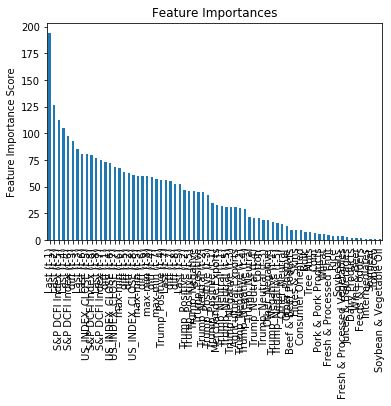

<Figure size 1440x1440 with 0 Axes>


best params 
 {'subsample': 0.6, 'reg_alpha': 1, 'n_estimators': 195, 'min_child_weight': 4, 'max_depth': 9, 'learning_rate': 0.05, 'gamma': 0.3, 'colsample_bytree': 0.9}



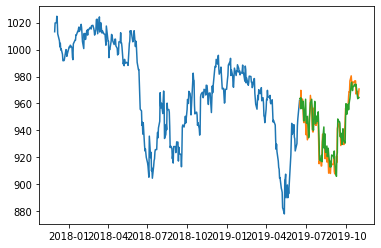


lagging prices by : 9
lagging trump tweets by : 6
lagging tweets by : 2
columns being used:
Index(['Other_Positive', 'Other_Negative', 'Other_Neutral',
       'Agricultural Exports', 'Beef & Beef Products', 'Bulk',
       'Consumer Oriented', 'Corn', 'Cotton', 'Dairy Products',
       'Feeds & Fodders', 'Fresh & Processed Fruit',
       'Fresh & Processed Vegetables', 'Hides & Skins', 'Intermediates',
       'Juices & Beverages', 'Merchandise Exports', 'Pork & Pork Products',
       'Poultry Meat & Products', 'Prepared Food', 'Rice',
       'Soybean & Vegetable Oil', 'Soybeans', 'Soymeal', 'Tobacco',
       'Tree Nuts', 'Wheat', 'Wine & Beer', 'Trump_Positive', 'Trump_Negative',
       'Trump_Neutral', 'Last (t-1)', 'diff (t-1)', 'Last (t-2)', 'diff (t-2)',
       'Last (t-3)', 'diff (t-3)', 'Last (t-4)', 'diff (t-4)', 'Last (t-5)',
       'diff (t-5)', 'Last (t-6)', 'diff (t-6)', 'Last (t-7)', 'diff (t-7)',
       'Last (t-8)', 'diff (t-8)', 'S&P DCFI Index (t-5)', 'max-min (t-5)',
 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    9.6s finished


[18:33:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training R-squared:  1.0
Training Explained Variation:  1.0
Training RMSE:  1.74
Training MAE:  1.22  

Test R-squared:  0.84
Test Explained Variation:  0.85
Test RMSE:  8.17
Test MAE:  6.53


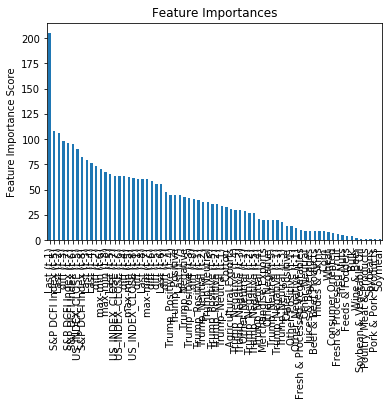

<Figure size 1440x1440 with 0 Axes>


best params 
 {'subsample': 0.6, 'reg_alpha': 1, 'n_estimators': 195, 'min_child_weight': 4, 'max_depth': 9, 'learning_rate': 0.05, 'gamma': 0.3, 'colsample_bytree': 0.9}



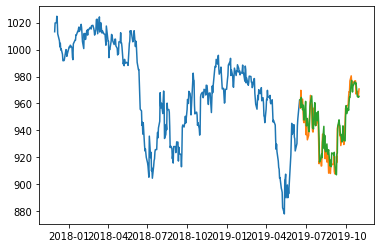


lagging prices by : 9
lagging trump tweets by : 6
lagging tweets by : 3
columns being used:
Index(['Other_Positive', 'Other_Negative', 'Other_Neutral',
       'Agricultural Exports', 'Beef & Beef Products', 'Bulk',
       'Consumer Oriented', 'Corn', 'Cotton', 'Dairy Products',
       'Feeds & Fodders', 'Fresh & Processed Fruit',
       'Fresh & Processed Vegetables', 'Hides & Skins', 'Intermediates',
       'Juices & Beverages', 'Merchandise Exports', 'Pork & Pork Products',
       'Poultry Meat & Products', 'Prepared Food', 'Rice',
       'Soybean & Vegetable Oil', 'Soybeans', 'Soymeal', 'Tobacco',
       'Tree Nuts', 'Wheat', 'Wine & Beer', 'Trump_Positive', 'Trump_Negative',
       'Trump_Neutral', 'Last (t-1)', 'diff (t-1)', 'Last (t-2)', 'diff (t-2)',
       'Last (t-3)', 'diff (t-3)', 'Last (t-4)', 'diff (t-4)', 'Last (t-5)',
       'diff (t-5)', 'Last (t-6)', 'diff (t-6)', 'Last (t-7)', 'diff (t-7)',
       'Last (t-8)', 'diff (t-8)', 'S&P DCFI Index (t-5)', 'max-min (t-5)',
 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 269 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    9.8s finished


[18:33:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training R-squared:  1.0
Training Explained Variation:  1.0
Training RMSE:  2.09
Training MAE:  1.41  

Test R-squared:  0.85
Test Explained Variation:  0.85
Test RMSE:  8.03
Test MAE:  6.77


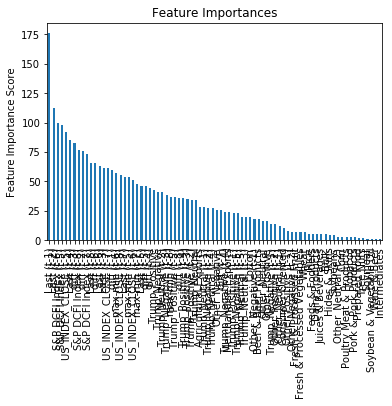

<Figure size 1440x1440 with 0 Axes>


best params 
 {'subsample': 0.7, 'reg_alpha': 1, 'n_estimators': 155, 'min_child_weight': 4, 'max_depth': 16, 'learning_rate': 0.05, 'gamma': 0.4, 'colsample_bytree': 0.7}



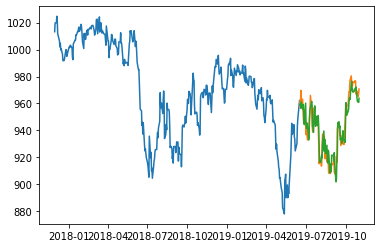


lagging prices by : 9
lagging trump tweets by : 7
lagging tweets by : 1
columns being used:
Index(['Other_Positive', 'Other_Negative', 'Other_Neutral',
       'Agricultural Exports', 'Beef & Beef Products', 'Bulk',
       'Consumer Oriented', 'Corn', 'Cotton', 'Dairy Products',
       'Feeds & Fodders', 'Fresh & Processed Fruit',
       'Fresh & Processed Vegetables', 'Hides & Skins', 'Intermediates',
       'Juices & Beverages', 'Merchandise Exports', 'Pork & Pork Products',
       'Poultry Meat & Products', 'Prepared Food', 'Rice',
       'Soybean & Vegetable Oil', 'Soybeans', 'Soymeal', 'Tobacco',
       'Tree Nuts', 'Wheat', 'Wine & Beer', 'Trump_Positive', 'Trump_Negative',
       'Trump_Neutral', 'Last (t-1)', 'diff (t-1)', 'Last (t-2)', 'diff (t-2)',
       'Last (t-3)', 'diff (t-3)', 'Last (t-4)', 'diff (t-4)', 'Last (t-5)',
       'diff (t-5)', 'Last (t-6)', 'diff (t-6)', 'Last (t-7)', 'diff (t-7)',
       'Last (t-8)', 'diff (t-8)', 'S&P DCFI Index (t-5)', 'max-min (t-5)',
 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 268 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   10.0s finished


[18:33:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training R-squared:  1.0
Training Explained Variation:  1.0
Training RMSE:  1.7
Training MAE:  1.19  

Test R-squared:  0.84
Test Explained Variation:  0.85
Test RMSE:  8.21
Test MAE:  6.62


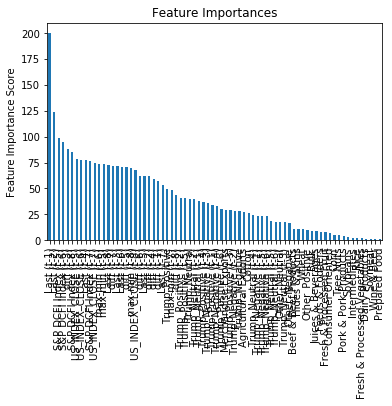

<Figure size 1440x1440 with 0 Axes>


best params 
 {'subsample': 0.6, 'reg_alpha': 1, 'n_estimators': 195, 'min_child_weight': 4, 'max_depth': 9, 'learning_rate': 0.05, 'gamma': 0.3, 'colsample_bytree': 0.9}



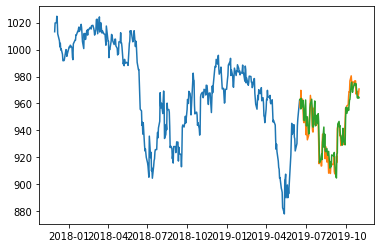


lagging prices by : 9
lagging trump tweets by : 7
lagging tweets by : 2
columns being used:
Index(['Other_Positive', 'Other_Negative', 'Other_Neutral',
       'Agricultural Exports', 'Beef & Beef Products', 'Bulk',
       'Consumer Oriented', 'Corn', 'Cotton', 'Dairy Products',
       'Feeds & Fodders', 'Fresh & Processed Fruit',
       'Fresh & Processed Vegetables', 'Hides & Skins', 'Intermediates',
       'Juices & Beverages', 'Merchandise Exports', 'Pork & Pork Products',
       'Poultry Meat & Products', 'Prepared Food', 'Rice',
       'Soybean & Vegetable Oil', 'Soybeans', 'Soymeal', 'Tobacco',
       'Tree Nuts', 'Wheat', 'Wine & Beer', 'Trump_Positive', 'Trump_Negative',
       'Trump_Neutral', 'Last (t-1)', 'diff (t-1)', 'Last (t-2)', 'diff (t-2)',
       'Last (t-3)', 'diff (t-3)', 'Last (t-4)', 'diff (t-4)', 'Last (t-5)',
       'diff (t-5)', 'Last (t-6)', 'diff (t-6)', 'Last (t-7)', 'diff (t-7)',
       'Last (t-8)', 'diff (t-8)', 'S&P DCFI Index (t-5)', 'max-min (t-5)',
 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   10.3s finished


[18:33:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training R-squared:  1.0
Training Explained Variation:  1.0
Training RMSE:  1.73
Training MAE:  1.22  

Test R-squared:  0.84
Test Explained Variation:  0.84
Test RMSE:  8.27
Test MAE:  6.74


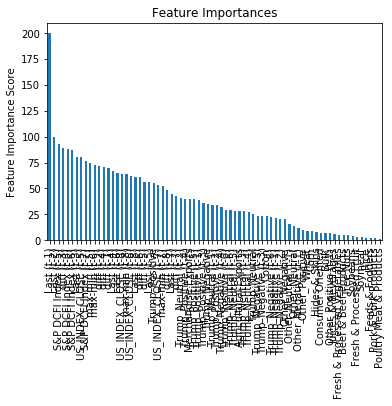

<Figure size 1440x1440 with 0 Axes>


best params 
 {'subsample': 0.6, 'reg_alpha': 1, 'n_estimators': 195, 'min_child_weight': 4, 'max_depth': 9, 'learning_rate': 0.05, 'gamma': 0.3, 'colsample_bytree': 0.9}



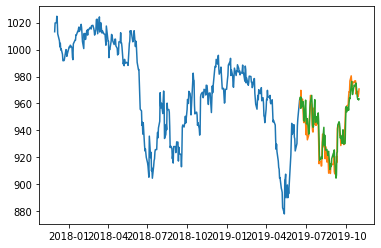


lagging prices by : 9
lagging trump tweets by : 7
lagging tweets by : 3
columns being used:
Index(['Other_Positive', 'Other_Negative', 'Other_Neutral',
       'Agricultural Exports', 'Beef & Beef Products', 'Bulk',
       'Consumer Oriented', 'Corn', 'Cotton', 'Dairy Products',
       'Feeds & Fodders', 'Fresh & Processed Fruit',
       'Fresh & Processed Vegetables', 'Hides & Skins', 'Intermediates',
       'Juices & Beverages', 'Merchandise Exports', 'Pork & Pork Products',
       'Poultry Meat & Products', 'Prepared Food', 'Rice',
       'Soybean & Vegetable Oil', 'Soybeans', 'Soymeal', 'Tobacco',
       'Tree Nuts', 'Wheat', 'Wine & Beer', 'Trump_Positive', 'Trump_Negative',
       'Trump_Neutral', 'Last (t-1)', 'diff (t-1)', 'Last (t-2)', 'diff (t-2)',
       'Last (t-3)', 'diff (t-3)', 'Last (t-4)', 'diff (t-4)', 'Last (t-5)',
       'diff (t-5)', 'Last (t-6)', 'diff (t-6)', 'Last (t-7)', 'diff (t-7)',
       'Last (t-8)', 'diff (t-8)', 'S&P DCFI Index (t-5)', 'max-min (t-5)',
 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    9.6s finished


[18:34:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training R-squared:  1.0
Training Explained Variation:  1.0
Training RMSE:  2.01
Training MAE:  1.33  

Test R-squared:  0.85
Test Explained Variation:  0.85
Test RMSE:  7.94
Test MAE:  6.55


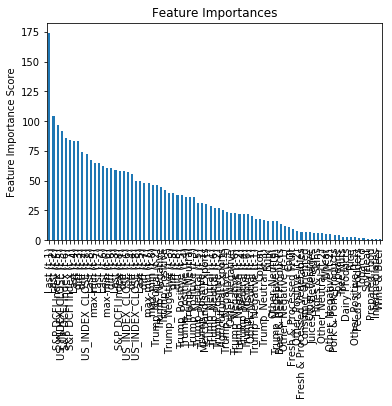

<Figure size 1440x1440 with 0 Axes>


best params 
 {'subsample': 0.7, 'reg_alpha': 1, 'n_estimators': 155, 'min_child_weight': 4, 'max_depth': 16, 'learning_rate': 0.05, 'gamma': 0.4, 'colsample_bytree': 0.7}



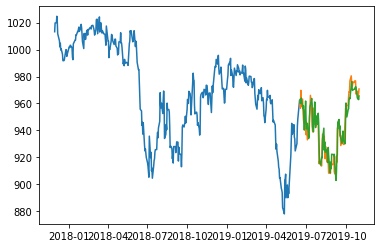


lagging prices by : 9
lagging trump tweets by : 8
lagging tweets by : 1
columns being used:
Index(['Other_Positive', 'Other_Negative', 'Other_Neutral',
       'Agricultural Exports', 'Beef & Beef Products', 'Bulk',
       'Consumer Oriented', 'Corn', 'Cotton', 'Dairy Products',
       'Feeds & Fodders', 'Fresh & Processed Fruit',
       'Fresh & Processed Vegetables', 'Hides & Skins', 'Intermediates',
       'Juices & Beverages', 'Merchandise Exports', 'Pork & Pork Products',
       'Poultry Meat & Products', 'Prepared Food', 'Rice',
       'Soybean & Vegetable Oil', 'Soybeans', 'Soymeal', 'Tobacco',
       'Tree Nuts', 'Wheat', 'Wine & Beer', 'Trump_Positive', 'Trump_Negative',
       'Trump_Neutral', 'Last (t-1)', 'diff (t-1)', 'Last (t-2)', 'diff (t-2)',
       'Last (t-3)', 'diff (t-3)', 'Last (t-4)', 'diff (t-4)', 'Last (t-5)',
       'diff (t-5)', 'Last (t-6)', 'diff (t-6)', 'Last (t-7)', 'diff (t-7)',
       'Last (t-8)', 'diff (t-8)', 'S&P DCFI Index (t-5)', 'max-min (t-5)',
 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    9.9s finished


[18:34:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training R-squared:  1.0
Training Explained Variation:  1.0
Training RMSE:  1.78
Training MAE:  1.21  

Test R-squared:  0.85
Test Explained Variation:  0.85
Test RMSE:  8.01
Test MAE:  6.45


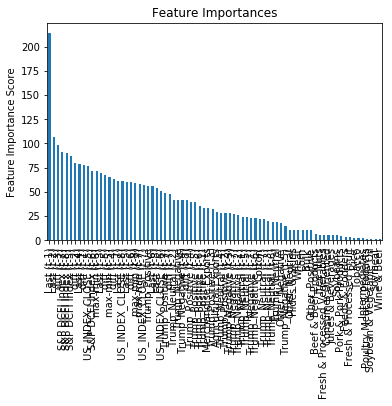

<Figure size 1440x1440 with 0 Axes>


best params 
 {'subsample': 0.6, 'reg_alpha': 1, 'n_estimators': 195, 'min_child_weight': 4, 'max_depth': 9, 'learning_rate': 0.05, 'gamma': 0.3, 'colsample_bytree': 0.9}



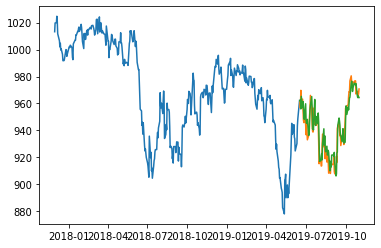


lagging prices by : 9
lagging trump tweets by : 8
lagging tweets by : 2
columns being used:
Index(['Other_Positive', 'Other_Negative', 'Other_Neutral',
       'Agricultural Exports', 'Beef & Beef Products', 'Bulk',
       'Consumer Oriented', 'Corn', 'Cotton', 'Dairy Products',
       'Feeds & Fodders', 'Fresh & Processed Fruit',
       'Fresh & Processed Vegetables', 'Hides & Skins', 'Intermediates',
       'Juices & Beverages', 'Merchandise Exports', 'Pork & Pork Products',
       'Poultry Meat & Products', 'Prepared Food', 'Rice',
       'Soybean & Vegetable Oil', 'Soybeans', 'Soymeal', 'Tobacco',
       'Tree Nuts', 'Wheat', 'Wine & Beer', 'Trump_Positive', 'Trump_Negative',
       'Trump_Neutral', 'Last (t-1)', 'diff (t-1)', 'Last (t-2)', 'diff (t-2)',
       'Last (t-3)', 'diff (t-3)', 'Last (t-4)', 'diff (t-4)', 'Last (t-5)',
       'diff (t-5)', 'Last (t-6)', 'diff (t-6)', 'Last (t-7)', 'diff (t-7)',
       'Last (t-8)', 'diff (t-8)', 'S&P DCFI Index (t-5)', 'max-min (t-5)',
 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 270 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   10.0s finished


[18:34:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training R-squared:  1.0
Training Explained Variation:  1.0
Training RMSE:  1.82
Training MAE:  1.21  

Test R-squared:  0.85
Test Explained Variation:  0.85
Test RMSE:  7.96
Test MAE:  6.34


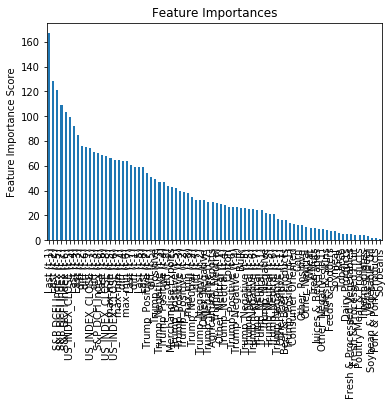

<Figure size 1440x1440 with 0 Axes>


best params 
 {'subsample': 0.6, 'reg_alpha': 0.1, 'n_estimators': 175, 'min_child_weight': 4, 'max_depth': 13, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 0.6}



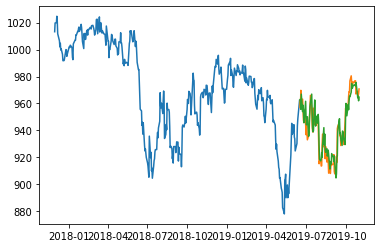


lagging prices by : 9
lagging trump tweets by : 8
lagging tweets by : 3
columns being used:
Index(['Other_Positive', 'Other_Negative', 'Other_Neutral',
       'Agricultural Exports', 'Beef & Beef Products', 'Bulk',
       'Consumer Oriented', 'Corn', 'Cotton', 'Dairy Products',
       'Feeds & Fodders', 'Fresh & Processed Fruit',
       'Fresh & Processed Vegetables', 'Hides & Skins', 'Intermediates',
       'Juices & Beverages', 'Merchandise Exports', 'Pork & Pork Products',
       'Poultry Meat & Products', 'Prepared Food', 'Rice',
       'Soybean & Vegetable Oil', 'Soybeans', 'Soymeal', 'Tobacco',
       'Tree Nuts', 'Wheat', 'Wine & Beer', 'Trump_Positive', 'Trump_Negative',
       'Trump_Neutral', 'Last (t-1)', 'diff (t-1)', 'Last (t-2)', 'diff (t-2)',
       'Last (t-3)', 'diff (t-3)', 'Last (t-4)', 'diff (t-4)', 'Last (t-5)',
       'diff (t-5)', 'Last (t-6)', 'diff (t-6)', 'Last (t-7)', 'diff (t-7)',
       'Last (t-8)', 'diff (t-8)', 'S&P DCFI Index (t-5)', 'max-min (t-5)',
 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 258 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   10.5s finished


[18:34:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training R-squared:  1.0
Training Explained Variation:  1.0
Training RMSE:  1.83
Training MAE:  1.25  

Test R-squared:  0.84
Test Explained Variation:  0.84
Test RMSE:  8.28
Test MAE:  6.7


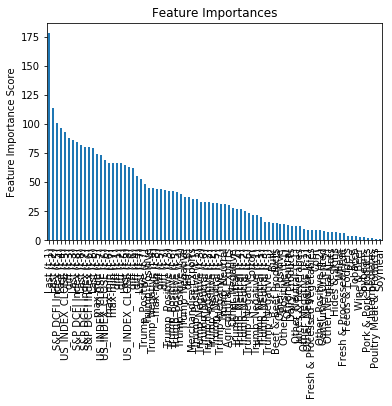

<Figure size 1440x1440 with 0 Axes>


best params 
 {'subsample': 0.6, 'reg_alpha': 0.1, 'n_estimators': 175, 'min_child_weight': 4, 'max_depth': 13, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 0.6}



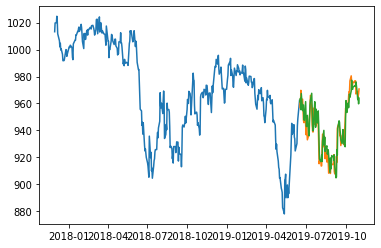


lagging prices by : 9
lagging trump tweets by : 9
lagging tweets by : 1
columns being used:
Index(['Other_Positive', 'Other_Negative', 'Other_Neutral',
       'Agricultural Exports', 'Beef & Beef Products', 'Bulk',
       'Consumer Oriented', 'Corn', 'Cotton', 'Dairy Products',
       'Feeds & Fodders', 'Fresh & Processed Fruit',
       'Fresh & Processed Vegetables', 'Hides & Skins', 'Intermediates',
       'Juices & Beverages', 'Merchandise Exports', 'Pork & Pork Products',
       'Poultry Meat & Products', 'Prepared Food', 'Rice',
       'Soybean & Vegetable Oil', 'Soybeans', 'Soymeal', 'Tobacco',
       'Tree Nuts', 'Wheat', 'Wine & Beer', 'Trump_Positive', 'Trump_Negative',
       'Trump_Neutral', 'Last (t-1)', 'diff (t-1)', 'Last (t-2)', 'diff (t-2)',
       'Last (t-3)', 'diff (t-3)', 'Last (t-4)', 'diff (t-4)', 'Last (t-5)',
       'diff (t-5)', 'Last (t-6)', 'diff (t-6)', 'Last (t-7)', 'diff (t-7)',
       'Last (t-8)', 'diff (t-8)', 'S&P DCFI Index (t-5)', 'max-min (t-5)',
 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   10.0s finished


[18:35:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training R-squared:  1.0
Training Explained Variation:  1.0
Training RMSE:  1.67
Training MAE:  1.17  

Test R-squared:  0.86
Test Explained Variation:  0.86
Test RMSE:  7.88
Test MAE:  6.29


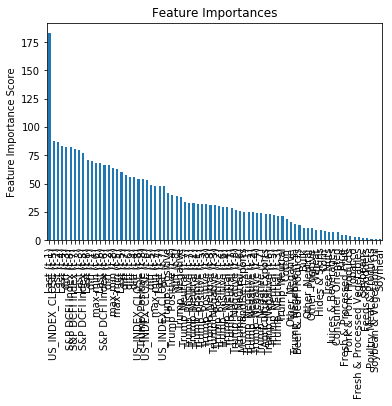

<Figure size 1440x1440 with 0 Axes>


best params 
 {'subsample': 0.6, 'reg_alpha': 1, 'n_estimators': 195, 'min_child_weight': 4, 'max_depth': 9, 'learning_rate': 0.05, 'gamma': 0.3, 'colsample_bytree': 0.9}



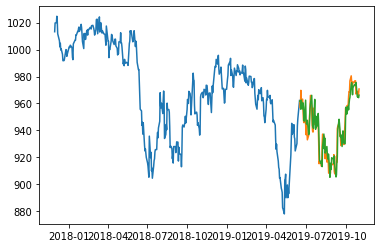


lagging prices by : 9
lagging trump tweets by : 9
lagging tweets by : 2
columns being used:
Index(['Other_Positive', 'Other_Negative', 'Other_Neutral',
       'Agricultural Exports', 'Beef & Beef Products', 'Bulk',
       'Consumer Oriented', 'Corn', 'Cotton', 'Dairy Products',
       'Feeds & Fodders', 'Fresh & Processed Fruit',
       'Fresh & Processed Vegetables', 'Hides & Skins', 'Intermediates',
       'Juices & Beverages', 'Merchandise Exports', 'Pork & Pork Products',
       'Poultry Meat & Products', 'Prepared Food', 'Rice',
       'Soybean & Vegetable Oil', 'Soybeans', 'Soymeal', 'Tobacco',
       'Tree Nuts', 'Wheat', 'Wine & Beer', 'Trump_Positive', 'Trump_Negative',
       'Trump_Neutral', 'Last (t-1)', 'diff (t-1)', 'Last (t-2)', 'diff (t-2)',
       'Last (t-3)', 'diff (t-3)', 'Last (t-4)', 'diff (t-4)', 'Last (t-5)',
       'diff (t-5)', 'Last (t-6)', 'diff (t-6)', 'Last (t-7)', 'diff (t-7)',
       'Last (t-8)', 'diff (t-8)', 'S&P DCFI Index (t-5)', 'max-min (t-5)',
 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 268 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    9.6s finished


[18:35:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training R-squared:  1.0
Training Explained Variation:  1.0
Training RMSE:  0.83
Training MAE:  0.58  

Test R-squared:  0.81
Test Explained Variation:  0.81
Test RMSE:  9.02
Test MAE:  7.3


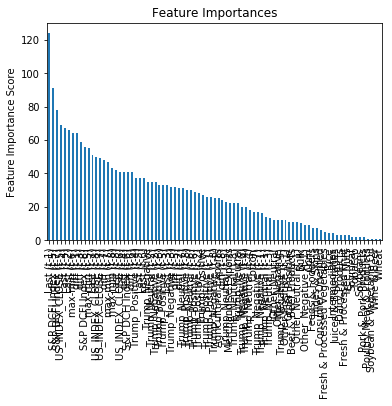

<Figure size 1440x1440 with 0 Axes>


best params 
 {'subsample': 0.8, 'reg_alpha': 1, 'n_estimators': 145, 'min_child_weight': 3, 'max_depth': 6, 'learning_rate': 0.1, 'gamma': 0.2, 'colsample_bytree': 0.7}



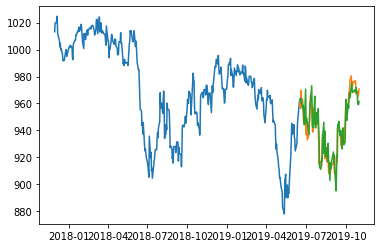


lagging prices by : 9
lagging trump tweets by : 9
lagging tweets by : 3
columns being used:
Index(['Other_Positive', 'Other_Negative', 'Other_Neutral',
       'Agricultural Exports', 'Beef & Beef Products', 'Bulk',
       'Consumer Oriented', 'Corn', 'Cotton', 'Dairy Products',
       'Feeds & Fodders', 'Fresh & Processed Fruit',
       'Fresh & Processed Vegetables', 'Hides & Skins', 'Intermediates',
       'Juices & Beverages', 'Merchandise Exports', 'Pork & Pork Products',
       'Poultry Meat & Products', 'Prepared Food', 'Rice',
       'Soybean & Vegetable Oil', 'Soybeans', 'Soymeal', 'Tobacco',
       'Tree Nuts', 'Wheat', 'Wine & Beer', 'Trump_Positive', 'Trump_Negative',
       'Trump_Neutral', 'Last (t-1)', 'diff (t-1)', 'Last (t-2)', 'diff (t-2)',
       'Last (t-3)', 'diff (t-3)', 'Last (t-4)', 'diff (t-4)', 'Last (t-5)',
       'diff (t-5)', 'Last (t-6)', 'diff (t-6)', 'Last (t-7)', 'diff (t-7)',
       'Last (t-8)', 'diff (t-8)', 'S&P DCFI Index (t-5)', 'max-min (t-5)',
 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    9.9s finished


[18:35:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training R-squared:  1.0
Training Explained Variation:  1.0
Training RMSE:  0.41
Training MAE:  0.24  

Test R-squared:  0.83
Test Explained Variation:  0.83
Test RMSE:  8.5
Test MAE:  6.89


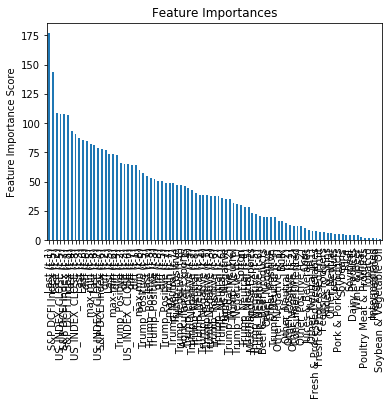

<Figure size 1440x1440 with 0 Axes>


best params 
 {'subsample': 0.8, 'reg_alpha': 1, 'n_estimators': 125, 'min_child_weight': 3, 'max_depth': 12, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.7}



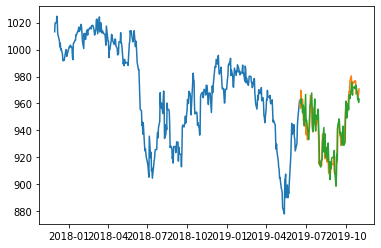


lagging prices by : 9
lagging trump tweets by : 10
lagging tweets by : 1
columns being used:
Index(['Other_Positive', 'Other_Negative', 'Other_Neutral',
       'Agricultural Exports', 'Beef & Beef Products', 'Bulk',
       'Consumer Oriented', 'Corn', 'Cotton', 'Dairy Products',
       'Feeds & Fodders', 'Fresh & Processed Fruit',
       'Fresh & Processed Vegetables', 'Hides & Skins', 'Intermediates',
       'Juices & Beverages', 'Merchandise Exports', 'Pork & Pork Products',
       'Poultry Meat & Products', 'Prepared Food', 'Rice',
       'Soybean & Vegetable Oil', 'Soybeans', 'Soymeal', 'Tobacco',
       'Tree Nuts', 'Wheat', 'Wine & Beer', 'Trump_Positive', 'Trump_Negative',
       'Trump_Neutral', 'Last (t-1)', 'diff (t-1)', 'Last (t-2)', 'diff (t-2)',
       'Last (t-3)', 'diff (t-3)', 'Last (t-4)', 'diff (t-4)', 'Last (t-5)',
       'diff (t-5)', 'Last (t-6)', 'diff (t-6)', 'Last (t-7)', 'diff (t-7)',
       'Last (t-8)', 'diff (t-8)', 'S&P DCFI Index (t-5)', 'max-min (t-5)',


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 271 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   10.0s finished


[18:35:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training R-squared:  1.0
Training Explained Variation:  1.0
Training RMSE:  2.04
Training MAE:  1.37  

Test R-squared:  0.84
Test Explained Variation:  0.84
Test RMSE:  8.36
Test MAE:  6.85


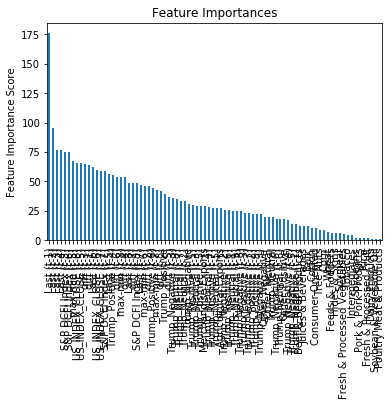

<Figure size 1440x1440 with 0 Axes>


best params 
 {'subsample': 0.7, 'reg_alpha': 1, 'n_estimators': 155, 'min_child_weight': 4, 'max_depth': 16, 'learning_rate': 0.05, 'gamma': 0.4, 'colsample_bytree': 0.7}



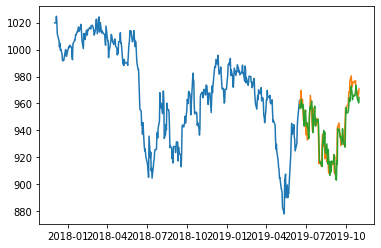


lagging prices by : 9
lagging trump tweets by : 10
lagging tweets by : 2
columns being used:
Index(['Other_Positive', 'Other_Negative', 'Other_Neutral',
       'Agricultural Exports', 'Beef & Beef Products', 'Bulk',
       'Consumer Oriented', 'Corn', 'Cotton', 'Dairy Products',
       'Feeds & Fodders', 'Fresh & Processed Fruit',
       'Fresh & Processed Vegetables', 'Hides & Skins', 'Intermediates',
       'Juices & Beverages', 'Merchandise Exports', 'Pork & Pork Products',
       'Poultry Meat & Products', 'Prepared Food', 'Rice',
       'Soybean & Vegetable Oil', 'Soybeans', 'Soymeal', 'Tobacco',
       'Tree Nuts', 'Wheat', 'Wine & Beer', 'Trump_Positive', 'Trump_Negative',
       'Trump_Neutral', 'Last (t-1)', 'diff (t-1)', 'Last (t-2)', 'diff (t-2)',
       'Last (t-3)', 'diff (t-3)', 'Last (t-4)', 'diff (t-4)', 'Last (t-5)',
       'diff (t-5)', 'Last (t-6)', 'diff (t-6)', 'Last (t-7)', 'diff (t-7)',
       'Last (t-8)', 'diff (t-8)', 'S&P DCFI Index (t-5)', 'max-min (t-5)',


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 254 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   10.0s finished


[18:36:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training R-squared:  1.0
Training Explained Variation:  1.0
Training RMSE:  0.54
Training MAE:  0.29  

Test R-squared:  0.81
Test Explained Variation:  0.81
Test RMSE:  9.01
Test MAE:  7.35


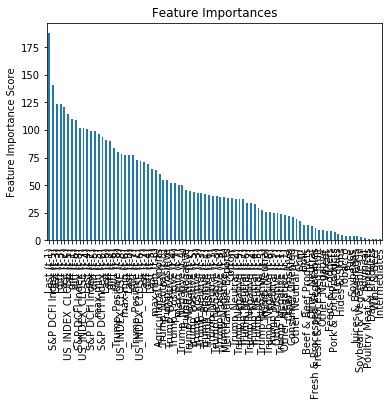

<Figure size 1440x1440 with 0 Axes>


best params 
 {'subsample': 0.7, 'reg_alpha': 1, 'n_estimators': 125, 'min_child_weight': 3, 'max_depth': 17, 'learning_rate': 0.1, 'gamma': 0.0, 'colsample_bytree': 0.8}



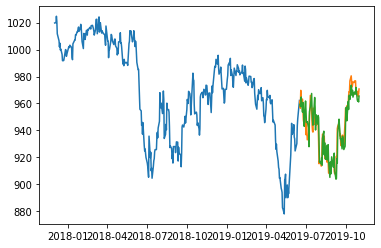


lagging prices by : 9
lagging trump tweets by : 10
lagging tweets by : 3
columns being used:
Index(['Other_Positive', 'Other_Negative', 'Other_Neutral',
       'Agricultural Exports', 'Beef & Beef Products', 'Bulk',
       'Consumer Oriented', 'Corn', 'Cotton', 'Dairy Products',
       'Feeds & Fodders', 'Fresh & Processed Fruit',
       'Fresh & Processed Vegetables', 'Hides & Skins', 'Intermediates',
       'Juices & Beverages', 'Merchandise Exports', 'Pork & Pork Products',
       'Poultry Meat & Products', 'Prepared Food', 'Rice',
       'Soybean & Vegetable Oil', 'Soybeans', 'Soymeal', 'Tobacco',
       'Tree Nuts', 'Wheat', 'Wine & Beer', 'Trump_Positive', 'Trump_Negative',
       'Trump_Neutral', 'Last (t-1)', 'diff (t-1)', 'Last (t-2)', 'diff (t-2)',
       'Last (t-3)', 'diff (t-3)', 'Last (t-4)', 'diff (t-4)', 'Last (t-5)',
       'diff (t-5)', 'Last (t-6)', 'diff (t-6)', 'Last (t-7)', 'diff (t-7)',
       'Last (t-8)', 'diff (t-8)', 'S&P DCFI Index (t-5)', 'max-min (t-5)',


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   10.5s finished


[18:36:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training R-squared:  0.99
Training Explained Variation:  0.99
Training RMSE:  3.1
Training MAE:  2.21  

Test R-squared:  0.85
Test Explained Variation:  0.86
Test RMSE:  7.99
Test MAE:  6.44


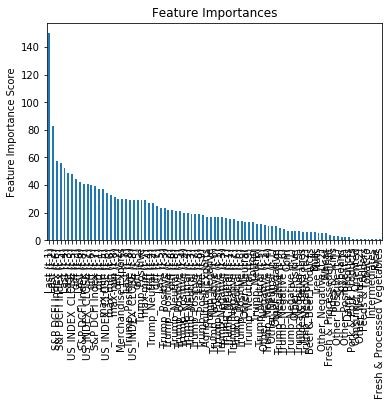

<Figure size 1440x1440 with 0 Axes>


best params 
 {'subsample': 0.6, 'reg_alpha': 0.1, 'n_estimators': 135, 'min_child_weight': 4, 'max_depth': 16, 'learning_rate': 0.05, 'gamma': 0.4, 'colsample_bytree': 0.8}



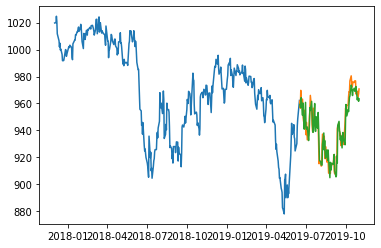


lagging prices by : 9
lagging trump tweets by : 11
lagging tweets by : 1
columns being used:
Index(['Other_Positive', 'Other_Negative', 'Other_Neutral',
       'Agricultural Exports', 'Beef & Beef Products', 'Bulk',
       'Consumer Oriented', 'Corn', 'Cotton', 'Dairy Products',
       'Feeds & Fodders', 'Fresh & Processed Fruit',
       'Fresh & Processed Vegetables', 'Hides & Skins', 'Intermediates',
       'Juices & Beverages', 'Merchandise Exports', 'Pork & Pork Products',
       'Poultry Meat & Products', 'Prepared Food', 'Rice',
       'Soybean & Vegetable Oil', 'Soybeans', 'Soymeal', 'Tobacco',
       'Tree Nuts', 'Wheat', 'Wine & Beer', 'Trump_Positive', 'Trump_Negative',
       'Trump_Neutral', 'Last (t-1)', 'diff (t-1)', 'Last (t-2)', 'diff (t-2)',
       'Last (t-3)', 'diff (t-3)', 'Last (t-4)', 'diff (t-4)', 'Last (t-5)',
       'diff (t-5)', 'Last (t-6)', 'diff (t-6)', 'Last (t-7)', 'diff (t-7)',
       'Last (t-8)', 'diff (t-8)', 'S&P DCFI Index (t-5)', 'max-min (t-5)',


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 254 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   10.5s finished


[18:36:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training R-squared:  1.0
Training Explained Variation:  1.0
Training RMSE:  0.21
Training MAE:  0.16  

Test R-squared:  0.8
Test Explained Variation:  0.8
Test RMSE:  9.29
Test MAE:  7.61


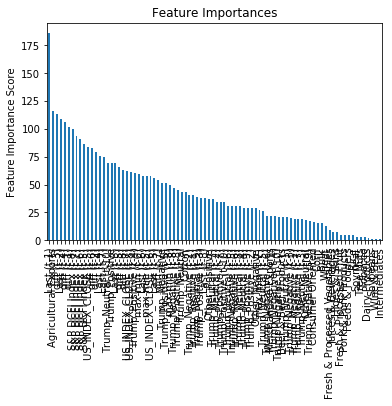

<Figure size 1440x1440 with 0 Axes>


best params 
 {'subsample': 0.8, 'reg_alpha': 0.1, 'n_estimators': 175, 'min_child_weight': 1, 'max_depth': 13, 'learning_rate': 0.1, 'gamma': 0.4, 'colsample_bytree': 0.8}



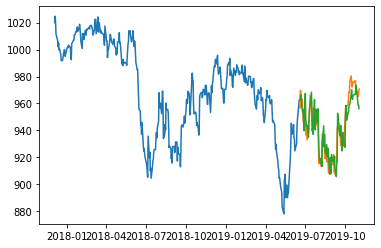


lagging prices by : 9
lagging trump tweets by : 11
lagging tweets by : 2
columns being used:
Index(['Other_Positive', 'Other_Negative', 'Other_Neutral',
       'Agricultural Exports', 'Beef & Beef Products', 'Bulk',
       'Consumer Oriented', 'Corn', 'Cotton', 'Dairy Products',
       'Feeds & Fodders', 'Fresh & Processed Fruit',
       'Fresh & Processed Vegetables', 'Hides & Skins', 'Intermediates',
       'Juices & Beverages', 'Merchandise Exports', 'Pork & Pork Products',
       'Poultry Meat & Products', 'Prepared Food', 'Rice',
       'Soybean & Vegetable Oil', 'Soybeans', 'Soymeal', 'Tobacco',
       'Tree Nuts', 'Wheat', 'Wine & Beer', 'Trump_Positive', 'Trump_Negative',
       'Trump_Neutral', 'Last (t-1)', 'diff (t-1)', 'Last (t-2)', 'diff (t-2)',
       'Last (t-3)', 'diff (t-3)', 'Last (t-4)', 'diff (t-4)', 'Last (t-5)',
       'diff (t-5)', 'Last (t-6)', 'diff (t-6)', 'Last (t-7)', 'diff (t-7)',
       'Last (t-8)', 'diff (t-8)', 'S&P DCFI Index (t-5)', 'max-min (t-5)',


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 271 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   10.1s finished


[18:36:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training R-squared:  0.99
Training Explained Variation:  0.99
Training RMSE:  3.07
Training MAE:  2.2  

Test R-squared:  0.85
Test Explained Variation:  0.85
Test RMSE:  8.14
Test MAE:  6.65


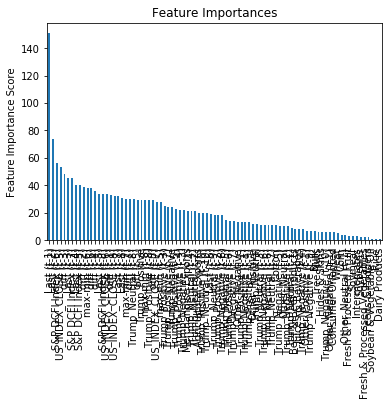

<Figure size 1440x1440 with 0 Axes>


best params 
 {'subsample': 0.6, 'reg_alpha': 0.1, 'n_estimators': 135, 'min_child_weight': 4, 'max_depth': 16, 'learning_rate': 0.05, 'gamma': 0.4, 'colsample_bytree': 0.8}



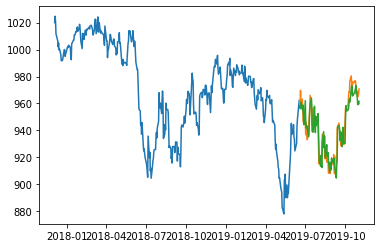


lagging prices by : 9
lagging trump tweets by : 11
lagging tweets by : 3
columns being used:
Index(['Other_Positive', 'Other_Negative', 'Other_Neutral',
       'Agricultural Exports', 'Beef & Beef Products', 'Bulk',
       'Consumer Oriented', 'Corn', 'Cotton', 'Dairy Products',
       'Feeds & Fodders', 'Fresh & Processed Fruit',
       'Fresh & Processed Vegetables', 'Hides & Skins', 'Intermediates',
       'Juices & Beverages', 'Merchandise Exports', 'Pork & Pork Products',
       'Poultry Meat & Products', 'Prepared Food', 'Rice',
       'Soybean & Vegetable Oil', 'Soybeans', 'Soymeal', 'Tobacco',
       'Tree Nuts', 'Wheat', 'Wine & Beer', 'Trump_Positive', 'Trump_Negative',
       'Trump_Neutral', 'Last (t-1)', 'diff (t-1)', 'Last (t-2)', 'diff (t-2)',
       'Last (t-3)', 'diff (t-3)', 'Last (t-4)', 'diff (t-4)', 'Last (t-5)',
       'diff (t-5)', 'Last (t-6)', 'diff (t-6)', 'Last (t-7)', 'diff (t-7)',
       'Last (t-8)', 'diff (t-8)', 'S&P DCFI Index (t-5)', 'max-min (t-5)',


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   10.6s finished


[18:36:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training R-squared:  1.0
Training Explained Variation:  1.0
Training RMSE:  1.65
Training MAE:  1.23  

Test R-squared:  0.83
Test Explained Variation:  0.83
Test RMSE:  8.65
Test MAE:  6.85


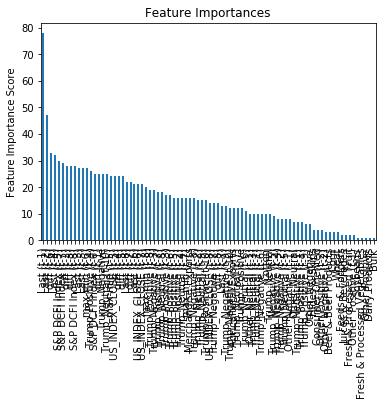

<Figure size 1440x1440 with 0 Axes>


best params 
 {'subsample': 0.8, 'reg_alpha': 1, 'n_estimators': 105, 'min_child_weight': 4, 'max_depth': 6, 'learning_rate': 0.1, 'gamma': 0.2, 'colsample_bytree': 0.8}



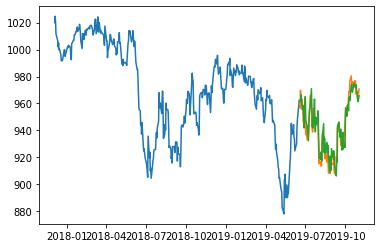


lagging prices by : 10
lagging trump tweets by : 6
lagging tweets by : 1
columns being used:
Index(['Other_Positive', 'Other_Negative', 'Other_Neutral',
       'Agricultural Exports', 'Beef & Beef Products', 'Bulk',
       'Consumer Oriented', 'Corn', 'Cotton', 'Dairy Products',
       'Feeds & Fodders', 'Fresh & Processed Fruit',
       'Fresh & Processed Vegetables', 'Hides & Skins', 'Intermediates',
       'Juices & Beverages', 'Merchandise Exports', 'Pork & Pork Products',
       'Poultry Meat & Products', 'Prepared Food', 'Rice',
       'Soybean & Vegetable Oil', 'Soybeans', 'Soymeal', 'Tobacco',
       'Tree Nuts', 'Wheat', 'Wine & Beer', 'Trump_Positive', 'Trump_Negative',
       'Trump_Neutral', 'Last (t-1)', 'diff (t-1)', 'Last (t-2)', 'diff (t-2)',
       'Last (t-3)', 'diff (t-3)', 'Last (t-4)', 'diff (t-4)', 'Last (t-5)',
       'diff (t-5)', 'Last (t-6)', 'diff (t-6)', 'Last (t-7)', 'diff (t-7)',
       'Last (t-8)', 'diff (t-8)', 'Last (t-9)', 'diff (t-9)',
       'S&P D

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   10.5s finished


[18:37:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training R-squared:  1.0
Training Explained Variation:  1.0
Training RMSE:  0.2
Training MAE:  0.15  

Test R-squared:  0.8
Test Explained Variation:  0.8
Test RMSE:  9.38
Test MAE:  7.43


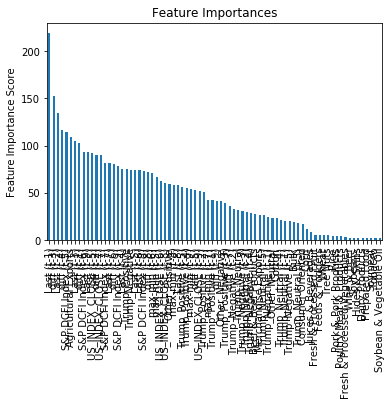

<Figure size 1440x1440 with 0 Axes>


best params 
 {'subsample': 0.8, 'reg_alpha': 0.1, 'n_estimators': 175, 'min_child_weight': 1, 'max_depth': 13, 'learning_rate': 0.1, 'gamma': 0.4, 'colsample_bytree': 0.8}



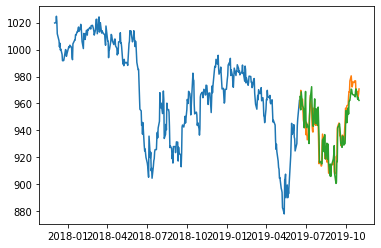


lagging prices by : 10
lagging trump tweets by : 6
lagging tweets by : 2
columns being used:
Index(['Other_Positive', 'Other_Negative', 'Other_Neutral',
       'Agricultural Exports', 'Beef & Beef Products', 'Bulk',
       'Consumer Oriented', 'Corn', 'Cotton', 'Dairy Products',
       'Feeds & Fodders', 'Fresh & Processed Fruit',
       'Fresh & Processed Vegetables', 'Hides & Skins', 'Intermediates',
       'Juices & Beverages', 'Merchandise Exports', 'Pork & Pork Products',
       'Poultry Meat & Products', 'Prepared Food', 'Rice',
       'Soybean & Vegetable Oil', 'Soybeans', 'Soymeal', 'Tobacco',
       'Tree Nuts', 'Wheat', 'Wine & Beer', 'Trump_Positive', 'Trump_Negative',
       'Trump_Neutral', 'Last (t-1)', 'diff (t-1)', 'Last (t-2)', 'diff (t-2)',
       'Last (t-3)', 'diff (t-3)', 'Last (t-4)', 'diff (t-4)', 'Last (t-5)',
       'diff (t-5)', 'Last (t-6)', 'diff (t-6)', 'Last (t-7)', 'diff (t-7)',
       'Last (t-8)', 'diff (t-8)', 'Last (t-9)', 'diff (t-9)',
       'S&P D

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 270 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    9.5s finished


[18:37:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training R-squared:  1.0
Training Explained Variation:  1.0
Training RMSE:  0.27
Training MAE:  0.19  

Test R-squared:  0.81
Test Explained Variation:  0.81
Test RMSE:  9.07
Test MAE:  7.34


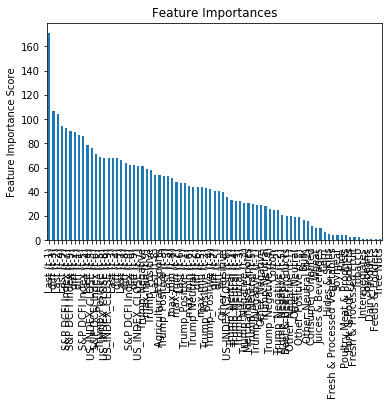

<Figure size 1440x1440 with 0 Axes>


best params 
 {'subsample': 0.9, 'reg_alpha': 1, 'n_estimators': 165, 'min_child_weight': 1, 'max_depth': 16, 'learning_rate': 0.1, 'gamma': 0.4, 'colsample_bytree': 0.7}



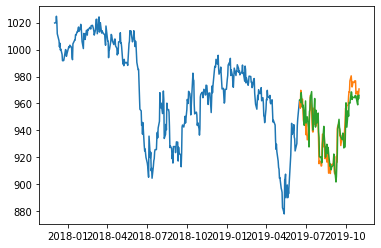


lagging prices by : 10
lagging trump tweets by : 6
lagging tweets by : 3
columns being used:
Index(['Other_Positive', 'Other_Negative', 'Other_Neutral',
       'Agricultural Exports', 'Beef & Beef Products', 'Bulk',
       'Consumer Oriented', 'Corn', 'Cotton', 'Dairy Products',
       'Feeds & Fodders', 'Fresh & Processed Fruit',
       'Fresh & Processed Vegetables', 'Hides & Skins', 'Intermediates',
       'Juices & Beverages', 'Merchandise Exports', 'Pork & Pork Products',
       'Poultry Meat & Products', 'Prepared Food', 'Rice',
       'Soybean & Vegetable Oil', 'Soybeans', 'Soymeal', 'Tobacco',
       'Tree Nuts', 'Wheat', 'Wine & Beer', 'Trump_Positive', 'Trump_Negative',
       'Trump_Neutral', 'Last (t-1)', 'diff (t-1)', 'Last (t-2)', 'diff (t-2)',
       'Last (t-3)', 'diff (t-3)', 'Last (t-4)', 'diff (t-4)', 'Last (t-5)',
       'diff (t-5)', 'Last (t-6)', 'diff (t-6)', 'Last (t-7)', 'diff (t-7)',
       'Last (t-8)', 'diff (t-8)', 'Last (t-9)', 'diff (t-9)',
       'S&P D

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    9.8s finished


[18:37:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training R-squared:  0.99
Training Explained Variation:  0.99
Training RMSE:  3.1
Training MAE:  2.21  

Test R-squared:  0.84
Test Explained Variation:  0.84
Test RMSE:  8.25
Test MAE:  6.96


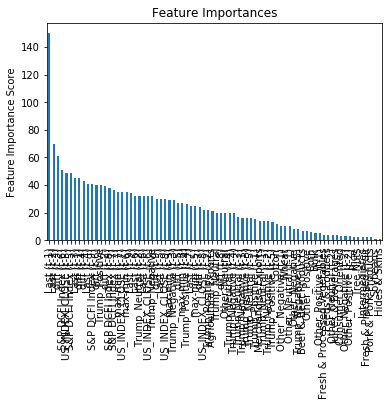

<Figure size 1440x1440 with 0 Axes>


best params 
 {'subsample': 0.6, 'reg_alpha': 0.1, 'n_estimators': 135, 'min_child_weight': 4, 'max_depth': 16, 'learning_rate': 0.05, 'gamma': 0.4, 'colsample_bytree': 0.8}



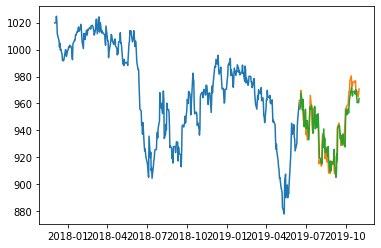


lagging prices by : 10
lagging trump tweets by : 7
lagging tweets by : 1
columns being used:
Index(['Other_Positive', 'Other_Negative', 'Other_Neutral',
       'Agricultural Exports', 'Beef & Beef Products', 'Bulk',
       'Consumer Oriented', 'Corn', 'Cotton', 'Dairy Products',
       'Feeds & Fodders', 'Fresh & Processed Fruit',
       'Fresh & Processed Vegetables', 'Hides & Skins', 'Intermediates',
       'Juices & Beverages', 'Merchandise Exports', 'Pork & Pork Products',
       'Poultry Meat & Products', 'Prepared Food', 'Rice',
       'Soybean & Vegetable Oil', 'Soybeans', 'Soymeal', 'Tobacco',
       'Tree Nuts', 'Wheat', 'Wine & Beer', 'Trump_Positive', 'Trump_Negative',
       'Trump_Neutral', 'Last (t-1)', 'diff (t-1)', 'Last (t-2)', 'diff (t-2)',
       'Last (t-3)', 'diff (t-3)', 'Last (t-4)', 'diff (t-4)', 'Last (t-5)',
       'diff (t-5)', 'Last (t-6)', 'diff (t-6)', 'Last (t-7)', 'diff (t-7)',
       'Last (t-8)', 'diff (t-8)', 'Last (t-9)', 'diff (t-9)',
       'S&P D

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 269 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   10.2s finished


[18:37:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training R-squared:  1.0
Training Explained Variation:  1.0
Training RMSE:  0.97
Training MAE:  0.68  

Test R-squared:  0.84
Test Explained Variation:  0.84
Test RMSE:  8.34
Test MAE:  6.86


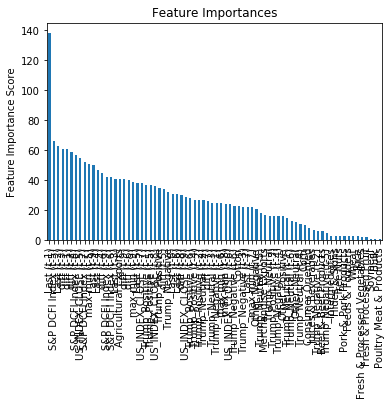

<Figure size 1440x1440 with 0 Axes>


best params 
 {'subsample': 0.9, 'reg_alpha': 1, 'n_estimators': 105, 'min_child_weight': 2, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0.0, 'colsample_bytree': 0.9}



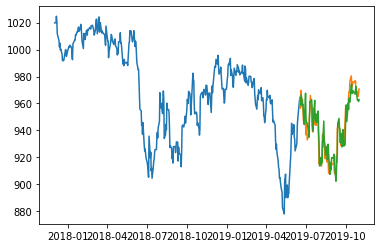


lagging prices by : 10
lagging trump tweets by : 7
lagging tweets by : 2
columns being used:
Index(['Other_Positive', 'Other_Negative', 'Other_Neutral',
       'Agricultural Exports', 'Beef & Beef Products', 'Bulk',
       'Consumer Oriented', 'Corn', 'Cotton', 'Dairy Products',
       'Feeds & Fodders', 'Fresh & Processed Fruit',
       'Fresh & Processed Vegetables', 'Hides & Skins', 'Intermediates',
       'Juices & Beverages', 'Merchandise Exports', 'Pork & Pork Products',
       'Poultry Meat & Products', 'Prepared Food', 'Rice',
       'Soybean & Vegetable Oil', 'Soybeans', 'Soymeal', 'Tobacco',
       'Tree Nuts', 'Wheat', 'Wine & Beer', 'Trump_Positive', 'Trump_Negative',
       'Trump_Neutral', 'Last (t-1)', 'diff (t-1)', 'Last (t-2)', 'diff (t-2)',
       'Last (t-3)', 'diff (t-3)', 'Last (t-4)', 'diff (t-4)', 'Last (t-5)',
       'diff (t-5)', 'Last (t-6)', 'diff (t-6)', 'Last (t-7)', 'diff (t-7)',
       'Last (t-8)', 'diff (t-8)', 'Last (t-9)', 'diff (t-9)',
       'S&P D

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   10.7s finished


[18:38:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training R-squared:  1.0
Training Explained Variation:  1.0
Training RMSE:  1.81
Training MAE:  1.23  

Test R-squared:  0.84
Test Explained Variation:  0.84
Test RMSE:  8.38
Test MAE:  6.92


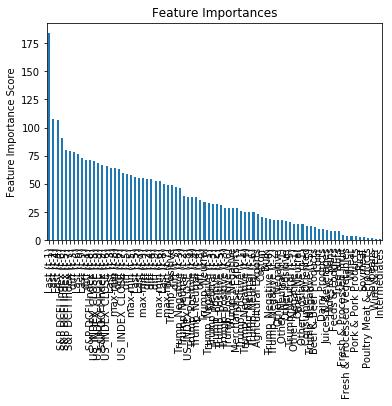

<Figure size 1440x1440 with 0 Axes>


best params 
 {'subsample': 0.6, 'reg_alpha': 0.1, 'n_estimators': 175, 'min_child_weight': 4, 'max_depth': 13, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 0.6}



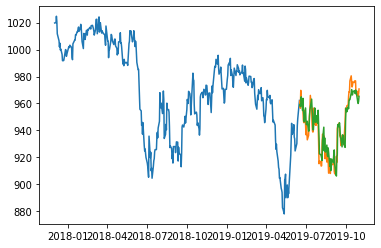


lagging prices by : 10
lagging trump tweets by : 7
lagging tweets by : 3
columns being used:
Index(['Other_Positive', 'Other_Negative', 'Other_Neutral',
       'Agricultural Exports', 'Beef & Beef Products', 'Bulk',
       'Consumer Oriented', 'Corn', 'Cotton', 'Dairy Products',
       'Feeds & Fodders', 'Fresh & Processed Fruit',
       'Fresh & Processed Vegetables', 'Hides & Skins', 'Intermediates',
       'Juices & Beverages', 'Merchandise Exports', 'Pork & Pork Products',
       'Poultry Meat & Products', 'Prepared Food', 'Rice',
       'Soybean & Vegetable Oil', 'Soybeans', 'Soymeal', 'Tobacco',
       'Tree Nuts', 'Wheat', 'Wine & Beer', 'Trump_Positive', 'Trump_Negative',
       'Trump_Neutral', 'Last (t-1)', 'diff (t-1)', 'Last (t-2)', 'diff (t-2)',
       'Last (t-3)', 'diff (t-3)', 'Last (t-4)', 'diff (t-4)', 'Last (t-5)',
       'diff (t-5)', 'Last (t-6)', 'diff (t-6)', 'Last (t-7)', 'diff (t-7)',
       'Last (t-8)', 'diff (t-8)', 'Last (t-9)', 'diff (t-9)',
       'S&P D

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 271 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   10.1s finished


[18:38:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training R-squared:  1.0
Training Explained Variation:  1.0
Training RMSE:  0.47
Training MAE:  0.32  

Test R-squared:  0.76
Test Explained Variation:  0.76
Test RMSE:  10.18
Test MAE:  8.47


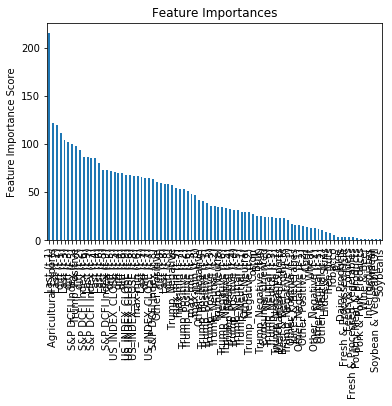

<Figure size 1440x1440 with 0 Axes>


best params 
 {'subsample': 0.6, 'reg_alpha': 1, 'n_estimators': 135, 'min_child_weight': 1, 'max_depth': 13, 'learning_rate': 0.1, 'gamma': 0.4, 'colsample_bytree': 0.7}



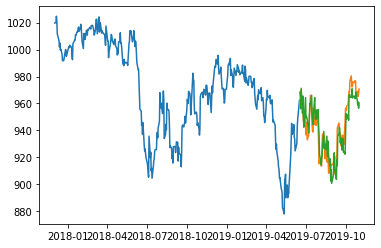


lagging prices by : 10
lagging trump tweets by : 8
lagging tweets by : 1
columns being used:
Index(['Other_Positive', 'Other_Negative', 'Other_Neutral',
       'Agricultural Exports', 'Beef & Beef Products', 'Bulk',
       'Consumer Oriented', 'Corn', 'Cotton', 'Dairy Products',
       'Feeds & Fodders', 'Fresh & Processed Fruit',
       'Fresh & Processed Vegetables', 'Hides & Skins', 'Intermediates',
       'Juices & Beverages', 'Merchandise Exports', 'Pork & Pork Products',
       'Poultry Meat & Products', 'Prepared Food', 'Rice',
       'Soybean & Vegetable Oil', 'Soybeans', 'Soymeal', 'Tobacco',
       'Tree Nuts', 'Wheat', 'Wine & Beer', 'Trump_Positive', 'Trump_Negative',
       'Trump_Neutral', 'Last (t-1)', 'diff (t-1)', 'Last (t-2)', 'diff (t-2)',
       'Last (t-3)', 'diff (t-3)', 'Last (t-4)', 'diff (t-4)', 'Last (t-5)',
       'diff (t-5)', 'Last (t-6)', 'diff (t-6)', 'Last (t-7)', 'diff (t-7)',
       'Last (t-8)', 'diff (t-8)', 'Last (t-9)', 'diff (t-9)',
       'S&P D

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 269 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    9.9s finished


[18:38:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training R-squared:  1.0
Training Explained Variation:  1.0
Training RMSE:  2.41
Training MAE:  1.74  

Test R-squared:  0.84
Test Explained Variation:  0.84
Test RMSE:  8.34
Test MAE:  6.84


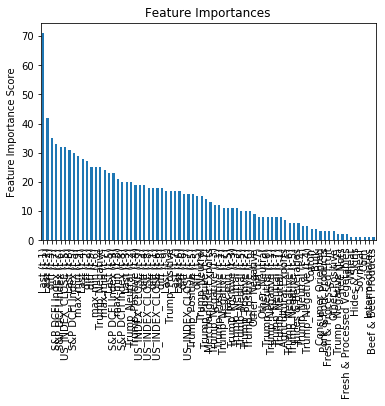

<Figure size 1440x1440 with 0 Axes>


best params 
 {'subsample': 0.9, 'reg_alpha': 0.01, 'n_estimators': 65, 'min_child_weight': 4, 'max_depth': 14, 'learning_rate': 0.1, 'gamma': 0.4, 'colsample_bytree': 0.9}



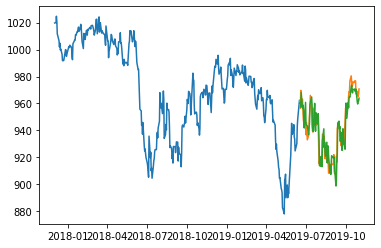


lagging prices by : 10
lagging trump tweets by : 8
lagging tweets by : 2
columns being used:
Index(['Other_Positive', 'Other_Negative', 'Other_Neutral',
       'Agricultural Exports', 'Beef & Beef Products', 'Bulk',
       'Consumer Oriented', 'Corn', 'Cotton', 'Dairy Products',
       'Feeds & Fodders', 'Fresh & Processed Fruit',
       'Fresh & Processed Vegetables', 'Hides & Skins', 'Intermediates',
       'Juices & Beverages', 'Merchandise Exports', 'Pork & Pork Products',
       'Poultry Meat & Products', 'Prepared Food', 'Rice',
       'Soybean & Vegetable Oil', 'Soybeans', 'Soymeal', 'Tobacco',
       'Tree Nuts', 'Wheat', 'Wine & Beer', 'Trump_Positive', 'Trump_Negative',
       'Trump_Neutral', 'Last (t-1)', 'diff (t-1)', 'Last (t-2)', 'diff (t-2)',
       'Last (t-3)', 'diff (t-3)', 'Last (t-4)', 'diff (t-4)', 'Last (t-5)',
       'diff (t-5)', 'Last (t-6)', 'diff (t-6)', 'Last (t-7)', 'diff (t-7)',
       'Last (t-8)', 'diff (t-8)', 'Last (t-9)', 'diff (t-9)',
       'S&P D

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    9.7s finished


[18:38:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training R-squared:  1.0
Training Explained Variation:  1.0
Training RMSE:  1.33
Training MAE:  0.87  

Test R-squared:  0.85
Test Explained Variation:  0.85
Test RMSE:  8.11
Test MAE:  6.62


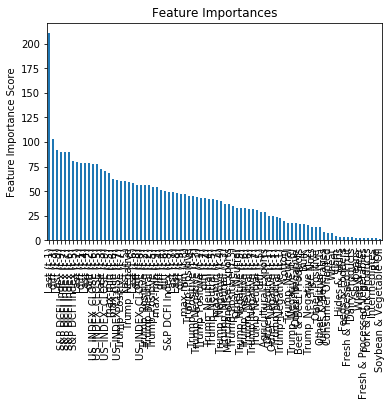

<Figure size 1440x1440 with 0 Axes>


best params 
 {'subsample': 0.9, 'reg_alpha': 1, 'n_estimators': 155, 'min_child_weight': 3, 'max_depth': 14, 'learning_rate': 0.05, 'gamma': 0.3, 'colsample_bytree': 0.8}



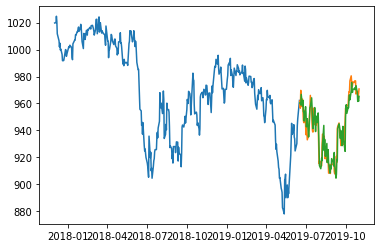


lagging prices by : 10
lagging trump tweets by : 8
lagging tweets by : 3
columns being used:
Index(['Other_Positive', 'Other_Negative', 'Other_Neutral',
       'Agricultural Exports', 'Beef & Beef Products', 'Bulk',
       'Consumer Oriented', 'Corn', 'Cotton', 'Dairy Products',
       'Feeds & Fodders', 'Fresh & Processed Fruit',
       'Fresh & Processed Vegetables', 'Hides & Skins', 'Intermediates',
       'Juices & Beverages', 'Merchandise Exports', 'Pork & Pork Products',
       'Poultry Meat & Products', 'Prepared Food', 'Rice',
       'Soybean & Vegetable Oil', 'Soybeans', 'Soymeal', 'Tobacco',
       'Tree Nuts', 'Wheat', 'Wine & Beer', 'Trump_Positive', 'Trump_Negative',
       'Trump_Neutral', 'Last (t-1)', 'diff (t-1)', 'Last (t-2)', 'diff (t-2)',
       'Last (t-3)', 'diff (t-3)', 'Last (t-4)', 'diff (t-4)', 'Last (t-5)',
       'diff (t-5)', 'Last (t-6)', 'diff (t-6)', 'Last (t-7)', 'diff (t-7)',
       'Last (t-8)', 'diff (t-8)', 'Last (t-9)', 'diff (t-9)',
       'S&P D

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 273 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   10.1s finished


[18:39:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training R-squared:  1.0
Training Explained Variation:  1.0
Training RMSE:  1.32
Training MAE:  0.89  

Test R-squared:  0.84
Test Explained Variation:  0.85
Test RMSE:  8.16
Test MAE:  6.54


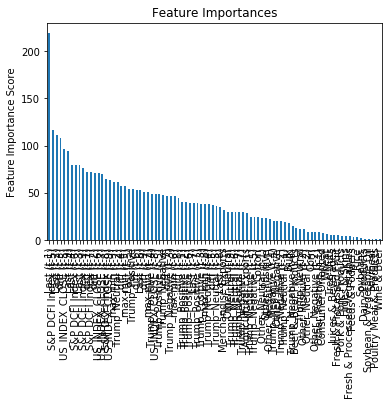

<Figure size 1440x1440 with 0 Axes>


best params 
 {'subsample': 0.9, 'reg_alpha': 1, 'n_estimators': 155, 'min_child_weight': 3, 'max_depth': 14, 'learning_rate': 0.05, 'gamma': 0.3, 'colsample_bytree': 0.8}



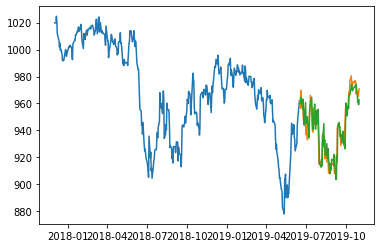


lagging prices by : 10
lagging trump tweets by : 9
lagging tweets by : 1
columns being used:
Index(['Other_Positive', 'Other_Negative', 'Other_Neutral',
       'Agricultural Exports', 'Beef & Beef Products', 'Bulk',
       'Consumer Oriented', 'Corn', 'Cotton', 'Dairy Products',
       'Feeds & Fodders', 'Fresh & Processed Fruit',
       'Fresh & Processed Vegetables', 'Hides & Skins', 'Intermediates',
       'Juices & Beverages', 'Merchandise Exports', 'Pork & Pork Products',
       'Poultry Meat & Products', 'Prepared Food', 'Rice',
       'Soybean & Vegetable Oil', 'Soybeans', 'Soymeal', 'Tobacco',
       'Tree Nuts', 'Wheat', 'Wine & Beer', 'Trump_Positive', 'Trump_Negative',
       'Trump_Neutral', 'Last (t-1)', 'diff (t-1)', 'Last (t-2)', 'diff (t-2)',
       'Last (t-3)', 'diff (t-3)', 'Last (t-4)', 'diff (t-4)', 'Last (t-5)',
       'diff (t-5)', 'Last (t-6)', 'diff (t-6)', 'Last (t-7)', 'diff (t-7)',
       'Last (t-8)', 'diff (t-8)', 'Last (t-9)', 'diff (t-9)',
       'S&P D

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   10.4s finished


[18:39:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training R-squared:  1.0
Training Explained Variation:  1.0
Training RMSE:  1.31
Training MAE:  0.85  

Test R-squared:  0.84
Test Explained Variation:  0.84
Test RMSE:  8.38
Test MAE:  6.9


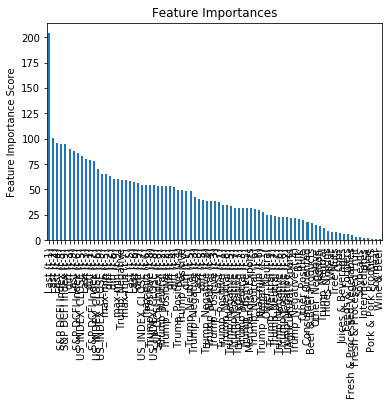

<Figure size 1440x1440 with 0 Axes>


best params 
 {'subsample': 0.9, 'reg_alpha': 1, 'n_estimators': 155, 'min_child_weight': 3, 'max_depth': 14, 'learning_rate': 0.05, 'gamma': 0.3, 'colsample_bytree': 0.8}



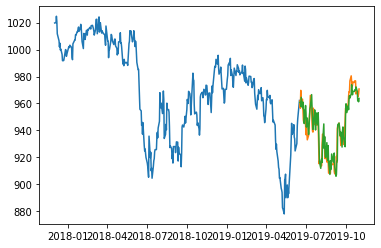


lagging prices by : 10
lagging trump tweets by : 9
lagging tweets by : 2
columns being used:
Index(['Other_Positive', 'Other_Negative', 'Other_Neutral',
       'Agricultural Exports', 'Beef & Beef Products', 'Bulk',
       'Consumer Oriented', 'Corn', 'Cotton', 'Dairy Products',
       'Feeds & Fodders', 'Fresh & Processed Fruit',
       'Fresh & Processed Vegetables', 'Hides & Skins', 'Intermediates',
       'Juices & Beverages', 'Merchandise Exports', 'Pork & Pork Products',
       'Poultry Meat & Products', 'Prepared Food', 'Rice',
       'Soybean & Vegetable Oil', 'Soybeans', 'Soymeal', 'Tobacco',
       'Tree Nuts', 'Wheat', 'Wine & Beer', 'Trump_Positive', 'Trump_Negative',
       'Trump_Neutral', 'Last (t-1)', 'diff (t-1)', 'Last (t-2)', 'diff (t-2)',
       'Last (t-3)', 'diff (t-3)', 'Last (t-4)', 'diff (t-4)', 'Last (t-5)',
       'diff (t-5)', 'Last (t-6)', 'diff (t-6)', 'Last (t-7)', 'diff (t-7)',
       'Last (t-8)', 'diff (t-8)', 'Last (t-9)', 'diff (t-9)',
       'S&P D

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   10.4s finished


[18:39:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training R-squared:  1.0
Training Explained Variation:  1.0
Training RMSE:  1.33
Training MAE:  0.89  

Test R-squared:  0.85
Test Explained Variation:  0.85
Test RMSE:  8.12
Test MAE:  6.49


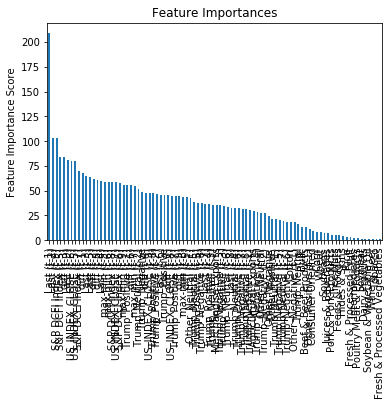

<Figure size 1440x1440 with 0 Axes>


best params 
 {'subsample': 0.9, 'reg_alpha': 1, 'n_estimators': 155, 'min_child_weight': 3, 'max_depth': 14, 'learning_rate': 0.05, 'gamma': 0.3, 'colsample_bytree': 0.8}



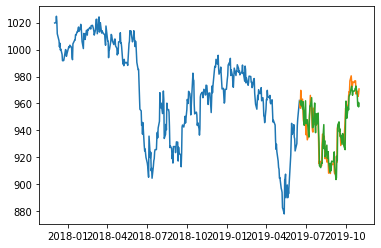


lagging prices by : 10
lagging trump tweets by : 9
lagging tweets by : 3
columns being used:
Index(['Other_Positive', 'Other_Negative', 'Other_Neutral',
       'Agricultural Exports', 'Beef & Beef Products', 'Bulk',
       'Consumer Oriented', 'Corn', 'Cotton', 'Dairy Products',
       'Feeds & Fodders', 'Fresh & Processed Fruit',
       'Fresh & Processed Vegetables', 'Hides & Skins', 'Intermediates',
       'Juices & Beverages', 'Merchandise Exports', 'Pork & Pork Products',
       'Poultry Meat & Products', 'Prepared Food', 'Rice',
       'Soybean & Vegetable Oil', 'Soybeans', 'Soymeal', 'Tobacco',
       'Tree Nuts', 'Wheat', 'Wine & Beer', 'Trump_Positive', 'Trump_Negative',
       'Trump_Neutral', 'Last (t-1)', 'diff (t-1)', 'Last (t-2)', 'diff (t-2)',
       'Last (t-3)', 'diff (t-3)', 'Last (t-4)', 'diff (t-4)', 'Last (t-5)',
       'diff (t-5)', 'Last (t-6)', 'diff (t-6)', 'Last (t-7)', 'diff (t-7)',
       'Last (t-8)', 'diff (t-8)', 'Last (t-9)', 'diff (t-9)',
       'S&P D

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 250 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   10.6s finished


[18:39:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training R-squared:  1.0
Training Explained Variation:  1.0
Training RMSE:  0.74
Training MAE:  0.53  

Test R-squared:  0.8
Test Explained Variation:  0.8
Test RMSE:  9.28
Test MAE:  7.61


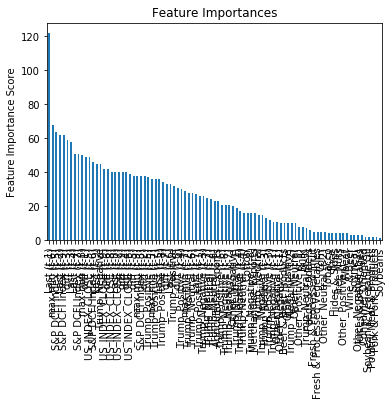

<Figure size 1440x1440 with 0 Axes>


best params 
 {'subsample': 0.8, 'reg_alpha': 1, 'n_estimators': 145, 'min_child_weight': 3, 'max_depth': 6, 'learning_rate': 0.1, 'gamma': 0.2, 'colsample_bytree': 0.7}



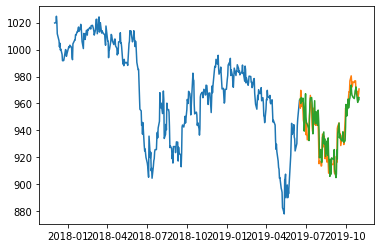


lagging prices by : 10
lagging trump tweets by : 10
lagging tweets by : 1
columns being used:
Index(['Other_Positive', 'Other_Negative', 'Other_Neutral',
       'Agricultural Exports', 'Beef & Beef Products', 'Bulk',
       'Consumer Oriented', 'Corn', 'Cotton', 'Dairy Products',
       'Feeds & Fodders', 'Fresh & Processed Fruit',
       'Fresh & Processed Vegetables', 'Hides & Skins', 'Intermediates',
       'Juices & Beverages', 'Merchandise Exports', 'Pork & Pork Products',
       'Poultry Meat & Products', 'Prepared Food', 'Rice',
       'Soybean & Vegetable Oil', 'Soybeans', 'Soymeal', 'Tobacco',
       'Tree Nuts', 'Wheat', 'Wine & Beer', 'Trump_Positive', 'Trump_Negative',
       'Trump_Neutral', 'Last (t-1)', 'diff (t-1)', 'Last (t-2)', 'diff (t-2)',
       'Last (t-3)', 'diff (t-3)', 'Last (t-4)', 'diff (t-4)', 'Last (t-5)',
       'diff (t-5)', 'Last (t-6)', 'diff (t-6)', 'Last (t-7)', 'diff (t-7)',
       'Last (t-8)', 'diff (t-8)', 'Last (t-9)', 'diff (t-9)',
       'S&P 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   11.2s finished


[18:40:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training R-squared:  1.0
Training Explained Variation:  1.0
Training RMSE:  0.41
Training MAE:  0.25  

Test R-squared:  0.82
Test Explained Variation:  0.82
Test RMSE:  8.88
Test MAE:  7.27


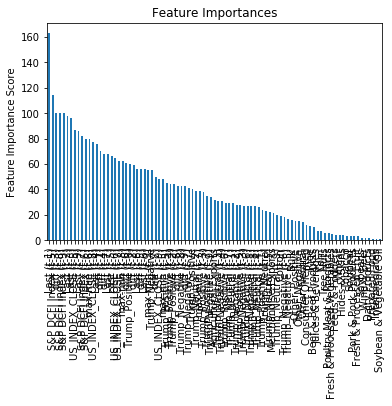

<Figure size 1440x1440 with 0 Axes>


best params 
 {'subsample': 0.8, 'reg_alpha': 1, 'n_estimators': 125, 'min_child_weight': 3, 'max_depth': 12, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.7}



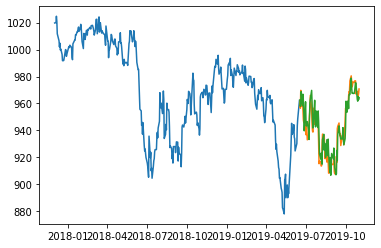


lagging prices by : 10
lagging trump tweets by : 10
lagging tweets by : 2
columns being used:
Index(['Other_Positive', 'Other_Negative', 'Other_Neutral',
       'Agricultural Exports', 'Beef & Beef Products', 'Bulk',
       'Consumer Oriented', 'Corn', 'Cotton', 'Dairy Products',
       'Feeds & Fodders', 'Fresh & Processed Fruit',
       'Fresh & Processed Vegetables', 'Hides & Skins', 'Intermediates',
       'Juices & Beverages', 'Merchandise Exports', 'Pork & Pork Products',
       'Poultry Meat & Products', 'Prepared Food', 'Rice',
       'Soybean & Vegetable Oil', 'Soybeans', 'Soymeal', 'Tobacco',
       'Tree Nuts', 'Wheat', 'Wine & Beer', 'Trump_Positive', 'Trump_Negative',
       'Trump_Neutral', 'Last (t-1)', 'diff (t-1)', 'Last (t-2)', 'diff (t-2)',
       'Last (t-3)', 'diff (t-3)', 'Last (t-4)', 'diff (t-4)', 'Last (t-5)',
       'diff (t-5)', 'Last (t-6)', 'diff (t-6)', 'Last (t-7)', 'diff (t-7)',
       'Last (t-8)', 'diff (t-8)', 'Last (t-9)', 'diff (t-9)',
       'S&P 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   10.7s finished


[18:40:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training R-squared:  1.0
Training Explained Variation:  1.0
Training RMSE:  0.15
Training MAE:  0.09  

Test R-squared:  0.82
Test Explained Variation:  0.82
Test RMSE:  8.88
Test MAE:  7.14


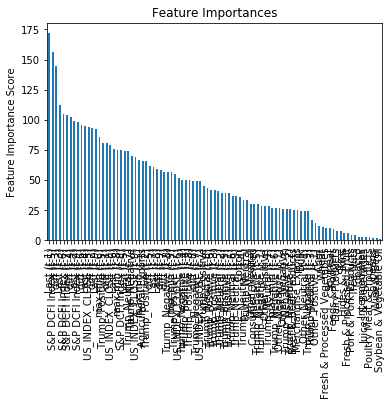

<Figure size 1440x1440 with 0 Axes>


best params 
 {'subsample': 0.9, 'reg_alpha': 1e-05, 'n_estimators': 135, 'min_child_weight': 2, 'max_depth': 17, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.6}



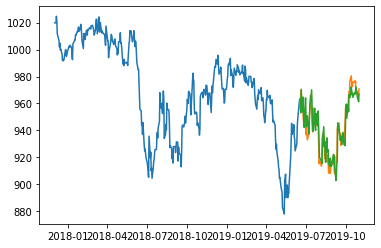


lagging prices by : 10
lagging trump tweets by : 10
lagging tweets by : 3
columns being used:
Index(['Other_Positive', 'Other_Negative', 'Other_Neutral',
       'Agricultural Exports', 'Beef & Beef Products', 'Bulk',
       'Consumer Oriented', 'Corn', 'Cotton', 'Dairy Products',
       'Feeds & Fodders', 'Fresh & Processed Fruit',
       'Fresh & Processed Vegetables', 'Hides & Skins', 'Intermediates',
       'Juices & Beverages', 'Merchandise Exports', 'Pork & Pork Products',
       'Poultry Meat & Products', 'Prepared Food', 'Rice',
       'Soybean & Vegetable Oil', 'Soybeans', 'Soymeal', 'Tobacco',
       'Tree Nuts', 'Wheat', 'Wine & Beer', 'Trump_Positive', 'Trump_Negative',
       'Trump_Neutral', 'Last (t-1)', 'diff (t-1)', 'Last (t-2)', 'diff (t-2)',
       'Last (t-3)', 'diff (t-3)', 'Last (t-4)', 'diff (t-4)', 'Last (t-5)',
       'diff (t-5)', 'Last (t-6)', 'diff (t-6)', 'Last (t-7)', 'diff (t-7)',
       'Last (t-8)', 'diff (t-8)', 'Last (t-9)', 'diff (t-9)',
       'S&P 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   11.1s finished


[18:40:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training R-squared:  1.0
Training Explained Variation:  1.0
Training RMSE:  1.33
Training MAE:  0.86  

Test R-squared:  0.84
Test Explained Variation:  0.84
Test RMSE:  8.29
Test MAE:  6.78


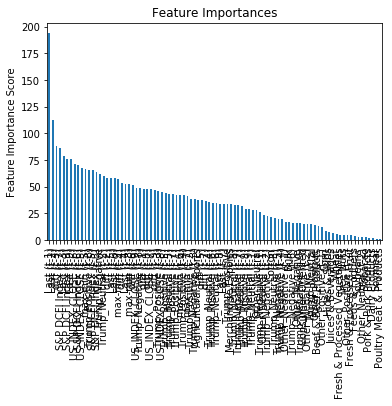

<Figure size 1440x1440 with 0 Axes>


best params 
 {'subsample': 0.9, 'reg_alpha': 1, 'n_estimators': 155, 'min_child_weight': 3, 'max_depth': 14, 'learning_rate': 0.05, 'gamma': 0.3, 'colsample_bytree': 0.8}



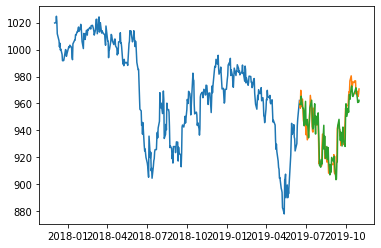


lagging prices by : 10
lagging trump tweets by : 11
lagging tweets by : 1
columns being used:
Index(['Other_Positive', 'Other_Negative', 'Other_Neutral',
       'Agricultural Exports', 'Beef & Beef Products', 'Bulk',
       'Consumer Oriented', 'Corn', 'Cotton', 'Dairy Products',
       'Feeds & Fodders', 'Fresh & Processed Fruit',
       'Fresh & Processed Vegetables', 'Hides & Skins', 'Intermediates',
       'Juices & Beverages', 'Merchandise Exports', 'Pork & Pork Products',
       'Poultry Meat & Products', 'Prepared Food', 'Rice',
       'Soybean & Vegetable Oil', 'Soybeans', 'Soymeal', 'Tobacco',
       'Tree Nuts', 'Wheat', 'Wine & Beer', 'Trump_Positive', 'Trump_Negative',
       'Trump_Neutral', 'Last (t-1)', 'diff (t-1)', 'Last (t-2)', 'diff (t-2)',
       'Last (t-3)', 'diff (t-3)', 'Last (t-4)', 'diff (t-4)', 'Last (t-5)',
       'diff (t-5)', 'Last (t-6)', 'diff (t-6)', 'Last (t-7)', 'diff (t-7)',
       'Last (t-8)', 'diff (t-8)', 'Last (t-9)', 'diff (t-9)',
       'S&P 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 261 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   10.8s finished


[18:40:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training R-squared:  1.0
Training Explained Variation:  1.0
Training RMSE:  0.22
Training MAE:  0.16  

Test R-squared:  0.78
Test Explained Variation:  0.78
Test RMSE:  9.81
Test MAE:  8.35


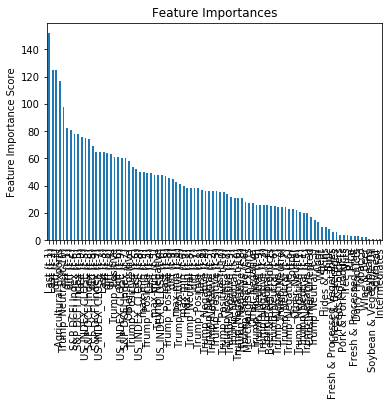

<Figure size 1440x1440 with 0 Axes>


best params 
 {'subsample': 0.8, 'reg_alpha': 0.1, 'n_estimators': 175, 'min_child_weight': 1, 'max_depth': 13, 'learning_rate': 0.1, 'gamma': 0.4, 'colsample_bytree': 0.8}



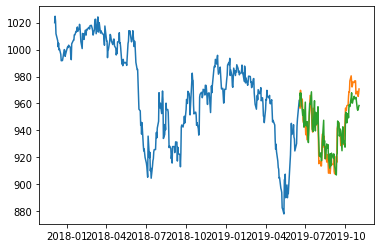


lagging prices by : 10
lagging trump tweets by : 11
lagging tweets by : 2
columns being used:
Index(['Other_Positive', 'Other_Negative', 'Other_Neutral',
       'Agricultural Exports', 'Beef & Beef Products', 'Bulk',
       'Consumer Oriented', 'Corn', 'Cotton', 'Dairy Products',
       'Feeds & Fodders', 'Fresh & Processed Fruit',
       'Fresh & Processed Vegetables', 'Hides & Skins', 'Intermediates',
       'Juices & Beverages', 'Merchandise Exports', 'Pork & Pork Products',
       'Poultry Meat & Products', 'Prepared Food', 'Rice',
       'Soybean & Vegetable Oil', 'Soybeans', 'Soymeal', 'Tobacco',
       'Tree Nuts', 'Wheat', 'Wine & Beer', 'Trump_Positive', 'Trump_Negative',
       'Trump_Neutral', 'Last (t-1)', 'diff (t-1)', 'Last (t-2)', 'diff (t-2)',
       'Last (t-3)', 'diff (t-3)', 'Last (t-4)', 'diff (t-4)', 'Last (t-5)',
       'diff (t-5)', 'Last (t-6)', 'diff (t-6)', 'Last (t-7)', 'diff (t-7)',
       'Last (t-8)', 'diff (t-8)', 'Last (t-9)', 'diff (t-9)',
       'S&P 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   11.1s finished


[18:41:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training R-squared:  1.0
Training Explained Variation:  1.0
Training RMSE:  1.44
Training MAE:  0.88  

Test R-squared:  0.82
Test Explained Variation:  0.83
Test RMSE:  8.89
Test MAE:  7.28


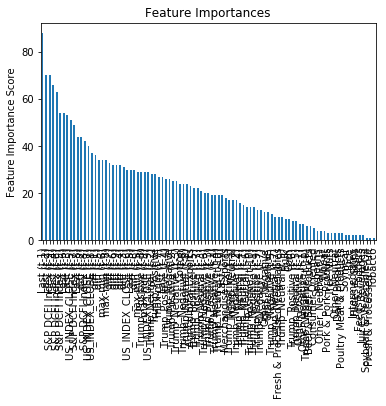

<Figure size 1440x1440 with 0 Axes>


best params 
 {'subsample': 0.6, 'reg_alpha': 0.01, 'n_estimators': 95, 'min_child_weight': 4, 'max_depth': 16, 'learning_rate': 0.1, 'gamma': 0.0, 'colsample_bytree': 0.6}



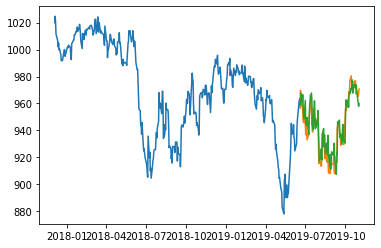


lagging prices by : 10
lagging trump tweets by : 11
lagging tweets by : 3
columns being used:
Index(['Other_Positive', 'Other_Negative', 'Other_Neutral',
       'Agricultural Exports', 'Beef & Beef Products', 'Bulk',
       'Consumer Oriented', 'Corn', 'Cotton', 'Dairy Products',
       'Feeds & Fodders', 'Fresh & Processed Fruit',
       'Fresh & Processed Vegetables', 'Hides & Skins', 'Intermediates',
       'Juices & Beverages', 'Merchandise Exports', 'Pork & Pork Products',
       'Poultry Meat & Products', 'Prepared Food', 'Rice',
       'Soybean & Vegetable Oil', 'Soybeans', 'Soymeal', 'Tobacco',
       'Tree Nuts', 'Wheat', 'Wine & Beer', 'Trump_Positive', 'Trump_Negative',
       'Trump_Neutral', 'Last (t-1)', 'diff (t-1)', 'Last (t-2)', 'diff (t-2)',
       'Last (t-3)', 'diff (t-3)', 'Last (t-4)', 'diff (t-4)', 'Last (t-5)',
       'diff (t-5)', 'Last (t-6)', 'diff (t-6)', 'Last (t-7)', 'diff (t-7)',
       'Last (t-8)', 'diff (t-8)', 'Last (t-9)', 'diff (t-9)',
       'S&P 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 253 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   11.0s finished


[18:41:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training R-squared:  1.0
Training Explained Variation:  1.0
Training RMSE:  1.51
Training MAE:  0.97  

Test R-squared:  0.83
Test Explained Variation:  0.83
Test RMSE:  8.5
Test MAE:  6.72


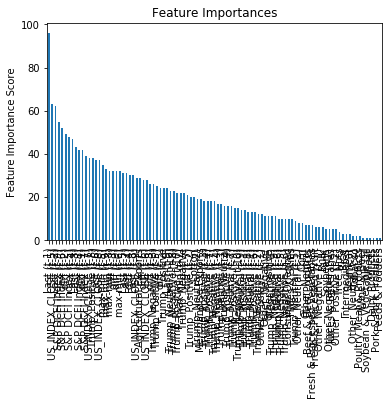

<Figure size 1440x1440 with 0 Axes>


best params 
 {'subsample': 0.6, 'reg_alpha': 1, 'n_estimators': 95, 'min_child_weight': 4, 'max_depth': 18, 'learning_rate': 0.1, 'gamma': 0.3, 'colsample_bytree': 0.7}



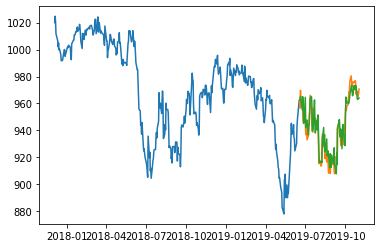


lagging prices by : 11
lagging trump tweets by : 6
lagging tweets by : 1
columns being used:
Index(['Other_Positive', 'Other_Negative', 'Other_Neutral',
       'Agricultural Exports', 'Beef & Beef Products', 'Bulk',
       'Consumer Oriented', 'Corn', 'Cotton', 'Dairy Products',
       'Feeds & Fodders', 'Fresh & Processed Fruit',
       'Fresh & Processed Vegetables', 'Hides & Skins', 'Intermediates',
       'Juices & Beverages', 'Merchandise Exports', 'Pork & Pork Products',
       'Poultry Meat & Products', 'Prepared Food', 'Rice',
       'Soybean & Vegetable Oil', 'Soybeans', 'Soymeal', 'Tobacco',
       'Tree Nuts', 'Wheat', 'Wine & Beer', 'Trump_Positive', 'Trump_Negative',
       'Trump_Neutral', 'Last (t-1)', 'diff (t-1)', 'Last (t-2)', 'diff (t-2)',
       'Last (t-3)', 'diff (t-3)', 'Last (t-4)', 'diff (t-4)', 'Last (t-5)',
       'diff (t-5)', 'Last (t-6)', 'diff (t-6)', 'Last (t-7)', 'diff (t-7)',
       'Last (t-8)', 'diff (t-8)', 'Last (t-9)', 'diff (t-9)', 'Last (t-10)'

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   10.4s finished


[18:41:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training R-squared:  0.99
Training Explained Variation:  0.99
Training RMSE:  3.0
Training MAE:  2.32  

Test R-squared:  0.79
Test Explained Variation:  0.82
Test RMSE:  9.39
Test MAE:  7.34


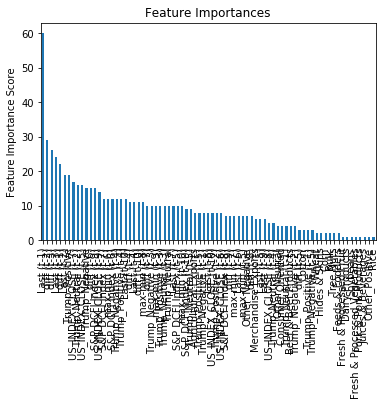

<Figure size 1440x1440 with 0 Axes>


best params 
 {'subsample': 0.6, 'reg_alpha': 1e-05, 'n_estimators': 145, 'min_child_weight': 2, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0.4, 'colsample_bytree': 0.7}



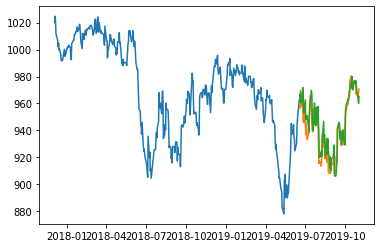


lagging prices by : 11
lagging trump tweets by : 6
lagging tweets by : 2
columns being used:
Index(['Other_Positive', 'Other_Negative', 'Other_Neutral',
       'Agricultural Exports', 'Beef & Beef Products', 'Bulk',
       'Consumer Oriented', 'Corn', 'Cotton', 'Dairy Products',
       'Feeds & Fodders', 'Fresh & Processed Fruit',
       'Fresh & Processed Vegetables', 'Hides & Skins', 'Intermediates',
       'Juices & Beverages', 'Merchandise Exports', 'Pork & Pork Products',
       'Poultry Meat & Products', 'Prepared Food', 'Rice',
       'Soybean & Vegetable Oil', 'Soybeans', 'Soymeal', 'Tobacco',
       'Tree Nuts', 'Wheat', 'Wine & Beer', 'Trump_Positive', 'Trump_Negative',
       'Trump_Neutral', 'Last (t-1)', 'diff (t-1)', 'Last (t-2)', 'diff (t-2)',
       'Last (t-3)', 'diff (t-3)', 'Last (t-4)', 'diff (t-4)', 'Last (t-5)',
       'diff (t-5)', 'Last (t-6)', 'diff (t-6)', 'Last (t-7)', 'diff (t-7)',
       'Last (t-8)', 'diff (t-8)', 'Last (t-9)', 'diff (t-9)', 'Last (t-10)'

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 271 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   10.3s finished


[18:41:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training R-squared:  1.0
Training Explained Variation:  1.0
Training RMSE:  0.52
Training MAE:  0.36  

Test R-squared:  0.82
Test Explained Variation:  0.82
Test RMSE:  8.9
Test MAE:  7.16


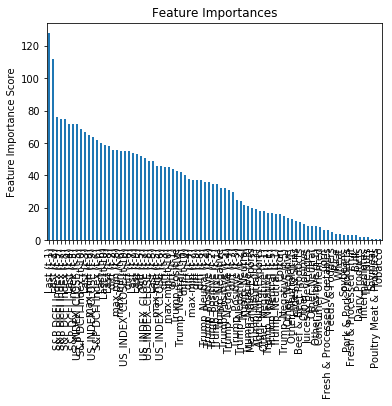

<Figure size 1440x1440 with 0 Axes>


best params 
 {'subsample': 0.6, 'reg_alpha': 0.01, 'n_estimators': 175, 'min_child_weight': 4, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0.2, 'colsample_bytree': 0.8}



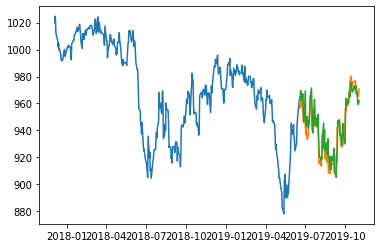


lagging prices by : 11
lagging trump tweets by : 6
lagging tweets by : 3
columns being used:
Index(['Other_Positive', 'Other_Negative', 'Other_Neutral',
       'Agricultural Exports', 'Beef & Beef Products', 'Bulk',
       'Consumer Oriented', 'Corn', 'Cotton', 'Dairy Products',
       'Feeds & Fodders', 'Fresh & Processed Fruit',
       'Fresh & Processed Vegetables', 'Hides & Skins', 'Intermediates',
       'Juices & Beverages', 'Merchandise Exports', 'Pork & Pork Products',
       'Poultry Meat & Products', 'Prepared Food', 'Rice',
       'Soybean & Vegetable Oil', 'Soybeans', 'Soymeal', 'Tobacco',
       'Tree Nuts', 'Wheat', 'Wine & Beer', 'Trump_Positive', 'Trump_Negative',
       'Trump_Neutral', 'Last (t-1)', 'diff (t-1)', 'Last (t-2)', 'diff (t-2)',
       'Last (t-3)', 'diff (t-3)', 'Last (t-4)', 'diff (t-4)', 'Last (t-5)',
       'diff (t-5)', 'Last (t-6)', 'diff (t-6)', 'Last (t-7)', 'diff (t-7)',
       'Last (t-8)', 'diff (t-8)', 'Last (t-9)', 'diff (t-9)', 'Last (t-10)'

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 268 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   10.2s finished


[18:41:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training R-squared:  1.0
Training Explained Variation:  1.0
Training RMSE:  1.49
Training MAE:  0.95  

Test R-squared:  0.82
Test Explained Variation:  0.83
Test RMSE:  8.78
Test MAE:  6.99


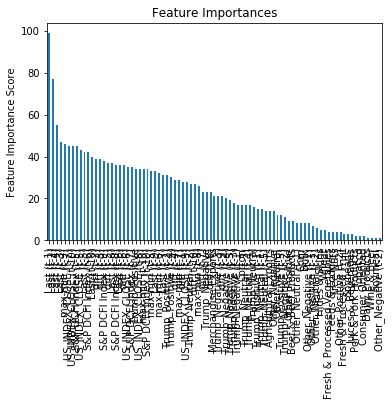

<Figure size 1440x1440 with 0 Axes>


best params 
 {'subsample': 0.6, 'reg_alpha': 1, 'n_estimators': 95, 'min_child_weight': 4, 'max_depth': 18, 'learning_rate': 0.1, 'gamma': 0.3, 'colsample_bytree': 0.7}



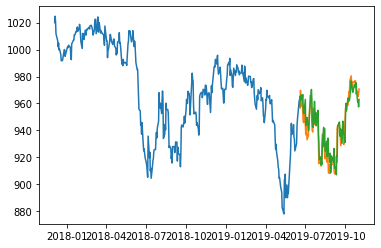


lagging prices by : 11
lagging trump tweets by : 7
lagging tweets by : 1
columns being used:
Index(['Other_Positive', 'Other_Negative', 'Other_Neutral',
       'Agricultural Exports', 'Beef & Beef Products', 'Bulk',
       'Consumer Oriented', 'Corn', 'Cotton', 'Dairy Products',
       'Feeds & Fodders', 'Fresh & Processed Fruit',
       'Fresh & Processed Vegetables', 'Hides & Skins', 'Intermediates',
       'Juices & Beverages', 'Merchandise Exports', 'Pork & Pork Products',
       'Poultry Meat & Products', 'Prepared Food', 'Rice',
       'Soybean & Vegetable Oil', 'Soybeans', 'Soymeal', 'Tobacco',
       'Tree Nuts', 'Wheat', 'Wine & Beer', 'Trump_Positive', 'Trump_Negative',
       'Trump_Neutral', 'Last (t-1)', 'diff (t-1)', 'Last (t-2)', 'diff (t-2)',
       'Last (t-3)', 'diff (t-3)', 'Last (t-4)', 'diff (t-4)', 'Last (t-5)',
       'diff (t-5)', 'Last (t-6)', 'diff (t-6)', 'Last (t-7)', 'diff (t-7)',
       'Last (t-8)', 'diff (t-8)', 'Last (t-9)', 'diff (t-9)', 'Last (t-10)'

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   12.1s finished


[18:42:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training R-squared:  1.0
Training Explained Variation:  1.0
Training RMSE:  1.45
Training MAE:  0.91  

Test R-squared:  0.83
Test Explained Variation:  0.84
Test RMSE:  8.66
Test MAE:  6.98


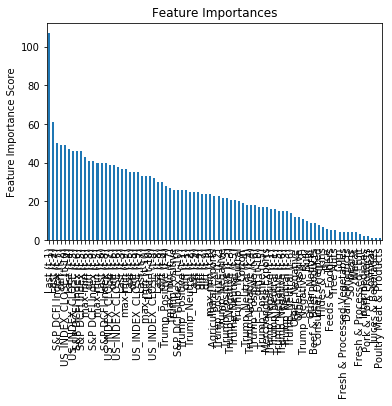

<Figure size 1440x1440 with 0 Axes>


best params 
 {'subsample': 0.6, 'reg_alpha': 1, 'n_estimators': 95, 'min_child_weight': 4, 'max_depth': 18, 'learning_rate': 0.1, 'gamma': 0.3, 'colsample_bytree': 0.7}



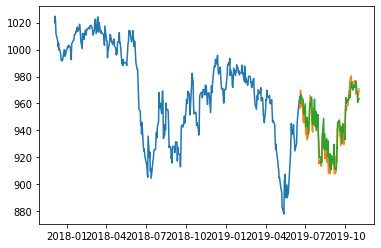


lagging prices by : 11
lagging trump tweets by : 7
lagging tweets by : 2
columns being used:
Index(['Other_Positive', 'Other_Negative', 'Other_Neutral',
       'Agricultural Exports', 'Beef & Beef Products', 'Bulk',
       'Consumer Oriented', 'Corn', 'Cotton', 'Dairy Products',
       'Feeds & Fodders', 'Fresh & Processed Fruit',
       'Fresh & Processed Vegetables', 'Hides & Skins', 'Intermediates',
       'Juices & Beverages', 'Merchandise Exports', 'Pork & Pork Products',
       'Poultry Meat & Products', 'Prepared Food', 'Rice',
       'Soybean & Vegetable Oil', 'Soybeans', 'Soymeal', 'Tobacco',
       'Tree Nuts', 'Wheat', 'Wine & Beer', 'Trump_Positive', 'Trump_Negative',
       'Trump_Neutral', 'Last (t-1)', 'diff (t-1)', 'Last (t-2)', 'diff (t-2)',
       'Last (t-3)', 'diff (t-3)', 'Last (t-4)', 'diff (t-4)', 'Last (t-5)',
       'diff (t-5)', 'Last (t-6)', 'diff (t-6)', 'Last (t-7)', 'diff (t-7)',
       'Last (t-8)', 'diff (t-8)', 'Last (t-9)', 'diff (t-9)', 'Last (t-10)'

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   13.0s finished


[18:42:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training R-squared:  1.0
Training Explained Variation:  1.0
Training RMSE:  0.52
Training MAE:  0.27  

Test R-squared:  0.84
Test Explained Variation:  0.84
Test RMSE:  8.36
Test MAE:  7.03


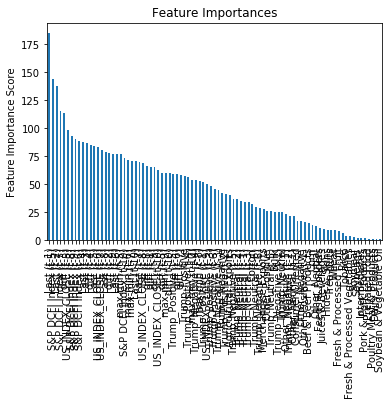

<Figure size 1440x1440 with 0 Axes>


best params 
 {'subsample': 0.7, 'reg_alpha': 1, 'n_estimators': 125, 'min_child_weight': 3, 'max_depth': 17, 'learning_rate': 0.1, 'gamma': 0.0, 'colsample_bytree': 0.8}



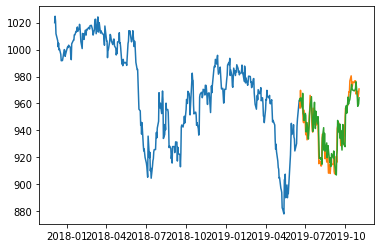


lagging prices by : 11
lagging trump tweets by : 7
lagging tweets by : 3
columns being used:
Index(['Other_Positive', 'Other_Negative', 'Other_Neutral',
       'Agricultural Exports', 'Beef & Beef Products', 'Bulk',
       'Consumer Oriented', 'Corn', 'Cotton', 'Dairy Products',
       'Feeds & Fodders', 'Fresh & Processed Fruit',
       'Fresh & Processed Vegetables', 'Hides & Skins', 'Intermediates',
       'Juices & Beverages', 'Merchandise Exports', 'Pork & Pork Products',
       'Poultry Meat & Products', 'Prepared Food', 'Rice',
       'Soybean & Vegetable Oil', 'Soybeans', 'Soymeal', 'Tobacco',
       'Tree Nuts', 'Wheat', 'Wine & Beer', 'Trump_Positive', 'Trump_Negative',
       'Trump_Neutral', 'Last (t-1)', 'diff (t-1)', 'Last (t-2)', 'diff (t-2)',
       'Last (t-3)', 'diff (t-3)', 'Last (t-4)', 'diff (t-4)', 'Last (t-5)',
       'diff (t-5)', 'Last (t-6)', 'diff (t-6)', 'Last (t-7)', 'diff (t-7)',
       'Last (t-8)', 'diff (t-8)', 'Last (t-9)', 'diff (t-9)', 'Last (t-10)'

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 239 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   11.7s finished


[18:42:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training R-squared:  1.0
Training Explained Variation:  1.0
Training RMSE:  1.49
Training MAE:  0.92  

Test R-squared:  0.82
Test Explained Variation:  0.84
Test RMSE:  8.72
Test MAE:  6.83


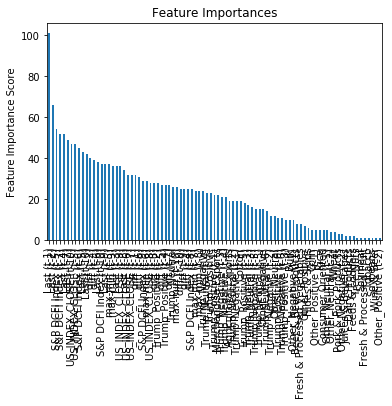

<Figure size 1440x1440 with 0 Axes>


best params 
 {'subsample': 0.6, 'reg_alpha': 1, 'n_estimators': 95, 'min_child_weight': 4, 'max_depth': 18, 'learning_rate': 0.1, 'gamma': 0.3, 'colsample_bytree': 0.7}



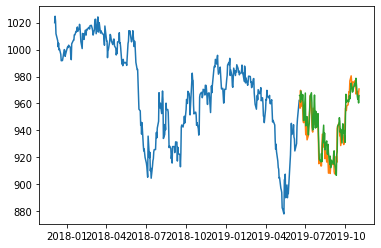


lagging prices by : 11
lagging trump tweets by : 8
lagging tweets by : 1
columns being used:
Index(['Other_Positive', 'Other_Negative', 'Other_Neutral',
       'Agricultural Exports', 'Beef & Beef Products', 'Bulk',
       'Consumer Oriented', 'Corn', 'Cotton', 'Dairy Products',
       'Feeds & Fodders', 'Fresh & Processed Fruit',
       'Fresh & Processed Vegetables', 'Hides & Skins', 'Intermediates',
       'Juices & Beverages', 'Merchandise Exports', 'Pork & Pork Products',
       'Poultry Meat & Products', 'Prepared Food', 'Rice',
       'Soybean & Vegetable Oil', 'Soybeans', 'Soymeal', 'Tobacco',
       'Tree Nuts', 'Wheat', 'Wine & Beer', 'Trump_Positive', 'Trump_Negative',
       'Trump_Neutral', 'Last (t-1)', 'diff (t-1)', 'Last (t-2)', 'diff (t-2)',
       'Last (t-3)', 'diff (t-3)', 'Last (t-4)', 'diff (t-4)', 'Last (t-5)',
       'diff (t-5)', 'Last (t-6)', 'diff (t-6)', 'Last (t-7)', 'diff (t-7)',
       'Last (t-8)', 'diff (t-8)', 'Last (t-9)', 'diff (t-9)', 'Last (t-10)'

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 250 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   11.3s finished


[18:43:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training R-squared:  1.0
Training Explained Variation:  1.0
Training RMSE:  1.56
Training MAE:  0.95  

Test R-squared:  0.84
Test Explained Variation:  0.84
Test RMSE:  8.32
Test MAE:  6.86


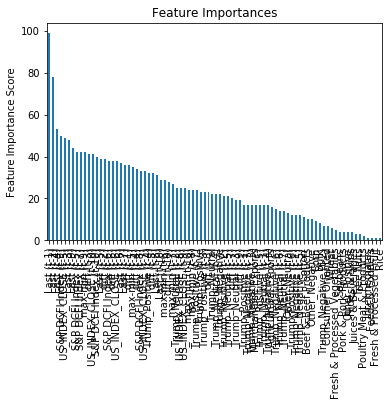

<Figure size 1440x1440 with 0 Axes>


best params 
 {'subsample': 0.6, 'reg_alpha': 1, 'n_estimators': 95, 'min_child_weight': 4, 'max_depth': 18, 'learning_rate': 0.1, 'gamma': 0.3, 'colsample_bytree': 0.7}



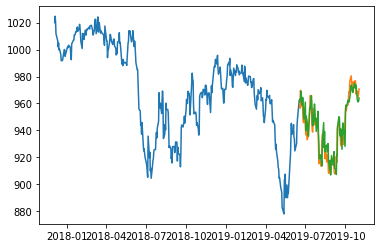


lagging prices by : 11
lagging trump tweets by : 8
lagging tweets by : 2
columns being used:
Index(['Other_Positive', 'Other_Negative', 'Other_Neutral',
       'Agricultural Exports', 'Beef & Beef Products', 'Bulk',
       'Consumer Oriented', 'Corn', 'Cotton', 'Dairy Products',
       'Feeds & Fodders', 'Fresh & Processed Fruit',
       'Fresh & Processed Vegetables', 'Hides & Skins', 'Intermediates',
       'Juices & Beverages', 'Merchandise Exports', 'Pork & Pork Products',
       'Poultry Meat & Products', 'Prepared Food', 'Rice',
       'Soybean & Vegetable Oil', 'Soybeans', 'Soymeal', 'Tobacco',
       'Tree Nuts', 'Wheat', 'Wine & Beer', 'Trump_Positive', 'Trump_Negative',
       'Trump_Neutral', 'Last (t-1)', 'diff (t-1)', 'Last (t-2)', 'diff (t-2)',
       'Last (t-3)', 'diff (t-3)', 'Last (t-4)', 'diff (t-4)', 'Last (t-5)',
       'diff (t-5)', 'Last (t-6)', 'diff (t-6)', 'Last (t-7)', 'diff (t-7)',
       'Last (t-8)', 'diff (t-8)', 'Last (t-9)', 'diff (t-9)', 'Last (t-10)'

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 249 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   11.6s finished


[18:43:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training R-squared:  1.0
Training Explained Variation:  1.0
Training RMSE:  0.41
Training MAE:  0.28  

Test R-squared:  0.82
Test Explained Variation:  0.83
Test RMSE:  8.76
Test MAE:  6.92


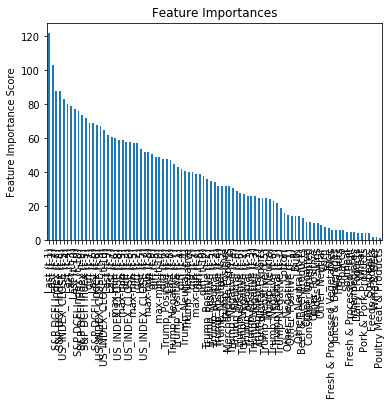

<Figure size 1440x1440 with 0 Axes>


best params 
 {'subsample': 0.6, 'reg_alpha': 1, 'n_estimators': 195, 'min_child_weight': 4, 'max_depth': 8, 'learning_rate': 0.1, 'gamma': 0.4, 'colsample_bytree': 0.7}



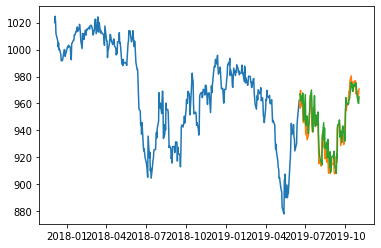


lagging prices by : 11
lagging trump tweets by : 8
lagging tweets by : 3
columns being used:
Index(['Other_Positive', 'Other_Negative', 'Other_Neutral',
       'Agricultural Exports', 'Beef & Beef Products', 'Bulk',
       'Consumer Oriented', 'Corn', 'Cotton', 'Dairy Products',
       'Feeds & Fodders', 'Fresh & Processed Fruit',
       'Fresh & Processed Vegetables', 'Hides & Skins', 'Intermediates',
       'Juices & Beverages', 'Merchandise Exports', 'Pork & Pork Products',
       'Poultry Meat & Products', 'Prepared Food', 'Rice',
       'Soybean & Vegetable Oil', 'Soybeans', 'Soymeal', 'Tobacco',
       'Tree Nuts', 'Wheat', 'Wine & Beer', 'Trump_Positive', 'Trump_Negative',
       'Trump_Neutral', 'Last (t-1)', 'diff (t-1)', 'Last (t-2)', 'diff (t-2)',
       'Last (t-3)', 'diff (t-3)', 'Last (t-4)', 'diff (t-4)', 'Last (t-5)',
       'diff (t-5)', 'Last (t-6)', 'diff (t-6)', 'Last (t-7)', 'diff (t-7)',
       'Last (t-8)', 'diff (t-8)', 'Last (t-9)', 'diff (t-9)', 'Last (t-10)'

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 236 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   12.0s finished


[18:43:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training R-squared:  1.0
Training Explained Variation:  1.0
Training RMSE:  1.5
Training MAE:  0.93  

Test R-squared:  0.84
Test Explained Variation:  0.84
Test RMSE:  8.36
Test MAE:  6.73


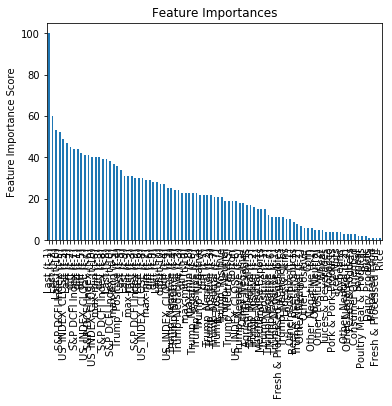

<Figure size 1440x1440 with 0 Axes>


best params 
 {'subsample': 0.6, 'reg_alpha': 1, 'n_estimators': 95, 'min_child_weight': 4, 'max_depth': 18, 'learning_rate': 0.1, 'gamma': 0.3, 'colsample_bytree': 0.7}



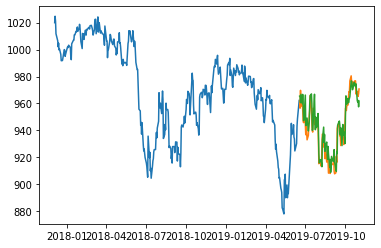


lagging prices by : 11
lagging trump tweets by : 9
lagging tweets by : 1
columns being used:
Index(['Other_Positive', 'Other_Negative', 'Other_Neutral',
       'Agricultural Exports', 'Beef & Beef Products', 'Bulk',
       'Consumer Oriented', 'Corn', 'Cotton', 'Dairy Products',
       'Feeds & Fodders', 'Fresh & Processed Fruit',
       'Fresh & Processed Vegetables', 'Hides & Skins', 'Intermediates',
       'Juices & Beverages', 'Merchandise Exports', 'Pork & Pork Products',
       'Poultry Meat & Products', 'Prepared Food', 'Rice',
       'Soybean & Vegetable Oil', 'Soybeans', 'Soymeal', 'Tobacco',
       'Tree Nuts', 'Wheat', 'Wine & Beer', 'Trump_Positive', 'Trump_Negative',
       'Trump_Neutral', 'Last (t-1)', 'diff (t-1)', 'Last (t-2)', 'diff (t-2)',
       'Last (t-3)', 'diff (t-3)', 'Last (t-4)', 'diff (t-4)', 'Last (t-5)',
       'diff (t-5)', 'Last (t-6)', 'diff (t-6)', 'Last (t-7)', 'diff (t-7)',
       'Last (t-8)', 'diff (t-8)', 'Last (t-9)', 'diff (t-9)', 'Last (t-10)'

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 248 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   11.4s finished


[18:43:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training R-squared:  1.0
Training Explained Variation:  1.0
Training RMSE:  1.33
Training MAE:  0.82  

Test R-squared:  0.82
Test Explained Variation:  0.83
Test RMSE:  8.73
Test MAE:  6.97


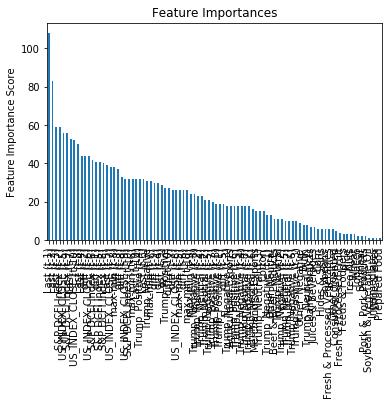

<Figure size 1440x1440 with 0 Axes>


best params 
 {'subsample': 0.6, 'reg_alpha': 0.01, 'n_estimators': 95, 'min_child_weight': 4, 'max_depth': 16, 'learning_rate': 0.1, 'gamma': 0.0, 'colsample_bytree': 0.6}



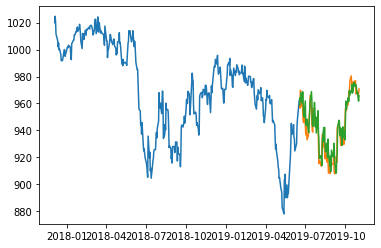


lagging prices by : 11
lagging trump tweets by : 9
lagging tweets by : 2
columns being used:
Index(['Other_Positive', 'Other_Negative', 'Other_Neutral',
       'Agricultural Exports', 'Beef & Beef Products', 'Bulk',
       'Consumer Oriented', 'Corn', 'Cotton', 'Dairy Products',
       'Feeds & Fodders', 'Fresh & Processed Fruit',
       'Fresh & Processed Vegetables', 'Hides & Skins', 'Intermediates',
       'Juices & Beverages', 'Merchandise Exports', 'Pork & Pork Products',
       'Poultry Meat & Products', 'Prepared Food', 'Rice',
       'Soybean & Vegetable Oil', 'Soybeans', 'Soymeal', 'Tobacco',
       'Tree Nuts', 'Wheat', 'Wine & Beer', 'Trump_Positive', 'Trump_Negative',
       'Trump_Neutral', 'Last (t-1)', 'diff (t-1)', 'Last (t-2)', 'diff (t-2)',
       'Last (t-3)', 'diff (t-3)', 'Last (t-4)', 'diff (t-4)', 'Last (t-5)',
       'diff (t-5)', 'Last (t-6)', 'diff (t-6)', 'Last (t-7)', 'diff (t-7)',
       'Last (t-8)', 'diff (t-8)', 'Last (t-9)', 'diff (t-9)', 'Last (t-10)'

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 249 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   11.5s finished


[18:44:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training R-squared:  1.0
Training Explained Variation:  1.0
Training RMSE:  1.37
Training MAE:  0.86  

Test R-squared:  0.8
Test Explained Variation:  0.82
Test RMSE:  9.21
Test MAE:  7.39


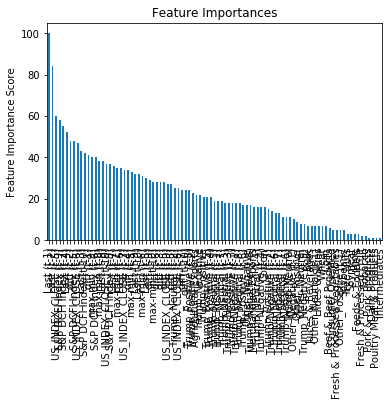

<Figure size 1440x1440 with 0 Axes>


best params 
 {'subsample': 0.6, 'reg_alpha': 0.01, 'n_estimators': 95, 'min_child_weight': 4, 'max_depth': 16, 'learning_rate': 0.1, 'gamma': 0.0, 'colsample_bytree': 0.6}



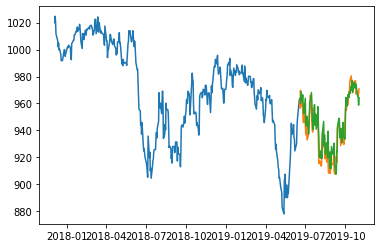


lagging prices by : 11
lagging trump tweets by : 9
lagging tweets by : 3
columns being used:
Index(['Other_Positive', 'Other_Negative', 'Other_Neutral',
       'Agricultural Exports', 'Beef & Beef Products', 'Bulk',
       'Consumer Oriented', 'Corn', 'Cotton', 'Dairy Products',
       'Feeds & Fodders', 'Fresh & Processed Fruit',
       'Fresh & Processed Vegetables', 'Hides & Skins', 'Intermediates',
       'Juices & Beverages', 'Merchandise Exports', 'Pork & Pork Products',
       'Poultry Meat & Products', 'Prepared Food', 'Rice',
       'Soybean & Vegetable Oil', 'Soybeans', 'Soymeal', 'Tobacco',
       'Tree Nuts', 'Wheat', 'Wine & Beer', 'Trump_Positive', 'Trump_Negative',
       'Trump_Neutral', 'Last (t-1)', 'diff (t-1)', 'Last (t-2)', 'diff (t-2)',
       'Last (t-3)', 'diff (t-3)', 'Last (t-4)', 'diff (t-4)', 'Last (t-5)',
       'diff (t-5)', 'Last (t-6)', 'diff (t-6)', 'Last (t-7)', 'diff (t-7)',
       'Last (t-8)', 'diff (t-8)', 'Last (t-9)', 'diff (t-9)', 'Last (t-10)'

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 253 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   11.6s finished


[18:44:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training R-squared:  1.0
Training Explained Variation:  1.0
Training RMSE:  0.41
Training MAE:  0.28  

Test R-squared:  0.81
Test Explained Variation:  0.83
Test RMSE:  8.95
Test MAE:  7.01


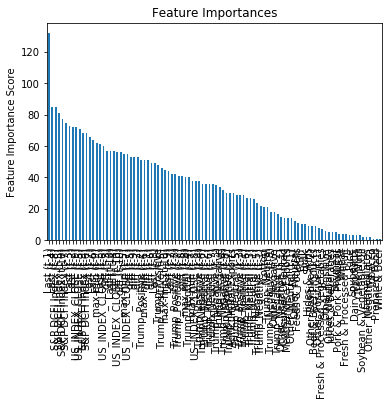

<Figure size 1440x1440 with 0 Axes>


best params 
 {'subsample': 0.6, 'reg_alpha': 1, 'n_estimators': 195, 'min_child_weight': 4, 'max_depth': 8, 'learning_rate': 0.1, 'gamma': 0.4, 'colsample_bytree': 0.7}



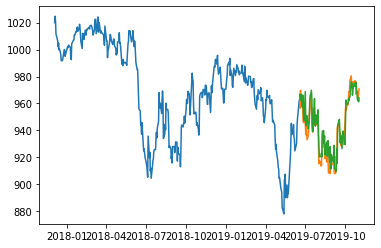


lagging prices by : 11
lagging trump tweets by : 10
lagging tweets by : 1
columns being used:
Index(['Other_Positive', 'Other_Negative', 'Other_Neutral',
       'Agricultural Exports', 'Beef & Beef Products', 'Bulk',
       'Consumer Oriented', 'Corn', 'Cotton', 'Dairy Products',
       'Feeds & Fodders', 'Fresh & Processed Fruit',
       'Fresh & Processed Vegetables', 'Hides & Skins', 'Intermediates',
       'Juices & Beverages', 'Merchandise Exports', 'Pork & Pork Products',
       'Poultry Meat & Products', 'Prepared Food', 'Rice',
       'Soybean & Vegetable Oil', 'Soybeans', 'Soymeal', 'Tobacco',
       'Tree Nuts', 'Wheat', 'Wine & Beer', 'Trump_Positive', 'Trump_Negative',
       'Trump_Neutral', 'Last (t-1)', 'diff (t-1)', 'Last (t-2)', 'diff (t-2)',
       'Last (t-3)', 'diff (t-3)', 'Last (t-4)', 'diff (t-4)', 'Last (t-5)',
       'diff (t-5)', 'Last (t-6)', 'diff (t-6)', 'Last (t-7)', 'diff (t-7)',
       'Last (t-8)', 'diff (t-8)', 'Last (t-9)', 'diff (t-9)', 'Last (t-10)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 247 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   11.7s finished


[18:44:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training R-squared:  0.99
Training Explained Variation:  0.99
Training RMSE:  2.89
Training MAE:  2.24  

Test R-squared:  0.82
Test Explained Variation:  0.83
Test RMSE:  8.69
Test MAE:  6.9


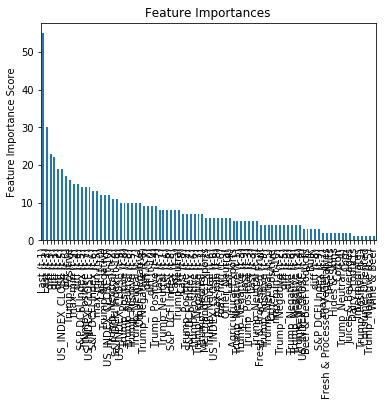

<Figure size 1440x1440 with 0 Axes>


best params 
 {'subsample': 0.6, 'reg_alpha': 1e-05, 'n_estimators': 145, 'min_child_weight': 2, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0.4, 'colsample_bytree': 0.7}



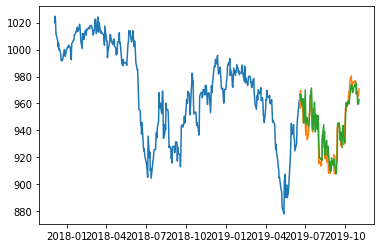


lagging prices by : 11
lagging trump tweets by : 10
lagging tweets by : 2
columns being used:
Index(['Other_Positive', 'Other_Negative', 'Other_Neutral',
       'Agricultural Exports', 'Beef & Beef Products', 'Bulk',
       'Consumer Oriented', 'Corn', 'Cotton', 'Dairy Products',
       'Feeds & Fodders', 'Fresh & Processed Fruit',
       'Fresh & Processed Vegetables', 'Hides & Skins', 'Intermediates',
       'Juices & Beverages', 'Merchandise Exports', 'Pork & Pork Products',
       'Poultry Meat & Products', 'Prepared Food', 'Rice',
       'Soybean & Vegetable Oil', 'Soybeans', 'Soymeal', 'Tobacco',
       'Tree Nuts', 'Wheat', 'Wine & Beer', 'Trump_Positive', 'Trump_Negative',
       'Trump_Neutral', 'Last (t-1)', 'diff (t-1)', 'Last (t-2)', 'diff (t-2)',
       'Last (t-3)', 'diff (t-3)', 'Last (t-4)', 'diff (t-4)', 'Last (t-5)',
       'diff (t-5)', 'Last (t-6)', 'diff (t-6)', 'Last (t-7)', 'diff (t-7)',
       'Last (t-8)', 'diff (t-8)', 'Last (t-9)', 'diff (t-9)', 'Last (t-10)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   11.5s finished


[18:44:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training R-squared:  1.0
Training Explained Variation:  1.0
Training RMSE:  1.46
Training MAE:  0.92  

Test R-squared:  0.83
Test Explained Variation:  0.83
Test RMSE:  8.56
Test MAE:  6.97


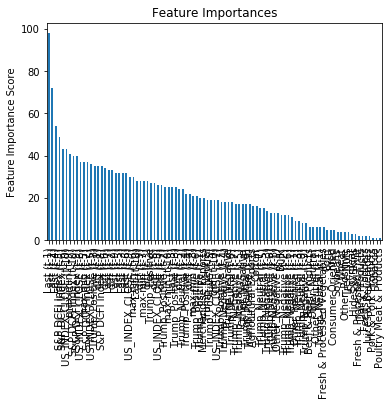

<Figure size 1440x1440 with 0 Axes>


best params 
 {'subsample': 0.6, 'reg_alpha': 1, 'n_estimators': 95, 'min_child_weight': 4, 'max_depth': 18, 'learning_rate': 0.1, 'gamma': 0.3, 'colsample_bytree': 0.7}



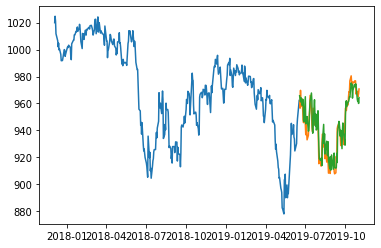


lagging prices by : 11
lagging trump tweets by : 10
lagging tweets by : 3
columns being used:
Index(['Other_Positive', 'Other_Negative', 'Other_Neutral',
       'Agricultural Exports', 'Beef & Beef Products', 'Bulk',
       'Consumer Oriented', 'Corn', 'Cotton', 'Dairy Products',
       ...
       'Trump_Neutral (t-6)', 'Trump_Positive (t-7)', 'Trump_Negative (t-7)',
       'Trump_Neutral (t-7)', 'Trump_Positive (t-8)', 'Trump_Negative (t-8)',
       'Trump_Neutral (t-8)', 'Trump_Positive (t-9)', 'Trump_Negative (t-9)',
       'Trump_Neutral (t-9)'],
      dtype='object', length=102)

               Last
Date               
2017-12-04  1020.00
2017-12-05  1024.75
2017-12-06  1021.00
2017-12-07  1011.75
2017-12-08  1010.50
...             ...
2019-06-11   930.25
2019-06-12   943.25
2019-06-13   948.50
2019-06-14   952.00
2019-06-17   962.25

[386 rows x 1 columns]
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 253 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   11.7s finished


[18:45:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training R-squared:  1.0
Training Explained Variation:  1.0
Training RMSE:  1.18
Training MAE:  0.72  

Test R-squared:  0.69
Test Explained Variation:  0.7
Test RMSE:  11.51
Test MAE:  9.43


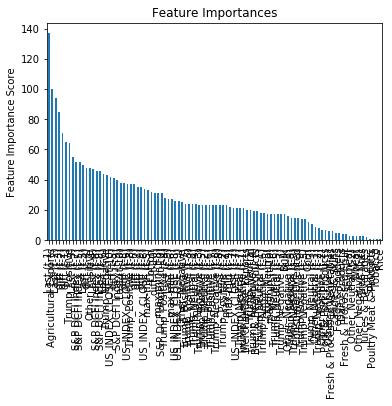

<Figure size 1440x1440 with 0 Axes>


best params 
 {'subsample': 0.6, 'reg_alpha': 1e-05, 'n_estimators': 85, 'min_child_weight': 1, 'max_depth': 19, 'learning_rate': 0.1, 'gamma': 0.4, 'colsample_bytree': 0.7}



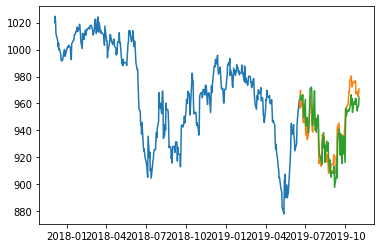


lagging prices by : 11
lagging trump tweets by : 11
lagging tweets by : 1
columns being used:
Index(['Other_Positive', 'Other_Negative', 'Other_Neutral',
       'Agricultural Exports', 'Beef & Beef Products', 'Bulk',
       'Consumer Oriented', 'Corn', 'Cotton', 'Dairy Products',
       'Feeds & Fodders', 'Fresh & Processed Fruit',
       'Fresh & Processed Vegetables', 'Hides & Skins', 'Intermediates',
       'Juices & Beverages', 'Merchandise Exports', 'Pork & Pork Products',
       'Poultry Meat & Products', 'Prepared Food', 'Rice',
       'Soybean & Vegetable Oil', 'Soybeans', 'Soymeal', 'Tobacco',
       'Tree Nuts', 'Wheat', 'Wine & Beer', 'Trump_Positive', 'Trump_Negative',
       'Trump_Neutral', 'Last (t-1)', 'diff (t-1)', 'Last (t-2)', 'diff (t-2)',
       'Last (t-3)', 'diff (t-3)', 'Last (t-4)', 'diff (t-4)', 'Last (t-5)',
       'diff (t-5)', 'Last (t-6)', 'diff (t-6)', 'Last (t-7)', 'diff (t-7)',
       'Last (t-8)', 'diff (t-8)', 'Last (t-9)', 'diff (t-9)', 'Last (t-10)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 250 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   11.8s finished


[18:45:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training R-squared:  1.0
Training Explained Variation:  1.0
Training RMSE:  1.53
Training MAE:  1.08  

Test R-squared:  0.83
Test Explained Variation:  0.83
Test RMSE:  8.61
Test MAE:  6.86


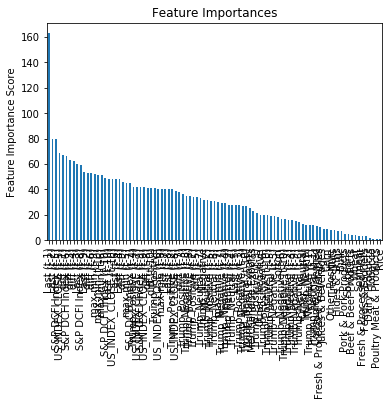

<Figure size 1440x1440 with 0 Axes>


best params 
 {'subsample': 0.6, 'reg_alpha': 1, 'n_estimators': 195, 'min_child_weight': 4, 'max_depth': 9, 'learning_rate': 0.05, 'gamma': 0.3, 'colsample_bytree': 0.9}



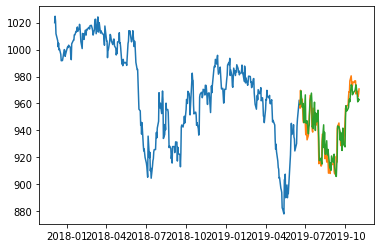


lagging prices by : 11
lagging trump tweets by : 11
lagging tweets by : 2
columns being used:
Index(['Other_Positive', 'Other_Negative', 'Other_Neutral',
       'Agricultural Exports', 'Beef & Beef Products', 'Bulk',
       'Consumer Oriented', 'Corn', 'Cotton', 'Dairy Products',
       ...
       'Trump_Neutral (t-7)', 'Trump_Positive (t-8)', 'Trump_Negative (t-8)',
       'Trump_Neutral (t-8)', 'Trump_Positive (t-9)', 'Trump_Negative (t-9)',
       'Trump_Neutral (t-9)', 'Trump_Positive (t-10)', 'Trump_Negative (t-10)',
       'Trump_Neutral (t-10)'],
      dtype='object', length=102)

               Last
Date               
2017-12-04  1020.00
2017-12-05  1024.75
2017-12-06  1021.00
2017-12-07  1011.75
2017-12-08  1010.50
...             ...
2019-06-11   930.25
2019-06-12   943.25
2019-06-13   948.50
2019-06-14   952.00
2019-06-17   962.25

[386 rows x 1 columns]
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 250 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   11.7s finished


[18:45:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training R-squared:  1.0
Training Explained Variation:  1.0
Training RMSE:  0.41
Training MAE:  0.28  

Test R-squared:  0.81
Test Explained Variation:  0.81
Test RMSE:  9.14
Test MAE:  7.4


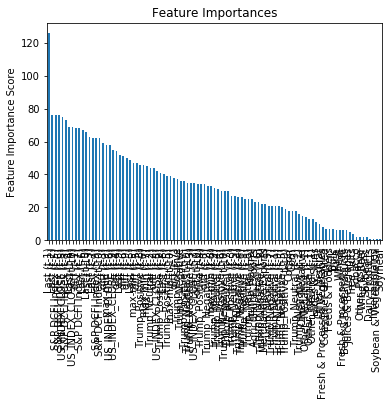

<Figure size 1440x1440 with 0 Axes>


best params 
 {'subsample': 0.6, 'reg_alpha': 1, 'n_estimators': 195, 'min_child_weight': 4, 'max_depth': 8, 'learning_rate': 0.1, 'gamma': 0.4, 'colsample_bytree': 0.7}



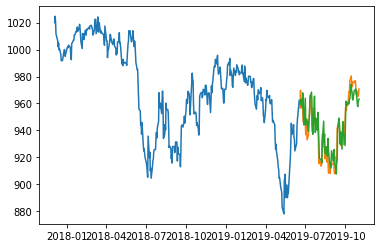


lagging prices by : 11
lagging trump tweets by : 11
lagging tweets by : 3
columns being used:
Index(['Other_Positive', 'Other_Negative', 'Other_Neutral',
       'Agricultural Exports', 'Beef & Beef Products', 'Bulk',
       'Consumer Oriented', 'Corn', 'Cotton', 'Dairy Products',
       ...
       'Trump_Neutral (t-7)', 'Trump_Positive (t-8)', 'Trump_Negative (t-8)',
       'Trump_Neutral (t-8)', 'Trump_Positive (t-9)', 'Trump_Negative (t-9)',
       'Trump_Neutral (t-9)', 'Trump_Positive (t-10)', 'Trump_Negative (t-10)',
       'Trump_Neutral (t-10)'],
      dtype='object', length=105)

               Last
Date               
2017-12-04  1020.00
2017-12-05  1024.75
2017-12-06  1021.00
2017-12-07  1011.75
2017-12-08  1010.50
...             ...
2019-06-11   930.25
2019-06-12   943.25
2019-06-13   948.50
2019-06-14   952.00
2019-06-17   962.25

[386 rows x 1 columns]
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 248 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   11.9s finished


[18:45:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training R-squared:  1.0
Training Explained Variation:  1.0
Training RMSE:  0.4
Training MAE:  0.28  

Test R-squared:  0.79
Test Explained Variation:  0.8
Test RMSE:  9.5
Test MAE:  7.58


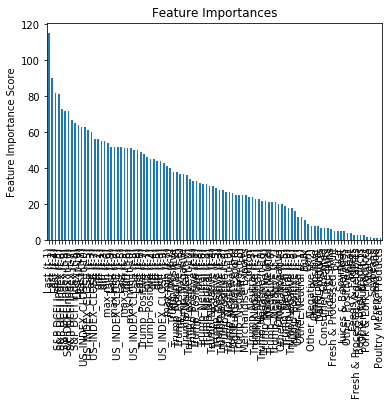

<Figure size 1440x1440 with 0 Axes>


best params 
 {'subsample': 0.6, 'reg_alpha': 1, 'n_estimators': 195, 'min_child_weight': 4, 'max_depth': 8, 'learning_rate': 0.1, 'gamma': 0.4, 'colsample_bytree': 0.7}



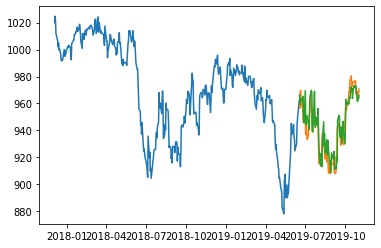


lagging prices by : 12
lagging trump tweets by : 6
lagging tweets by : 1
columns being used:
Index(['Other_Positive', 'Other_Negative', 'Other_Neutral',
       'Agricultural Exports', 'Beef & Beef Products', 'Bulk',
       'Consumer Oriented', 'Corn', 'Cotton', 'Dairy Products',
       'Feeds & Fodders', 'Fresh & Processed Fruit',
       'Fresh & Processed Vegetables', 'Hides & Skins', 'Intermediates',
       'Juices & Beverages', 'Merchandise Exports', 'Pork & Pork Products',
       'Poultry Meat & Products', 'Prepared Food', 'Rice',
       'Soybean & Vegetable Oil', 'Soybeans', 'Soymeal', 'Tobacco',
       'Tree Nuts', 'Wheat', 'Wine & Beer', 'Trump_Positive', 'Trump_Negative',
       'Trump_Neutral', 'Last (t-1)', 'diff (t-1)', 'Last (t-2)', 'diff (t-2)',
       'Last (t-3)', 'diff (t-3)', 'Last (t-4)', 'diff (t-4)', 'Last (t-5)',
       'diff (t-5)', 'Last (t-6)', 'diff (t-6)', 'Last (t-7)', 'diff (t-7)',
       'Last (t-8)', 'diff (t-8)', 'Last (t-9)', 'diff (t-9)', 'Last (t-10)'

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 250 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   11.2s finished


[18:46:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training R-squared:  1.0
Training Explained Variation:  1.0
Training RMSE:  0.85
Training MAE:  0.61  

Test R-squared:  0.83
Test Explained Variation:  0.84
Test RMSE:  8.45
Test MAE:  6.9


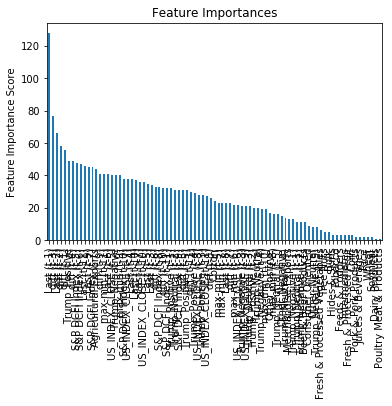

<Figure size 1440x1440 with 0 Axes>


best params 
 {'subsample': 0.9, 'reg_alpha': 1, 'n_estimators': 105, 'min_child_weight': 2, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0.0, 'colsample_bytree': 0.9}



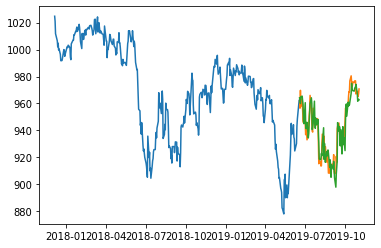


lagging prices by : 12
lagging trump tweets by : 6
lagging tweets by : 2
columns being used:
Index(['Other_Positive', 'Other_Negative', 'Other_Neutral',
       'Agricultural Exports', 'Beef & Beef Products', 'Bulk',
       'Consumer Oriented', 'Corn', 'Cotton', 'Dairy Products',
       'Feeds & Fodders', 'Fresh & Processed Fruit',
       'Fresh & Processed Vegetables', 'Hides & Skins', 'Intermediates',
       'Juices & Beverages', 'Merchandise Exports', 'Pork & Pork Products',
       'Poultry Meat & Products', 'Prepared Food', 'Rice',
       'Soybean & Vegetable Oil', 'Soybeans', 'Soymeal', 'Tobacco',
       'Tree Nuts', 'Wheat', 'Wine & Beer', 'Trump_Positive', 'Trump_Negative',
       'Trump_Neutral', 'Last (t-1)', 'diff (t-1)', 'Last (t-2)', 'diff (t-2)',
       'Last (t-3)', 'diff (t-3)', 'Last (t-4)', 'diff (t-4)', 'Last (t-5)',
       'diff (t-5)', 'Last (t-6)', 'diff (t-6)', 'Last (t-7)', 'diff (t-7)',
       'Last (t-8)', 'diff (t-8)', 'Last (t-9)', 'diff (t-9)', 'Last (t-10)'

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 249 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   11.4s finished


[18:46:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training R-squared:  1.0
Training Explained Variation:  1.0
Training RMSE:  1.58
Training MAE:  1.16  

Test R-squared:  0.81
Test Explained Variation:  0.82
Test RMSE:  8.94
Test MAE:  7.28


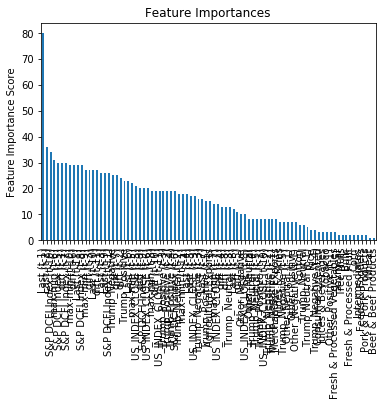

<Figure size 1440x1440 with 0 Axes>


best params 
 {'subsample': 0.8, 'reg_alpha': 1, 'n_estimators': 105, 'min_child_weight': 4, 'max_depth': 6, 'learning_rate': 0.1, 'gamma': 0.2, 'colsample_bytree': 0.8}



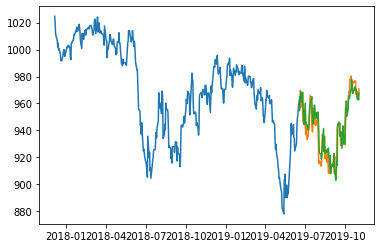


lagging prices by : 12
lagging trump tweets by : 6
lagging tweets by : 3
columns being used:
Index(['Other_Positive', 'Other_Negative', 'Other_Neutral',
       'Agricultural Exports', 'Beef & Beef Products', 'Bulk',
       'Consumer Oriented', 'Corn', 'Cotton', 'Dairy Products',
       'Feeds & Fodders', 'Fresh & Processed Fruit',
       'Fresh & Processed Vegetables', 'Hides & Skins', 'Intermediates',
       'Juices & Beverages', 'Merchandise Exports', 'Pork & Pork Products',
       'Poultry Meat & Products', 'Prepared Food', 'Rice',
       'Soybean & Vegetable Oil', 'Soybeans', 'Soymeal', 'Tobacco',
       'Tree Nuts', 'Wheat', 'Wine & Beer', 'Trump_Positive', 'Trump_Negative',
       'Trump_Neutral', 'Last (t-1)', 'diff (t-1)', 'Last (t-2)', 'diff (t-2)',
       'Last (t-3)', 'diff (t-3)', 'Last (t-4)', 'diff (t-4)', 'Last (t-5)',
       'diff (t-5)', 'Last (t-6)', 'diff (t-6)', 'Last (t-7)', 'diff (t-7)',
       'Last (t-8)', 'diff (t-8)', 'Last (t-9)', 'diff (t-9)', 'Last (t-10)'

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 250 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   11.5s finished


[18:46:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training R-squared:  1.0
Training Explained Variation:  1.0
Training RMSE:  0.41
Training MAE:  0.24  

Test R-squared:  0.83
Test Explained Variation:  0.83
Test RMSE:  8.5
Test MAE:  6.86


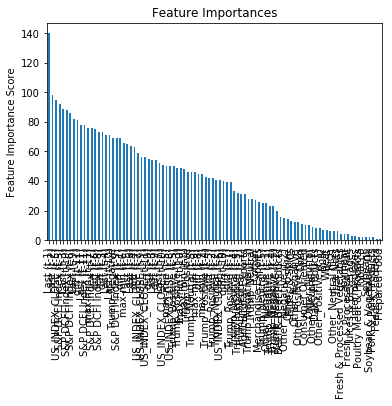

<Figure size 1440x1440 with 0 Axes>


best params 
 {'subsample': 0.8, 'reg_alpha': 1, 'n_estimators': 125, 'min_child_weight': 3, 'max_depth': 12, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.7}



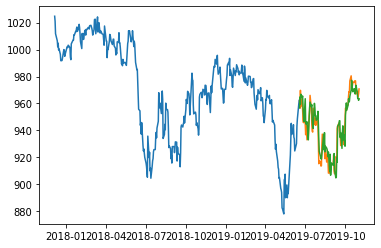


lagging prices by : 12
lagging trump tweets by : 7
lagging tweets by : 1
columns being used:
Index(['Other_Positive', 'Other_Negative', 'Other_Neutral',
       'Agricultural Exports', 'Beef & Beef Products', 'Bulk',
       'Consumer Oriented', 'Corn', 'Cotton', 'Dairy Products',
       'Feeds & Fodders', 'Fresh & Processed Fruit',
       'Fresh & Processed Vegetables', 'Hides & Skins', 'Intermediates',
       'Juices & Beverages', 'Merchandise Exports', 'Pork & Pork Products',
       'Poultry Meat & Products', 'Prepared Food', 'Rice',
       'Soybean & Vegetable Oil', 'Soybeans', 'Soymeal', 'Tobacco',
       'Tree Nuts', 'Wheat', 'Wine & Beer', 'Trump_Positive', 'Trump_Negative',
       'Trump_Neutral', 'Last (t-1)', 'diff (t-1)', 'Last (t-2)', 'diff (t-2)',
       'Last (t-3)', 'diff (t-3)', 'Last (t-4)', 'diff (t-4)', 'Last (t-5)',
       'diff (t-5)', 'Last (t-6)', 'diff (t-6)', 'Last (t-7)', 'diff (t-7)',
       'Last (t-8)', 'diff (t-8)', 'Last (t-9)', 'diff (t-9)', 'Last (t-10)'

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   11.4s finished


[18:46:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training R-squared:  1.0
Training Explained Variation:  1.0
Training RMSE:  1.56
Training MAE:  1.11  

Test R-squared:  0.8
Test Explained Variation:  0.81
Test RMSE:  9.2
Test MAE:  7.41


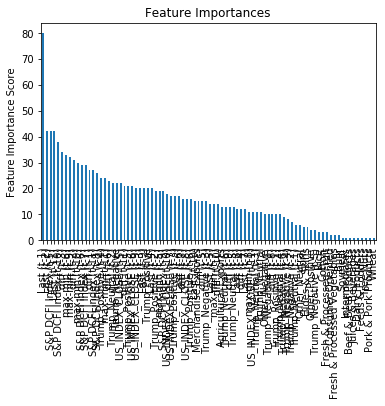

<Figure size 1440x1440 with 0 Axes>


best params 
 {'subsample': 0.8, 'reg_alpha': 1, 'n_estimators': 105, 'min_child_weight': 4, 'max_depth': 6, 'learning_rate': 0.1, 'gamma': 0.2, 'colsample_bytree': 0.8}



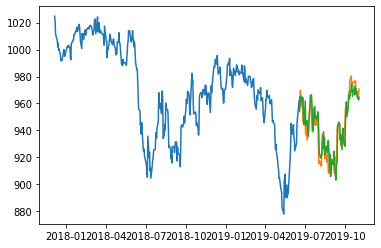


lagging prices by : 12
lagging trump tweets by : 7
lagging tweets by : 2
columns being used:
Index(['Other_Positive', 'Other_Negative', 'Other_Neutral',
       'Agricultural Exports', 'Beef & Beef Products', 'Bulk',
       'Consumer Oriented', 'Corn', 'Cotton', 'Dairy Products',
       'Feeds & Fodders', 'Fresh & Processed Fruit',
       'Fresh & Processed Vegetables', 'Hides & Skins', 'Intermediates',
       'Juices & Beverages', 'Merchandise Exports', 'Pork & Pork Products',
       'Poultry Meat & Products', 'Prepared Food', 'Rice',
       'Soybean & Vegetable Oil', 'Soybeans', 'Soymeal', 'Tobacco',
       'Tree Nuts', 'Wheat', 'Wine & Beer', 'Trump_Positive', 'Trump_Negative',
       'Trump_Neutral', 'Last (t-1)', 'diff (t-1)', 'Last (t-2)', 'diff (t-2)',
       'Last (t-3)', 'diff (t-3)', 'Last (t-4)', 'diff (t-4)', 'Last (t-5)',
       'diff (t-5)', 'Last (t-6)', 'diff (t-6)', 'Last (t-7)', 'diff (t-7)',
       'Last (t-8)', 'diff (t-8)', 'Last (t-9)', 'diff (t-9)', 'Last (t-10)'

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   11.3s finished


[18:47:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training R-squared:  1.0
Training Explained Variation:  1.0
Training RMSE:  0.67
Training MAE:  0.49  

Test R-squared:  0.81
Test Explained Variation:  0.82
Test RMSE:  8.96
Test MAE:  7.17


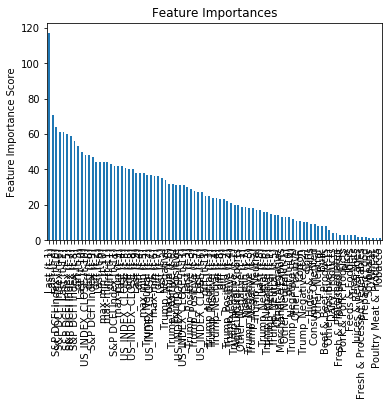

<Figure size 1440x1440 with 0 Axes>


best params 
 {'subsample': 0.8, 'reg_alpha': 1, 'n_estimators': 145, 'min_child_weight': 3, 'max_depth': 6, 'learning_rate': 0.1, 'gamma': 0.2, 'colsample_bytree': 0.7}



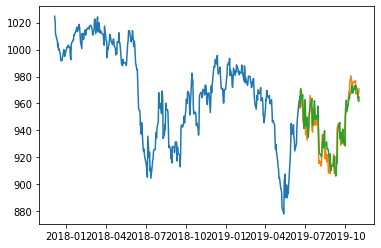


lagging prices by : 12
lagging trump tweets by : 7
lagging tweets by : 3
columns being used:
Index(['Other_Positive', 'Other_Negative', 'Other_Neutral',
       'Agricultural Exports', 'Beef & Beef Products', 'Bulk',
       'Consumer Oriented', 'Corn', 'Cotton', 'Dairy Products',
       'Feeds & Fodders', 'Fresh & Processed Fruit',
       'Fresh & Processed Vegetables', 'Hides & Skins', 'Intermediates',
       'Juices & Beverages', 'Merchandise Exports', 'Pork & Pork Products',
       'Poultry Meat & Products', 'Prepared Food', 'Rice',
       'Soybean & Vegetable Oil', 'Soybeans', 'Soymeal', 'Tobacco',
       'Tree Nuts', 'Wheat', 'Wine & Beer', 'Trump_Positive', 'Trump_Negative',
       'Trump_Neutral', 'Last (t-1)', 'diff (t-1)', 'Last (t-2)', 'diff (t-2)',
       'Last (t-3)', 'diff (t-3)', 'Last (t-4)', 'diff (t-4)', 'Last (t-5)',
       'diff (t-5)', 'Last (t-6)', 'diff (t-6)', 'Last (t-7)', 'diff (t-7)',
       'Last (t-8)', 'diff (t-8)', 'Last (t-9)', 'diff (t-9)', 'Last (t-10)'

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 250 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   11.6s finished


[18:47:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training R-squared:  1.0
Training Explained Variation:  1.0
Training RMSE:  0.84
Training MAE:  0.6  

Test R-squared:  0.82
Test Explained Variation:  0.82
Test RMSE:  8.78
Test MAE:  7.33


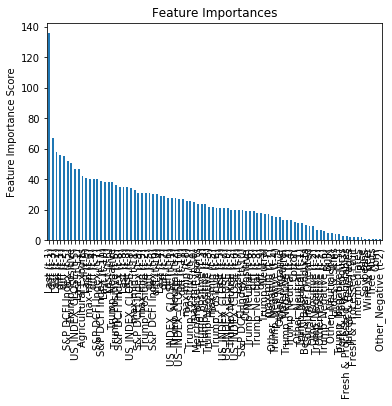

<Figure size 1440x1440 with 0 Axes>


best params 
 {'subsample': 0.9, 'reg_alpha': 1, 'n_estimators': 105, 'min_child_weight': 2, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0.0, 'colsample_bytree': 0.9}



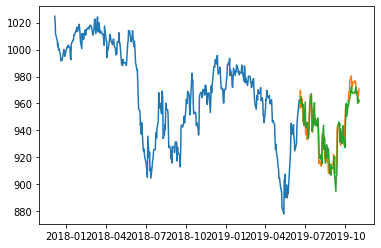


lagging prices by : 12
lagging trump tweets by : 8
lagging tweets by : 1
columns being used:
Index(['Other_Positive', 'Other_Negative', 'Other_Neutral',
       'Agricultural Exports', 'Beef & Beef Products', 'Bulk',
       'Consumer Oriented', 'Corn', 'Cotton', 'Dairy Products',
       'Feeds & Fodders', 'Fresh & Processed Fruit',
       'Fresh & Processed Vegetables', 'Hides & Skins', 'Intermediates',
       'Juices & Beverages', 'Merchandise Exports', 'Pork & Pork Products',
       'Poultry Meat & Products', 'Prepared Food', 'Rice',
       'Soybean & Vegetable Oil', 'Soybeans', 'Soymeal', 'Tobacco',
       'Tree Nuts', 'Wheat', 'Wine & Beer', 'Trump_Positive', 'Trump_Negative',
       'Trump_Neutral', 'Last (t-1)', 'diff (t-1)', 'Last (t-2)', 'diff (t-2)',
       'Last (t-3)', 'diff (t-3)', 'Last (t-4)', 'diff (t-4)', 'Last (t-5)',
       'diff (t-5)', 'Last (t-6)', 'diff (t-6)', 'Last (t-7)', 'diff (t-7)',
       'Last (t-8)', 'diff (t-8)', 'Last (t-9)', 'diff (t-9)', 'Last (t-10)'

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 250 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   11.8s finished


[18:47:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training R-squared:  1.0
Training Explained Variation:  1.0
Training RMSE:  1.62
Training MAE:  1.2  

Test R-squared:  0.82
Test Explained Variation:  0.83
Test RMSE:  8.69
Test MAE:  7.15


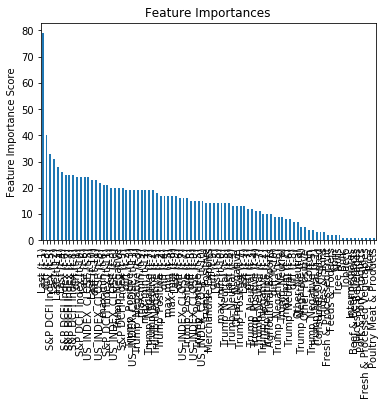

<Figure size 1440x1440 with 0 Axes>


best params 
 {'subsample': 0.8, 'reg_alpha': 1, 'n_estimators': 105, 'min_child_weight': 4, 'max_depth': 6, 'learning_rate': 0.1, 'gamma': 0.2, 'colsample_bytree': 0.8}



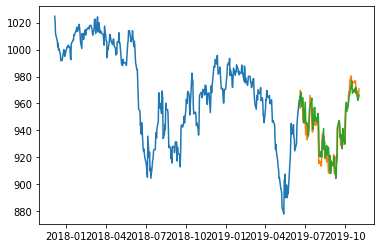


lagging prices by : 12
lagging trump tweets by : 8
lagging tweets by : 2
columns being used:
Index(['Other_Positive', 'Other_Negative', 'Other_Neutral',
       'Agricultural Exports', 'Beef & Beef Products', 'Bulk',
       'Consumer Oriented', 'Corn', 'Cotton', 'Dairy Products',
       'Feeds & Fodders', 'Fresh & Processed Fruit',
       'Fresh & Processed Vegetables', 'Hides & Skins', 'Intermediates',
       'Juices & Beverages', 'Merchandise Exports', 'Pork & Pork Products',
       'Poultry Meat & Products', 'Prepared Food', 'Rice',
       'Soybean & Vegetable Oil', 'Soybeans', 'Soymeal', 'Tobacco',
       'Tree Nuts', 'Wheat', 'Wine & Beer', 'Trump_Positive', 'Trump_Negative',
       'Trump_Neutral', 'Last (t-1)', 'diff (t-1)', 'Last (t-2)', 'diff (t-2)',
       'Last (t-3)', 'diff (t-3)', 'Last (t-4)', 'diff (t-4)', 'Last (t-5)',
       'diff (t-5)', 'Last (t-6)', 'diff (t-6)', 'Last (t-7)', 'diff (t-7)',
       'Last (t-8)', 'diff (t-8)', 'Last (t-9)', 'diff (t-9)', 'Last (t-10)'

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 250 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   12.0s finished


[18:47:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training R-squared:  1.0
Training Explained Variation:  1.0
Training RMSE:  2.01
Training MAE:  1.39  

Test R-squared:  0.79
Test Explained Variation:  0.8
Test RMSE:  9.54
Test MAE:  7.93


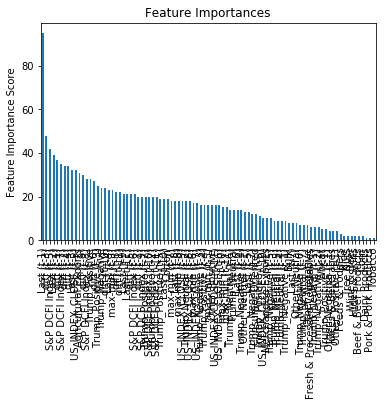

<Figure size 1440x1440 with 0 Axes>


best params 
 {'subsample': 0.6, 'reg_alpha': 1, 'n_estimators': 75, 'min_child_weight': 2, 'max_depth': 12, 'learning_rate': 0.1, 'gamma': 0.3, 'colsample_bytree': 0.9}



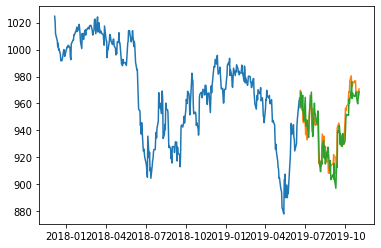


lagging prices by : 12
lagging trump tweets by : 8
lagging tweets by : 3
columns being used:
Index(['Other_Positive', 'Other_Negative', 'Other_Neutral',
       'Agricultural Exports', 'Beef & Beef Products', 'Bulk',
       'Consumer Oriented', 'Corn', 'Cotton', 'Dairy Products',
       ...
       'Trump_Neutral (t-4)', 'Trump_Positive (t-5)', 'Trump_Negative (t-5)',
       'Trump_Neutral (t-5)', 'Trump_Positive (t-6)', 'Trump_Negative (t-6)',
       'Trump_Neutral (t-6)', 'Trump_Positive (t-7)', 'Trump_Negative (t-7)',
       'Trump_Neutral (t-7)'],
      dtype='object', length=101)

               Last
Date               
2017-12-05  1024.75
2017-12-06  1021.00
2017-12-07  1011.75
2017-12-08  1010.50
2017-12-11  1006.50
...             ...
2019-06-11   930.25
2019-06-12   943.25
2019-06-13   948.50
2019-06-14   952.00
2019-06-17   962.25

[385 rows x 1 columns]
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 265 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   10.4s finished


[18:48:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training R-squared:  1.0
Training Explained Variation:  1.0
Training RMSE:  0.23
Training MAE:  0.16  

Test R-squared:  0.81
Test Explained Variation:  0.81
Test RMSE:  8.97
Test MAE:  7.37


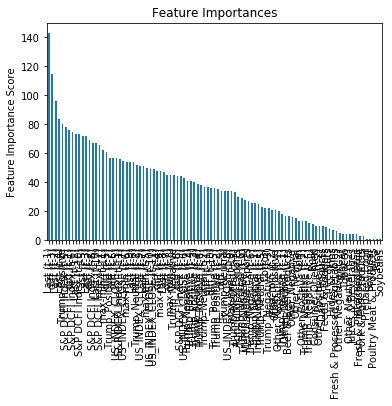

<Figure size 1440x1440 with 0 Axes>


best params 
 {'subsample': 0.8, 'reg_alpha': 0.01, 'n_estimators': 135, 'min_child_weight': 2, 'max_depth': 16, 'learning_rate': 0.1, 'gamma': 0.4, 'colsample_bytree': 0.6}



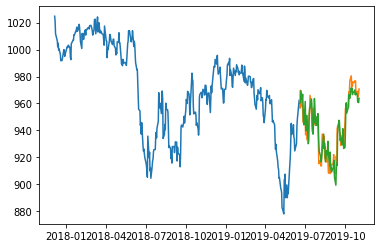


lagging prices by : 12
lagging trump tweets by : 9
lagging tweets by : 1
columns being used:
Index(['Other_Positive', 'Other_Negative', 'Other_Neutral',
       'Agricultural Exports', 'Beef & Beef Products', 'Bulk',
       'Consumer Oriented', 'Corn', 'Cotton', 'Dairy Products',
       'Feeds & Fodders', 'Fresh & Processed Fruit',
       'Fresh & Processed Vegetables', 'Hides & Skins', 'Intermediates',
       'Juices & Beverages', 'Merchandise Exports', 'Pork & Pork Products',
       'Poultry Meat & Products', 'Prepared Food', 'Rice',
       'Soybean & Vegetable Oil', 'Soybeans', 'Soymeal', 'Tobacco',
       'Tree Nuts', 'Wheat', 'Wine & Beer', 'Trump_Positive', 'Trump_Negative',
       'Trump_Neutral', 'Last (t-1)', 'diff (t-1)', 'Last (t-2)', 'diff (t-2)',
       'Last (t-3)', 'diff (t-3)', 'Last (t-4)', 'diff (t-4)', 'Last (t-5)',
       'diff (t-5)', 'Last (t-6)', 'diff (t-6)', 'Last (t-7)', 'diff (t-7)',
       'Last (t-8)', 'diff (t-8)', 'Last (t-9)', 'diff (t-9)', 'Last (t-10)'

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    9.7s finished


[18:48:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training R-squared:  1.0
Training Explained Variation:  1.0
Training RMSE:  1.94
Training MAE:  1.28  

Test R-squared:  0.86
Test Explained Variation:  0.86
Test RMSE:  7.85
Test MAE:  6.32


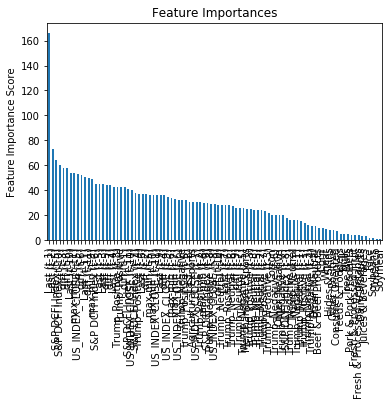

<Figure size 1440x1440 with 0 Axes>


best params 
 {'subsample': 0.7, 'reg_alpha': 1, 'n_estimators': 155, 'min_child_weight': 4, 'max_depth': 16, 'learning_rate': 0.05, 'gamma': 0.4, 'colsample_bytree': 0.7}



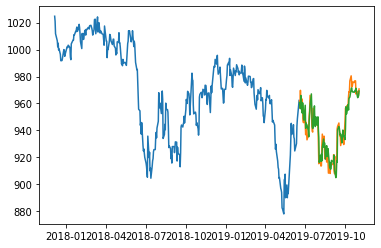


lagging prices by : 12
lagging trump tweets by : 9
lagging tweets by : 2
columns being used:
Index(['Other_Positive', 'Other_Negative', 'Other_Neutral',
       'Agricultural Exports', 'Beef & Beef Products', 'Bulk',
       'Consumer Oriented', 'Corn', 'Cotton', 'Dairy Products',
       ...
       'Trump_Neutral (t-5)', 'Trump_Positive (t-6)', 'Trump_Negative (t-6)',
       'Trump_Neutral (t-6)', 'Trump_Positive (t-7)', 'Trump_Negative (t-7)',
       'Trump_Neutral (t-7)', 'Trump_Positive (t-8)', 'Trump_Negative (t-8)',
       'Trump_Neutral (t-8)'],
      dtype='object', length=101)

               Last
Date               
2017-12-05  1024.75
2017-12-06  1021.00
2017-12-07  1011.75
2017-12-08  1010.50
2017-12-11  1006.50
...             ...
2019-06-11   930.25
2019-06-12   943.25
2019-06-13   948.50
2019-06-14   952.00
2019-06-17   962.25

[385 rows x 1 columns]
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   11.7s finished


[18:48:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training R-squared:  1.0
Training Explained Variation:  1.0
Training RMSE:  0.83
Training MAE:  0.59  

Test R-squared:  0.83
Test Explained Variation:  0.84
Test RMSE:  8.55
Test MAE:  6.75


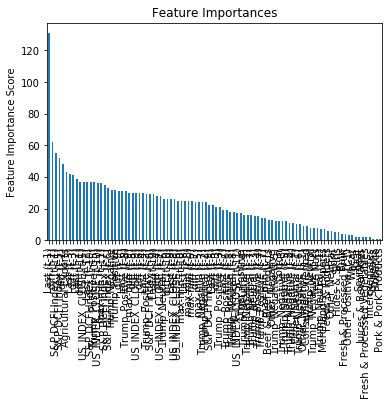

<Figure size 1440x1440 with 0 Axes>


best params 
 {'subsample': 0.9, 'reg_alpha': 1, 'n_estimators': 105, 'min_child_weight': 2, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0.0, 'colsample_bytree': 0.9}



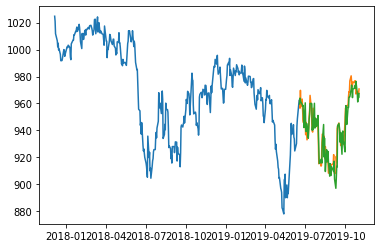


lagging prices by : 12
lagging trump tweets by : 9
lagging tweets by : 3
columns being used:
Index(['Other_Positive', 'Other_Negative', 'Other_Neutral',
       'Agricultural Exports', 'Beef & Beef Products', 'Bulk',
       'Consumer Oriented', 'Corn', 'Cotton', 'Dairy Products',
       ...
       'Trump_Neutral (t-5)', 'Trump_Positive (t-6)', 'Trump_Negative (t-6)',
       'Trump_Neutral (t-6)', 'Trump_Positive (t-7)', 'Trump_Negative (t-7)',
       'Trump_Neutral (t-7)', 'Trump_Positive (t-8)', 'Trump_Negative (t-8)',
       'Trump_Neutral (t-8)'],
      dtype='object', length=104)

               Last
Date               
2017-12-05  1024.75
2017-12-06  1021.00
2017-12-07  1011.75
2017-12-08  1010.50
2017-12-11  1006.50
...             ...
2019-06-11   930.25
2019-06-12   943.25
2019-06-13   948.50
2019-06-14   952.00
2019-06-17   962.25

[385 rows x 1 columns]
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   15.8s finished


[18:48:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training R-squared:  1.0
Training Explained Variation:  1.0
Training RMSE:  1.64
Training MAE:  1.09  

Test R-squared:  0.84
Test Explained Variation:  0.84
Test RMSE:  8.23
Test MAE:  6.68


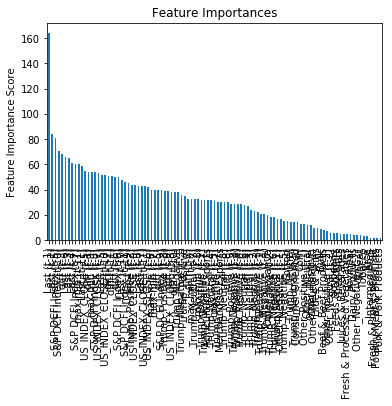

<Figure size 1440x1440 with 0 Axes>


best params 
 {'subsample': 0.6, 'reg_alpha': 0.1, 'n_estimators': 175, 'min_child_weight': 4, 'max_depth': 13, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 0.6}



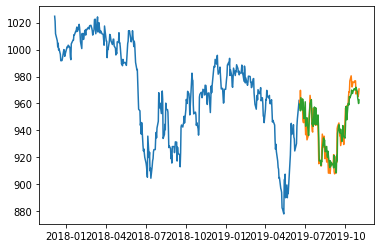


lagging prices by : 12
lagging trump tweets by : 10
lagging tweets by : 1
columns being used:
Index(['Other_Positive', 'Other_Negative', 'Other_Neutral',
       'Agricultural Exports', 'Beef & Beef Products', 'Bulk',
       'Consumer Oriented', 'Corn', 'Cotton', 'Dairy Products',
       ...
       'Trump_Neutral (t-6)', 'Trump_Positive (t-7)', 'Trump_Negative (t-7)',
       'Trump_Neutral (t-7)', 'Trump_Positive (t-8)', 'Trump_Negative (t-8)',
       'Trump_Neutral (t-8)', 'Trump_Positive (t-9)', 'Trump_Negative (t-9)',
       'Trump_Neutral (t-9)'],
      dtype='object', length=101)

               Last
Date               
2017-12-05  1024.75
2017-12-06  1021.00
2017-12-07  1011.75
2017-12-08  1010.50
2017-12-11  1006.50
...             ...
2019-06-11   930.25
2019-06-12   943.25
2019-06-13   948.50
2019-06-14   952.00
2019-06-17   962.25

[385 rows x 1 columns]
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   17.7s finished


[18:49:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training R-squared:  1.0
Training Explained Variation:  1.0
Training RMSE:  1.68
Training MAE:  1.1  

Test R-squared:  0.84
Test Explained Variation:  0.84
Test RMSE:  8.31
Test MAE:  6.61


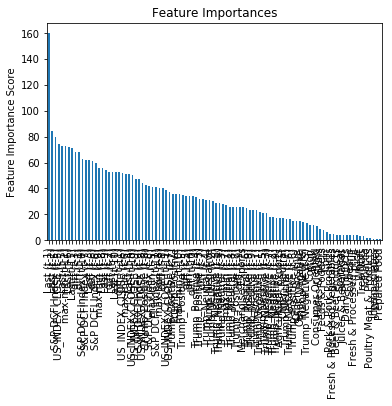

<Figure size 1440x1440 with 0 Axes>


best params 
 {'subsample': 0.6, 'reg_alpha': 0.1, 'n_estimators': 175, 'min_child_weight': 4, 'max_depth': 13, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 0.6}



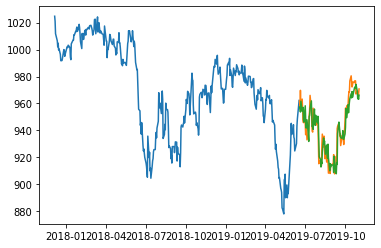


lagging prices by : 12
lagging trump tweets by : 10
lagging tweets by : 2
columns being used:
Index(['Other_Positive', 'Other_Negative', 'Other_Neutral',
       'Agricultural Exports', 'Beef & Beef Products', 'Bulk',
       'Consumer Oriented', 'Corn', 'Cotton', 'Dairy Products',
       ...
       'Trump_Neutral (t-6)', 'Trump_Positive (t-7)', 'Trump_Negative (t-7)',
       'Trump_Neutral (t-7)', 'Trump_Positive (t-8)', 'Trump_Negative (t-8)',
       'Trump_Neutral (t-8)', 'Trump_Positive (t-9)', 'Trump_Negative (t-9)',
       'Trump_Neutral (t-9)'],
      dtype='object', length=104)

               Last
Date               
2017-12-05  1024.75
2017-12-06  1021.00
2017-12-07  1011.75
2017-12-08  1010.50
2017-12-11  1006.50
...             ...
2019-06-11   930.25
2019-06-12   943.25
2019-06-13   948.50
2019-06-14   952.00
2019-06-17   962.25

[385 rows x 1 columns]
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 210 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   18.4s finished


[18:49:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training R-squared:  1.0
Training Explained Variation:  1.0
Training RMSE:  0.83
Training MAE:  0.58  

Test R-squared:  0.84
Test Explained Variation:  0.84
Test RMSE:  8.37
Test MAE:  6.79


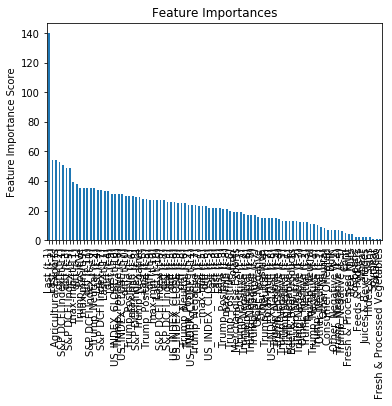

<Figure size 1440x1440 with 0 Axes>


best params 
 {'subsample': 0.9, 'reg_alpha': 1, 'n_estimators': 105, 'min_child_weight': 2, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0.0, 'colsample_bytree': 0.9}



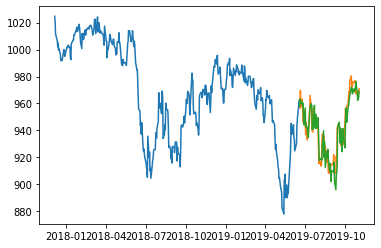


lagging prices by : 12
lagging trump tweets by : 10
lagging tweets by : 3
columns being used:
Index(['Other_Positive', 'Other_Negative', 'Other_Neutral',
       'Agricultural Exports', 'Beef & Beef Products', 'Bulk',
       'Consumer Oriented', 'Corn', 'Cotton', 'Dairy Products',
       ...
       'Trump_Neutral (t-6)', 'Trump_Positive (t-7)', 'Trump_Negative (t-7)',
       'Trump_Neutral (t-7)', 'Trump_Positive (t-8)', 'Trump_Negative (t-8)',
       'Trump_Neutral (t-8)', 'Trump_Positive (t-9)', 'Trump_Negative (t-9)',
       'Trump_Neutral (t-9)'],
      dtype='object', length=107)

               Last
Date               
2017-12-05  1024.75
2017-12-06  1021.00
2017-12-07  1011.75
2017-12-08  1010.50
2017-12-11  1006.50
...             ...
2019-06-11   930.25
2019-06-12   943.25
2019-06-13   948.50
2019-06-14   952.00
2019-06-17   962.25

[385 rows x 1 columns]
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   12.9s finished


[18:49:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training R-squared:  1.0
Training Explained Variation:  1.0
Training RMSE:  0.21
Training MAE:  0.16  

Test R-squared:  0.78
Test Explained Variation:  0.79
Test RMSE:  9.66
Test MAE:  7.95


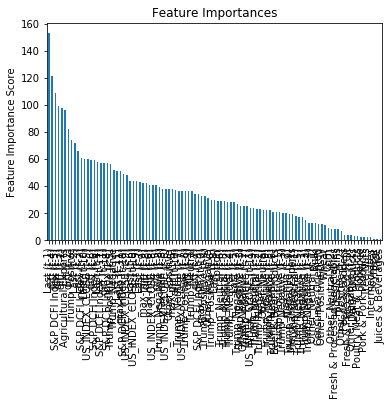

<Figure size 1440x1440 with 0 Axes>


best params 
 {'subsample': 0.8, 'reg_alpha': 0.1, 'n_estimators': 175, 'min_child_weight': 1, 'max_depth': 13, 'learning_rate': 0.1, 'gamma': 0.4, 'colsample_bytree': 0.8}



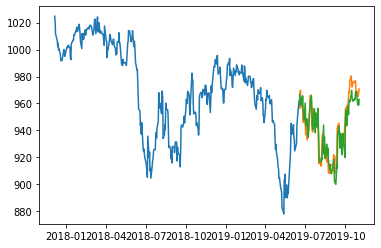


lagging prices by : 12
lagging trump tweets by : 11
lagging tweets by : 1
columns being used:
Index(['Other_Positive', 'Other_Negative', 'Other_Neutral',
       'Agricultural Exports', 'Beef & Beef Products', 'Bulk',
       'Consumer Oriented', 'Corn', 'Cotton', 'Dairy Products',
       ...
       'Trump_Neutral (t-7)', 'Trump_Positive (t-8)', 'Trump_Negative (t-8)',
       'Trump_Neutral (t-8)', 'Trump_Positive (t-9)', 'Trump_Negative (t-9)',
       'Trump_Neutral (t-9)', 'Trump_Positive (t-10)', 'Trump_Negative (t-10)',
       'Trump_Neutral (t-10)'],
      dtype='object', length=104)

               Last
Date               
2017-12-05  1024.75
2017-12-06  1021.00
2017-12-07  1011.75
2017-12-08  1010.50
2017-12-11  1006.50
...             ...
2019-06-11   930.25
2019-06-12   943.25
2019-06-13   948.50
2019-06-14   952.00
2019-06-17   962.25

[385 rows x 1 columns]
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    9.2s finished


[18:49:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training R-squared:  1.0
Training Explained Variation:  1.0
Training RMSE:  0.21
Training MAE:  0.15  

Test R-squared:  0.83
Test Explained Variation:  0.84
Test RMSE:  8.42
Test MAE:  6.86


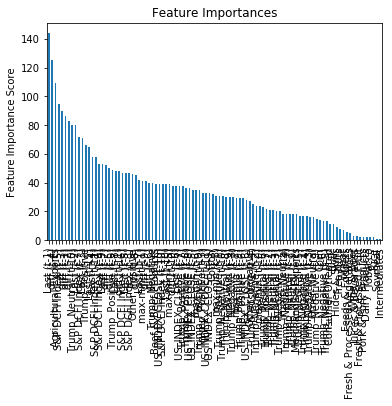

<Figure size 1440x1440 with 0 Axes>


best params 
 {'subsample': 0.8, 'reg_alpha': 0.1, 'n_estimators': 175, 'min_child_weight': 1, 'max_depth': 13, 'learning_rate': 0.1, 'gamma': 0.4, 'colsample_bytree': 0.8}



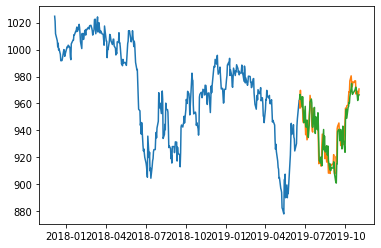


lagging prices by : 12
lagging trump tweets by : 11
lagging tweets by : 2
columns being used:
Index(['Other_Positive', 'Other_Negative', 'Other_Neutral',
       'Agricultural Exports', 'Beef & Beef Products', 'Bulk',
       'Consumer Oriented', 'Corn', 'Cotton', 'Dairy Products',
       ...
       'Trump_Neutral (t-7)', 'Trump_Positive (t-8)', 'Trump_Negative (t-8)',
       'Trump_Neutral (t-8)', 'Trump_Positive (t-9)', 'Trump_Negative (t-9)',
       'Trump_Neutral (t-9)', 'Trump_Positive (t-10)', 'Trump_Negative (t-10)',
       'Trump_Neutral (t-10)'],
      dtype='object', length=107)

               Last
Date               
2017-12-05  1024.75
2017-12-06  1021.00
2017-12-07  1011.75
2017-12-08  1010.50
2017-12-11  1006.50
...             ...
2019-06-11   930.25
2019-06-12   943.25
2019-06-13   948.50
2019-06-14   952.00
2019-06-17   962.25

[385 rows x 1 columns]
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   15.6s finished


[18:50:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training R-squared:  1.0
Training Explained Variation:  1.0
Training RMSE:  0.24
Training MAE:  0.17  

Test R-squared:  0.82
Test Explained Variation:  0.82
Test RMSE:  8.87
Test MAE:  7.04


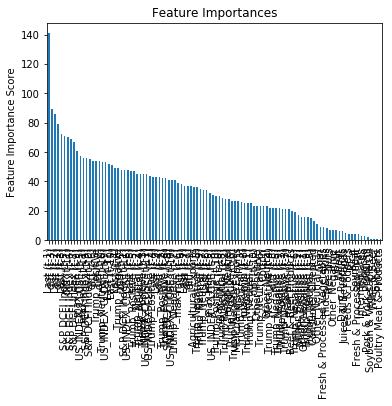

<Figure size 1440x1440 with 0 Axes>


best params 
 {'subsample': 0.8, 'reg_alpha': 0.01, 'n_estimators': 135, 'min_child_weight': 2, 'max_depth': 16, 'learning_rate': 0.1, 'gamma': 0.4, 'colsample_bytree': 0.6}



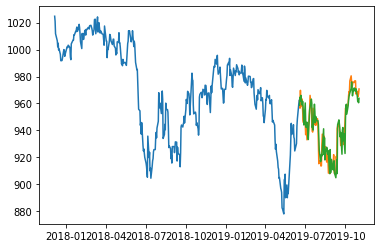


lagging prices by : 12
lagging trump tweets by : 11
lagging tweets by : 3
columns being used:
Index(['Other_Positive', 'Other_Negative', 'Other_Neutral',
       'Agricultural Exports', 'Beef & Beef Products', 'Bulk',
       'Consumer Oriented', 'Corn', 'Cotton', 'Dairy Products',
       ...
       'Trump_Neutral (t-7)', 'Trump_Positive (t-8)', 'Trump_Negative (t-8)',
       'Trump_Neutral (t-8)', 'Trump_Positive (t-9)', 'Trump_Negative (t-9)',
       'Trump_Neutral (t-9)', 'Trump_Positive (t-10)', 'Trump_Negative (t-10)',
       'Trump_Neutral (t-10)'],
      dtype='object', length=110)

               Last
Date               
2017-12-05  1024.75
2017-12-06  1021.00
2017-12-07  1011.75
2017-12-08  1010.50
2017-12-11  1006.50
...             ...
2019-06-11   930.25
2019-06-12   943.25
2019-06-13   948.50
2019-06-14   952.00
2019-06-17   962.25

[385 rows x 1 columns]
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   17.9s finished


[18:50:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training R-squared:  1.0
Training Explained Variation:  1.0
Training RMSE:  1.9
Training MAE:  1.25  

Test R-squared:  0.84
Test Explained Variation:  0.84
Test RMSE:  8.25
Test MAE:  6.9


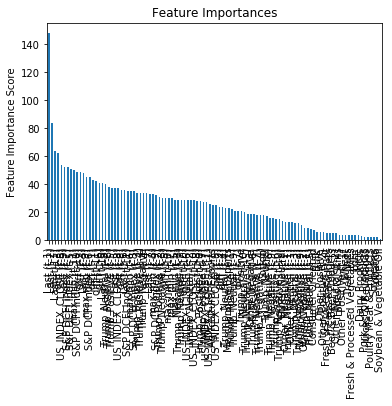

<Figure size 1440x1440 with 0 Axes>


best params 
 {'subsample': 0.7, 'reg_alpha': 1, 'n_estimators': 155, 'min_child_weight': 4, 'max_depth': 16, 'learning_rate': 0.05, 'gamma': 0.4, 'colsample_bytree': 0.7}



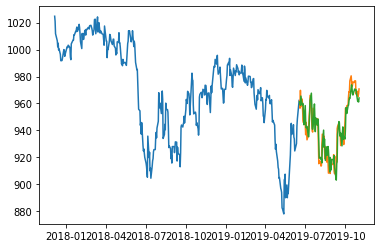

In [257]:
perf_table = pd.DataFrame(columns=['PriceLag','TweetLag','TrumpLag','Train R-Squared','Test R-Squared', 'Test RMSE', 'Test MAE'])
for lp in range(8,13):
    for tr in range(6,12):
        for tw in range(1,4):
            lagged_data = add_lags(data, lag_prices = lp, lag_trump = tr, lag_tweets = tw)
            print()
            print('lagging prices by :',lp)
            print('lagging trump tweets by :',tr)
            print('lagging tweets by :',tw)
            test_rsq, test_rmse, test_mae, train_rsq, xg_random, test_x20, \
                            feat_imp = predict_soybean_futures(lagged_data)
            result = pd.DataFrame([[lp,tw,tr,train_rsq,test_rsq,test_rmse, test_mae]],
                                              columns=['PriceLag','TweetLag','TrumpLag',
                                                       'Train R-Squared','Test R-Squared', 
                                                       'Test RMSE', 'Test MAE'])
            perf_table = perf_table.append(result)

In [259]:
perf_table.sort_values(by='Test MAE',ascending=True)

PriceLag TweetLag TrumpLag  Train R-Squared  Test R-Squared  Test RMSE  \
0         8        1       11              1.0            0.85       8.07   
0         9        1        9              1.0            0.86       7.88   
0        12        1        9              1.0            0.86       7.85   
0         9        2        8              1.0            0.85       7.96   
0         8        3        9              1.0            0.85       7.97   
..      ...      ...      ...              ...             ...        ...   
0         8        2        8              1.0            0.79       9.48   
0        12        3       10              1.0            0.78       9.66   
0        10        1       11              1.0            0.78       9.81   
0        10        3        7              1.0            0.76      10.18   
0        11        3       10              1.0            0.69      11.51   

    Test MAE  
0       6.27  
0       6.29  
0       6.32  
0       6.34  
0       6.40  
..       ...  
0       7.94  
0       7.95  
0       8.35  
0       8.47  
0       9.43  

[90 rows x 7 columns]

In [263]:
dates = pd.read_csv('Final_Data/full_piyush.csv',index_col='Date', parse_dates=True)
dates.head()

Year  Month  Week  Day  Dayofweek  Dayofyear  Is_month_end  \
Date                                                                     
2017-11-15  2017     11    46   15          2        319         False   
2017-11-16  2017     11    46   16          3        320         False   
2017-11-17  2017     11    46   17          4        321         False   
2017-11-20  2017     11    47   20          0        324         False   
2017-11-21  2017     11    47   21          1        325         False   

            Is_month_start  Is_quarter_end  Is_quarter_start  Is_year_end  \
Date                                                                        
2017-11-15           False           False             False        False   
2017-11-16           False           False             False        False   
2017-11-17           False           False             False        False   
2017-11-20           False           False             False        False   
2017-11-21           False           False             False        False   

            Is_year_start  
Date                       
2017-11-15          False  
2017-11-16          False  
2017-11-17          False  
2017-11-20          False  
2017-11-21          False

In [264]:
data = pd.merge(data,
               dates,
               how='left',
                left_index=True,
                right_index=True)
data.head(5)

Last  Other_Positive  Other_Negative  Other_Neutral  \
Date                                                                 
2017-11-15  1000.25             NaN             NaN            NaN   
2017-11-16   998.50             NaN             NaN            NaN   
2017-11-17  1011.75             NaN             NaN            NaN   
2017-11-20  1013.75             NaN             NaN            NaN   
2017-11-21  1013.50             NaN             NaN            NaN   

            Agricultural Exports  Beef & Beef Products    Bulk  \
Date                                                             
2017-11-15               -2.7962                1.4866 -6.8833   
2017-11-16               -2.7962                1.4866 -6.8833   
2017-11-17               -2.7962                1.4866 -6.8833   
2017-11-20               -2.7962                1.4866 -6.8833   
2017-11-21               -2.7962                1.4866 -6.8833   

            Consumer Oriented    Corn  Cotton  ...  Week  Day  Dayofweek  \
Date                                           ...                         
2017-11-15             1.0466 -1.0151 -7.4404  ...    46   15          2   
2017-11-16             1.0466 -1.0151 -7.4404  ...    46   16          3   
2017-11-17             1.0466 -1.0151 -7.4404  ...    46   17          4   
2017-11-20             1.0466 -1.0151 -7.4404  ...    47   20          0   
2017-11-21             1.0466 -1.0151 -7.4404  ...    47   21          1   

            Dayofyear  Is_month_end  Is_month_start  Is_quarter_end  \
Date                                                                  
2017-11-15        319         False           False           False   
2017-11-16        320         False           False           False   
2017-11-17        321         False           False           False   
2017-11-20        324         False           False           False   
2017-11-21        325         False           False           False   

            Is_quarter_start  Is_year_end  Is_year_start  
Date                                                      
2017-11-15             False        False          False  
2017-11-16             False        False          False  
2017-11-17             False        False          False  
2017-11-20             False        False          False  
2017-11-21             False        False          False  

[5 rows x 48 columns]


lagging prices by : 12
lagging trump tweets by : 11
lagging tweets by : 3
columns being used:
Index(['Other_Positive', 'Other_Negative', 'Other_Neutral',
       'Agricultural Exports', 'Beef & Beef Products', 'Bulk',
       'Consumer Oriented', 'Corn', 'Cotton', 'Dairy Products',
       'Feeds & Fodders', 'Fresh & Processed Fruit',
       'Fresh & Processed Vegetables', 'Hides & Skins', 'Intermediates',
       'Juices & Beverages', 'Merchandise Exports', 'Pork & Pork Products',
       'Poultry Meat & Products', 'Prepared Food', 'Rice',
       'Soybean & Vegetable Oil', 'Soybeans', 'Soymeal', 'Tobacco',
       'Tree Nuts', 'Wheat', 'Wine & Beer', 'Trump_Positive', 'Trump_Negative',
       'Trump_Neutral', 'Last (t-1)', 'diff (t-1)', 'Last (t-2)', 'diff (t-2)',
       'Last (t-3)', 'diff (t-3)', 'Last (t-4)', 'diff (t-4)', 'Last (t-5)',
       'diff (t-5)', 'Last (t-6)', 'diff (t-6)', 'Last (t-7)', 'diff (t-7)',
       'S&P DCFI Index (t-5)', 'max-min (t-5)', 'US_INDEX_CLOSE (t-5)',
   

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    6.6s finished


[21:13:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training R-squared:  0.99
Training Explained Variation:  1.0
Training RMSE:  2.67
Training MAE:  1.94  

Test R-squared:  0.97
Test Explained Variation:  0.98
Test RMSE:  3.29
Test MAE:  2.45


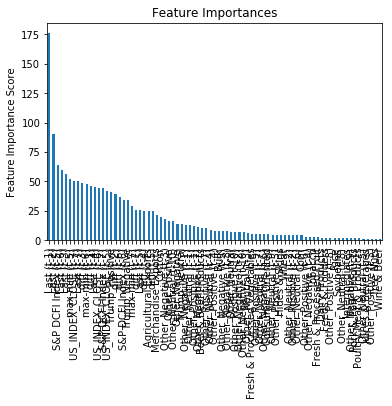

<Figure size 1440x1440 with 0 Axes>


best params 
 {'subsample': 0.6, 'reg_alpha': 0.1, 'n_estimators': 135, 'min_child_weight': 4, 'max_depth': 16, 'learning_rate': 0.05, 'gamma': 0.4, 'colsample_bytree': 0.8}



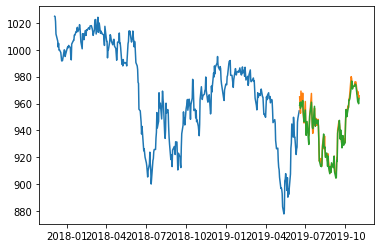

In [315]:
lagged_data = add_lags(data, lag_prices = 8, lag_trump = 1, lag_tweets = 11)
print()
print('lagging prices by :',lp)
print('lagging trump tweets by :',tr)
print('lagging tweets by :',tw)
test_rsq, test_rmse, test_mae, train_rsq, xg_random, test_x20, \
                feat_imp,test_result = predict_soybean_futures(lagged_data)

In [266]:
feat_imp

Last (t-1)             106
Day                     99
diff (t-2)              56
Last (t-2)              55
diff (t-3)              53
                      ... 
Other_Neutral (t-2)      1
Tree Nuts                1
Tobacco                  1
Dairy Products           1
Rice                     1
Length: 84, dtype: int64

In [293]:
test_x20.to_csv('test_july.csv')

In [294]:
test_results

Last     predict       diff
Date                                     
2019-06-18  957.00  952.575317   4.424683
2019-06-19  951.25  953.359619  -2.109619
2019-06-20  964.50  948.340820  16.159180
2019-06-21  952.00  959.940979  -7.940979
2019-06-24  957.25  953.841797   3.408203
...            ...         ...        ...
2019-10-28  958.75  957.534729   1.215271
2019-10-29  957.75  950.750061   6.999939
2019-10-30  955.00  953.371765   1.628235
2019-10-31  957.00  952.359375   4.640625
2019-11-01  960.75  954.166199   6.583801

[97 rows x 3 columns]

In [320]:
data = prepare_data("Final_Data/Soybean_Futures_July_2020.csv")
print(data.columns)
data.sample(5)
data.shape

post tweet
                   Date    Open    High     Low    Last  Change  Volume  \
Date                                                                     
2019-10-28  10/28/2019  967.00  973.00  967.00  969.00    2.00   14491   
2019-10-29  10/29/2019  969.00  973.00  965.50  968.25   -0.75   17773   
2019-10-30  10/30/2019  968.00  971.25  964.50  965.25   -3.00   16641   
2019-10-31  10/31/2019  964.00  968.75  960.25  967.25    2.00   13453   
2019-11-01   11/1/2019  965.75  971.75  965.50  970.75    3.50   11136   

            Open Int  Other_Positive  Other_Negative  Other_Neutral  
Date                                                                 
2019-10-28     74882           0.489           0.039          2.472  
2019-10-29     75906           1.256           0.206          8.538  
2019-10-30     76017           0.595           0.069          3.336  
2019-10-31     78269           0.994           0.074         11.931  
2019-11-01         0             NaN             

(495, 36)

In [321]:
lagged_data = add_lags(data, lag_prices = 8, lag_trump = 1, lag_tweets = 11)
lagged_data = lagged_data.drop(columns=['Tree Nuts', 'Fresh & Processed Vegetables', 'Juices & Beverages', 'Hides & Skins', 'Dairy Products', 'Rice', 'Feeds & Fodders', 'Intermediates', 'Fresh & Processed Fruit', 'Soybeans', 'Tobacco', 'Soymeal', 'Poultry Meat & Products', 'Pork & Pork Products', 'Soybean & Vegetable Oil'])

columns being used:
Index(['Other_Positive', 'Other_Negative', 'Other_Neutral',
       'Agricultural Exports', 'Beef & Beef Products', 'Bulk',
       'Consumer Oriented', 'Corn', 'Cotton', 'Dairy Products',
       'Feeds & Fodders', 'Fresh & Processed Fruit',
       'Fresh & Processed Vegetables', 'Hides & Skins', 'Intermediates',
       'Juices & Beverages', 'Merchandise Exports', 'Pork & Pork Products',
       'Poultry Meat & Products', 'Prepared Food', 'Rice',
       'Soybean & Vegetable Oil', 'Soybeans', 'Soymeal', 'Tobacco',
       'Tree Nuts', 'Wheat', 'Wine & Beer', 'Trump_Positive', 'Trump_Negative',
       'Trump_Neutral', 'Last (t-1)', 'diff (t-1)', 'Last (t-2)', 'diff (t-2)',
       'Last (t-3)', 'diff (t-3)', 'Last (t-4)', 'diff (t-4)', 'Last (t-5)',
       'diff (t-5)', 'Last (t-6)', 'diff (t-6)', 'Last (t-7)', 'diff (t-7)',
       'S&P DCFI Index (t-5)', 'max-min (t-5)', 'US_INDEX_CLOSE (t-5)',
       'S&P DCFI Index (t-6)', 'max-min (t-6)', 'US_INDEX_CLOSE (t-6)',
      

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    7.0s finished


[21:16:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training R-squared:  1.0
Training Explained Variation:  1.0
Training RMSE:  2.3
Training MAE:  1.55  

Test R-squared:  0.8
Test Explained Variation:  0.8
Test RMSE:  9.24
Test MAE:  7.48


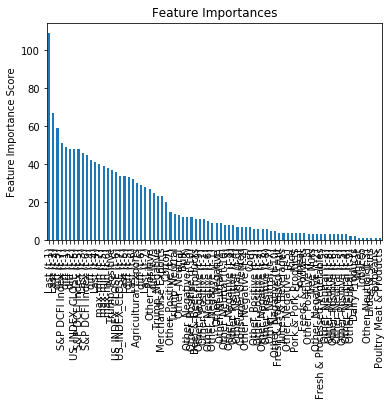

<Figure size 1440x1440 with 0 Axes>


best params 
 {'subsample': 0.6, 'reg_alpha': 1, 'n_estimators': 75, 'min_child_weight': 2, 'max_depth': 12, 'learning_rate': 0.1, 'gamma': 0.3, 'colsample_bytree': 0.9}



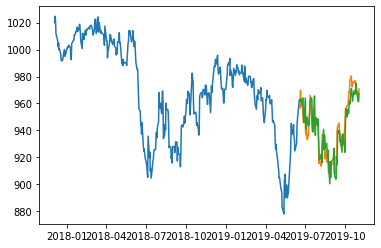

In [322]:
test_rsq, test_rmse, test_mae, train_rsq, xg_random, test_x20, \
                feat_imp,test_result = predict_soybean_futures(lagged_data)

In [332]:
data = prepare_data("Final_Data/Soybean_Futures_July_2020.csv")
print(data.columns)
data.sample(5)
data.shape

post tweet
                   Date    Open    High     Low    Last  Change  Volume  \
Date                                                                     
2019-10-28  10/28/2019  967.00  973.00  967.00  969.00    2.00   14491   
2019-10-29  10/29/2019  969.00  973.00  965.50  968.25   -0.75   17773   
2019-10-30  10/30/2019  968.00  971.25  964.50  965.25   -3.00   16641   
2019-10-31  10/31/2019  964.00  968.75  960.25  967.25    2.00   13453   
2019-11-01   11/1/2019  965.75  971.75  965.50  970.75    3.50   11136   

            Open Int  Other_Positive  Other_Negative  Other_Neutral  
Date                                                                 
2019-10-28     74882           0.489           0.039          2.472  
2019-10-29     75906           1.256           0.206          8.538  
2019-10-30     76017           0.595           0.069          3.336  
2019-10-31     78269           0.994           0.074         11.931  
2019-11-01         0             NaN             

(495, 37)

In [333]:
lagged_data = add_lags(data, lag_prices = 8, lag_trump = 1, lag_tweets = 11)
lagged_data = lagged_data.drop(columns=['Tree Nuts', 'Fresh & Processed Vegetables', 'Juices & Beverages', 'Hides & Skins', 'Dairy Products', 'Rice', 'Feeds & Fodders', 'Intermediates', 'Fresh & Processed Fruit', 'Soybeans', 'Tobacco', 'Soymeal', 'Poultry Meat & Products', 'Pork & Pork Products', 'Soybean & Vegetable Oil'])

columns being used:
Index(['Other_Positive', 'Other_Negative', 'Other_Neutral',
       'Agricultural Exports', 'Beef & Beef Products', 'Bulk',
       'Consumer Oriented', 'Corn', 'Cotton', 'Merchandise Exports',
       'Prepared Food', 'Wheat', 'Wine & Beer', 'Trump_Positive',
       'Trump_Negative', 'Trump_Neutral', 'Last (t-1)', 'diff (t-1)',
       'Last (t-2)', 'diff (t-2)', 'Last (t-3)', 'diff (t-3)', 'Last (t-4)',
       'diff (t-4)', 'Last (t-5)', 'diff (t-5)', 'Last (t-6)', 'diff (t-6)',
       'Last (t-7)', 'diff (t-7)', 'S&P DCFI Index (t-5)', 'max-min (t-5)',
       'US_INDEX_CLOSE (t-5)', 'S&P DCFI Index (t-6)', 'max-min (t-6)',
       'US_INDEX_CLOSE (t-6)', 'S&P DCFI Index (t-7)', 'max-min (t-7)',
       'US_INDEX_CLOSE (t-7)', 'Other_Positive (t-1)', 'Other_Negative (t-1)',
       'Other_Neutral (t-1)', 'Other_Positive (t-2)', 'Other_Negative (t-2)',
       'Other_Neutral (t-2)', 'Other_Positive (t-3)', 'Other_Negative (t-3)',
       'Other_Neutral (t-3)', 'Other_Positi

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   10.1s finished


[21:24:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training R-squared:  1.0
Training Explained Variation:  1.0
Training RMSE:  1.78
Training MAE:  1.24  

Test R-squared:  0.97
Test Explained Variation:  0.98
Test RMSE:  3.29
Test MAE:  2.58


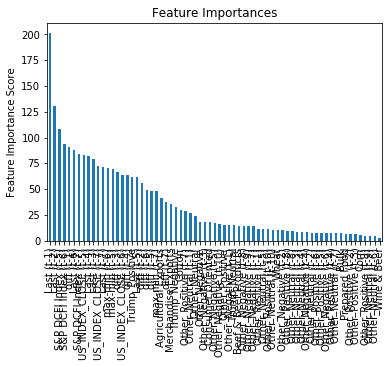

<Figure size 1440x1440 with 0 Axes>


best params 
 {'subsample': 0.7, 'reg_alpha': 1, 'n_estimators': 155, 'min_child_weight': 4, 'max_depth': 16, 'learning_rate': 0.05, 'gamma': 0.4, 'colsample_bytree': 0.7}



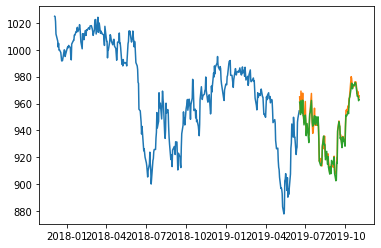

In [334]:
test_rsq, test_rmse, test_mae, train_rsq, xg_random_open, test_x20_open, \
                feat_imp_open,test_result_open = predict_soybean_futures(lagged_data)

In [329]:
for_feed = pd.read_csv('test_july_predict5day.csv',index_col='Date', parse_dates=True)
nov4 = for_feed[for_feed.index == '11/4/2019']
nov4

Other_Positive  Other_Negative  Other_Neutral  \
Date                                                        
2019-11-04             NaN             NaN            NaN   

            Agricultural Exports  Beef & Beef Products    Bulk  \
Date                                                             
2019-11-04                -12.28              -11.5268 -18.114   

            Consumer Oriented     Corn  Cotton  Merchandise Exports  ...  \
Date                                                                 ...   
2019-11-04            -5.4908 -15.9724 -9.6885               1.5413  ...   

            Trump_Neutral (t-5)  Trump_Positive (t-6)  Trump_Negative (t-6)  \
Date                                                                          
2019-11-04                  NaN                   NaN                   NaN   

            Trump_Neutral (t-6)  Trump_Positive (t-7)  Trump_Negative (t-7)  \
Date                                                                          
2019-11-04                  NaN                   NaN                   NaN   

            Trump_Neutral (t-7)  Trump_Positive (t-8)  Trump_Negative (t-8)  \
Date                                                                          
2019-11-04                  NaN                   NaN                   NaN   

            Trump_Neutral (t-8)  
Date                             
2019-11-04                  NaN  

[1 rows x 81 columns]

In [353]:
data = prepare_data("Final_Data/Soybean_Futures_July_2020.csv")
print(data.columns)
data.sample(5)
data.shape

post tweet
                   Date    Open    High     Low    Last  Change  Volume  \
Date                                                                     
2019-10-28  10/28/2019  967.00  973.00  967.00  969.00    2.00   14491   
2019-10-29  10/29/2019  969.00  973.00  965.50  968.25   -0.75   17773   
2019-10-30  10/30/2019  968.00  971.25  964.50  965.25   -3.00   16641   
2019-10-31  10/31/2019  964.00  968.75  960.25  967.25    2.00   13453   
2019-11-01   11/1/2019  965.75  971.75  965.50  970.75    3.50   11136   

            Open Int  Other_Positive  Other_Negative  Other_Neutral  
Date                                                                 
2019-10-28     74882           0.489           0.039          2.472  
2019-10-29     75906           1.256           0.206          8.538  
2019-10-30     76017           0.595           0.069          3.336  
2019-10-31     78269           0.994           0.074         11.931  
2019-11-01         0             NaN             

(495, 36)

In [354]:
lagged_data = add_lags(data, lag_prices = 8, lag_trump = 11, lag_tweets = 1)
lagged_data = lagged_data.drop(columns=['Tree Nuts', 'Fresh & Processed Vegetables', 'Juices & Beverages', 'Hides & Skins', 'Dairy Products', 'Rice', 'Feeds & Fodders', 'Intermediates', 'Fresh & Processed Fruit', 'Soybeans', 'Tobacco', 'Soymeal', 'Poultry Meat & Products', 'Pork & Pork Products', 'Soybean & Vegetable Oil'])

columns being used:
Index(['Other_Positive', 'Other_Negative', 'Other_Neutral',
       'Agricultural Exports', 'Beef & Beef Products', 'Bulk',
       'Consumer Oriented', 'Corn', 'Cotton', 'Merchandise Exports',
       'Prepared Food', 'Wheat', 'Wine & Beer', 'Trump_Positive',
       'Trump_Negative', 'Trump_Neutral', 'Last (t-1)', 'diff (t-1)',
       'Last (t-2)', 'diff (t-2)', 'Last (t-3)', 'diff (t-3)', 'Last (t-4)',
       'diff (t-4)', 'Last (t-5)', 'diff (t-5)', 'Last (t-6)', 'diff (t-6)',
       'Last (t-7)', 'diff (t-7)', 'S&P DCFI Index (t-5)', 'max-min (t-5)',
       'US_INDEX_CLOSE (t-5)', 'S&P DCFI Index (t-6)', 'max-min (t-6)',
       'US_INDEX_CLOSE (t-6)', 'S&P DCFI Index (t-7)', 'max-min (t-7)',
       'US_INDEX_CLOSE (t-7)', 'Trump_Positive (t-1)', 'Trump_Negative (t-1)',
       'Trump_Neutral (t-1)', 'Trump_Positive (t-2)', 'Trump_Negative (t-2)',
       'Trump_Neutral (t-2)', 'Trump_Positive (t-3)', 'Trump_Negative (t-3)',
       'Trump_Neutral (t-3)', 'Trump_Positi

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    6.6s finished


[21:31:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training R-squared:  1.0
Training Explained Variation:  1.0
Training RMSE:  1.61
Training MAE:  1.17  

Test R-squared:  0.81
Test Explained Variation:  0.81
Test RMSE:  9.04
Test MAE:  7.24


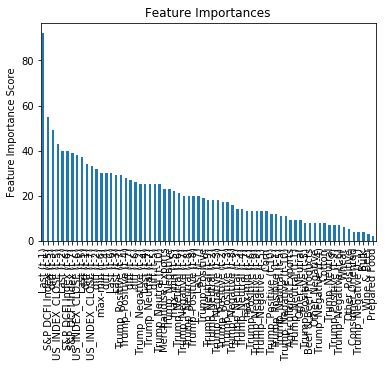

<Figure size 1440x1440 with 0 Axes>


best params 
 {'subsample': 0.9, 'reg_alpha': 0.01, 'n_estimators': 185, 'min_child_weight': 4, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.3, 'colsample_bytree': 0.6}



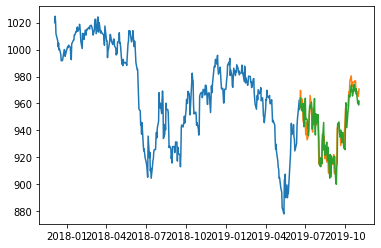

In [356]:
test_rsq, test_rmse, test_mae, train_rsq, xg_random, test_x20, \
                feat_imp_open,test_result = predict_soybean_futures(lagged_data)

In [361]:
data = prepare_data("Final_Data/Soybean_Futures_July_2020.csv")
print(data.columns)
data.sample(5)
data.shape

post tweet
                   Date    Open    High     Low    Last  Change  Volume  \
Date                                                                     
2019-10-28  10/28/2019  967.00  973.00  967.00  969.00    2.00   14491   
2019-10-29  10/29/2019  969.00  973.00  965.50  968.25   -0.75   17773   
2019-10-30  10/30/2019  968.00  971.25  964.50  965.25   -3.00   16641   
2019-10-31  10/31/2019  964.00  968.75  960.25  967.25    2.00   13453   
2019-11-01   11/1/2019  965.75  971.75  965.50  970.75    3.50   11136   

            Open Int  Other_Positive  Other_Negative  Other_Neutral  
Date                                                                 
2019-10-28     74882           0.489           0.039          2.472  
2019-10-29     75906           1.256           0.206          8.538  
2019-10-30     76017           0.595           0.069          3.336  
2019-10-31     78269           0.994           0.074         11.931  
2019-11-01         0             NaN             

(495, 37)

In [362]:
lagged_data = add_lags(data, lag_prices = 8, lag_trump = 11, lag_tweets = 1)
lagged_data = lagged_data.drop(columns=['Tree Nuts', 'Fresh & Processed Vegetables', 'Juices & Beverages', 'Hides & Skins', 'Dairy Products', 'Rice', 'Feeds & Fodders', 'Intermediates', 'Fresh & Processed Fruit', 'Soybeans', 'Tobacco', 'Soymeal', 'Poultry Meat & Products', 'Pork & Pork Products', 'Soybean & Vegetable Oil'])

columns being used:
Index(['Other_Positive', 'Other_Negative', 'Other_Neutral',
       'Agricultural Exports', 'Beef & Beef Products', 'Bulk',
       'Consumer Oriented', 'Corn', 'Cotton', 'Merchandise Exports',
       'Prepared Food', 'Wheat', 'Wine & Beer', 'Trump_Positive',
       'Trump_Negative', 'Trump_Neutral', 'Last (t-1)', 'diff (t-1)',
       'Last (t-2)', 'diff (t-2)', 'Last (t-3)', 'diff (t-3)', 'Last (t-4)',
       'diff (t-4)', 'Last (t-5)', 'diff (t-5)', 'Last (t-6)', 'diff (t-6)',
       'Last (t-7)', 'diff (t-7)', 'S&P DCFI Index (t-5)', 'max-min (t-5)',
       'US_INDEX_CLOSE (t-5)', 'S&P DCFI Index (t-6)', 'max-min (t-6)',
       'US_INDEX_CLOSE (t-6)', 'S&P DCFI Index (t-7)', 'max-min (t-7)',
       'US_INDEX_CLOSE (t-7)', 'Trump_Positive (t-1)', 'Trump_Negative (t-1)',
       'Trump_Neutral (t-1)', 'Trump_Positive (t-2)', 'Trump_Negative (t-2)',
       'Trump_Neutral (t-2)', 'Trump_Positive (t-3)', 'Trump_Negative (t-3)',
       'Trump_Neutral (t-3)', 'Trump_Positi

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    6.6s finished


[21:36:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training R-squared:  0.99
Training Explained Variation:  1.0
Training RMSE:  2.6
Training MAE:  1.9  

Test R-squared:  0.96
Test Explained Variation:  0.97
Test RMSE:  3.85
Test MAE:  3.03


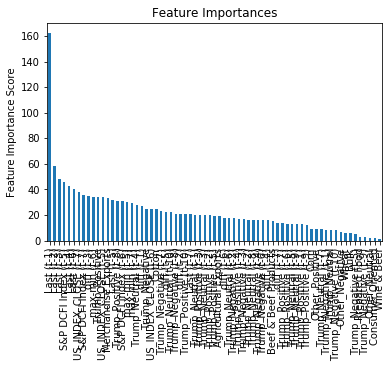

<Figure size 1440x1440 with 0 Axes>


best params 
 {'subsample': 0.6, 'reg_alpha': 0.1, 'n_estimators': 135, 'min_child_weight': 4, 'max_depth': 16, 'learning_rate': 0.05, 'gamma': 0.4, 'colsample_bytree': 0.8}



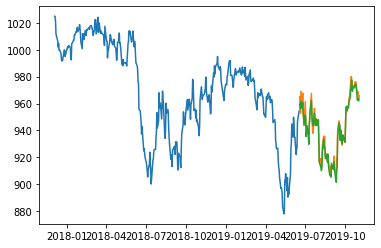

In [363]:
test_rsq, test_rmse, test_mae, train_rsq, xg_random_open, test_x20_open, \
                feat_imp_opentruw,test_result_open = predict_soybean_futures(lagged_data)

In [364]:
for_feed = pd.read_csv('test_july_predict5day.csv',index_col='Date', parse_dates=True)
nov4 = for_feed[for_feed.index == '11/4/2019']
nov4

Other_Positive  Other_Negative  Other_Neutral  \
Date                                                        
2019-11-04             NaN             NaN            NaN   

            Agricultural Exports  Beef & Beef Products    Bulk  \
Date                                                             
2019-11-04                -12.28              -11.5268 -18.114   

            Consumer Oriented     Corn  Cotton  Merchandise Exports  ...  \
Date                                                                 ...   
2019-11-04            -5.4908 -15.9724 -9.6885               1.5413  ...   

            Trump_Neutral (t-7)  Trump_Positive (t-8)  Trump_Negative (t-8)  \
Date                                                                          
2019-11-04                  NaN                   NaN                   NaN   

            Trump_Neutral (t-8)  Trump_Positive (t-9)  Trump_Negative (t-9)  \
Date                                                                          
2019-11-04                  NaN                   NaN                   NaN   

            Trump_Neutral (t-9)  Trump_Positive (t-10)  Trump_Negative (t-10)  \
Date                                                                            
2019-11-04                  NaN                    NaN                    NaN   

            Trump_Neutral (t-10)  
Date                              
2019-11-04                   NaN  

[1 rows x 69 columns]

In [365]:
xg_random.predict(nov4)

array([957.1601], dtype=float32)

In [366]:
xg_random_open.predict(nov4)

array([960.52826], dtype=float32)

In [367]:
for_feed = pd.read_csv('test_july_predict5day.csv',index_col='Date', parse_dates=True)
nov5 = for_feed[for_feed.index == '11/5/2019']
nov5

Other_Positive  Other_Negative  Other_Neutral  \
Date                                                        
2019-11-05             NaN             NaN            NaN   

            Agricultural Exports  Beef & Beef Products    Bulk  \
Date                                                             
2019-11-05                -12.28              -11.5268 -18.114   

            Consumer Oriented     Corn  Cotton  Merchandise Exports  ...  \
Date                                                                 ...   
2019-11-05            -5.4908 -15.9724 -9.6885               1.5413  ...   

            Trump_Neutral (t-7)  Trump_Positive (t-8)  Trump_Negative (t-8)  \
Date                                                                          
2019-11-05                  NaN                   NaN                   NaN   

            Trump_Neutral (t-8)  Trump_Positive (t-9)  Trump_Negative (t-9)  \
Date                                                                          
2019-11-05                  NaN                   NaN                   NaN   

            Trump_Neutral (t-9)  Trump_Positive (t-10)  Trump_Negative (t-10)  \
Date                                                                            
2019-11-05                  NaN                    NaN                    NaN   

            Trump_Neutral (t-10)  
Date                              
2019-11-05                   NaN  

[1 rows x 69 columns]

In [368]:
xg_random.predict(nov5)

array([954.8289], dtype=float32)

In [369]:
xg_random_open.predict(nov5)

array([956.9628], dtype=float32)

In [373]:
for_feed = pd.read_csv('test_july_predict5day.csv',index_col='Date', parse_dates=True)
nov6 = for_feed[for_feed.index == '11/6/2019']
nov6

Other_Positive  Other_Negative  Other_Neutral  \
Date                                                        
2019-11-06             NaN             NaN            NaN   

            Agricultural Exports  Beef & Beef Products    Bulk  \
Date                                                             
2019-11-06                -12.28              -11.5268 -18.114   

            Consumer Oriented     Corn  Cotton  Merchandise Exports  ...  \
Date                                                                 ...   
2019-11-06            -5.4908 -15.9724 -9.6885               1.5413  ...   

            Trump_Neutral (t-7)  Trump_Positive (t-8)  Trump_Negative (t-8)  \
Date                                                                          
2019-11-06                  NaN                   NaN                   NaN   

            Trump_Neutral (t-8)  Trump_Positive (t-9)  Trump_Negative (t-9)  \
Date                                                                          
2019-11-06                  NaN                   NaN                   NaN   

            Trump_Neutral (t-9)  Trump_Positive (t-10)  Trump_Negative (t-10)  \
Date                                                                            
2019-11-06                  NaN                    NaN                    NaN   

            Trump_Neutral (t-10)  
Date                              
2019-11-06                   NaN  

[1 rows x 69 columns]

In [374]:
xg_random.predict(nov6)

array([944.3708], dtype=float32)

In [375]:
xg_random_open.predict(nov6)

array([953.6244], dtype=float32)

In [376]:
for_feed = pd.read_csv('test_july_predict5day.csv',index_col='Date', parse_dates=True)
nov7 = for_feed[for_feed.index == '11/7/2019']
nov7

Other_Positive  Other_Negative  Other_Neutral  \
Date                                                        
2019-11-07             NaN             NaN            NaN   

            Agricultural Exports  Beef & Beef Products    Bulk  \
Date                                                             
2019-11-07                -12.28              -11.5268 -18.114   

            Consumer Oriented     Corn  Cotton  Merchandise Exports  ...  \
Date                                                                 ...   
2019-11-07            -5.4908 -15.9724 -9.6885               1.5413  ...   

            Trump_Neutral (t-7)  Trump_Positive (t-8)  Trump_Negative (t-8)  \
Date                                                                          
2019-11-07                  NaN                   NaN                   NaN   

            Trump_Neutral (t-8)  Trump_Positive (t-9)  Trump_Negative (t-9)  \
Date                                                                          
2019-11-07                  NaN                   NaN                   NaN   

            Trump_Neutral (t-9)  Trump_Positive (t-10)  Trump_Negative (t-10)  \
Date                                                                            
2019-11-07                  NaN                    NaN                    NaN   

            Trump_Neutral (t-10)  
Date                              
2019-11-07                   NaN  

[1 rows x 69 columns]

In [377]:
xg_random.predict(nov7)

array([940.7032], dtype=float32)

In [378]:
xg_random_open.predict(nov7)

array([947.7613], dtype=float32)

In [379]:
for_feed = pd.read_csv('test_july_predict5day.csv',index_col='Date', parse_dates=True)
nov8 = for_feed[for_feed.index == '11/8/2019']
nov8

Other_Positive  Other_Negative  Other_Neutral  \
Date                                                        
2019-11-08             NaN             NaN            NaN   

            Agricultural Exports  Beef & Beef Products    Bulk  \
Date                                                             
2019-11-08                -12.28              -11.5268 -18.114   

            Consumer Oriented     Corn  Cotton  Merchandise Exports  ...  \
Date                                                                 ...   
2019-11-08            -5.4908 -15.9724 -9.6885               1.5413  ...   

            Trump_Neutral (t-7)  Trump_Positive (t-8)  Trump_Negative (t-8)  \
Date                                                                          
2019-11-08                  NaN                   NaN                   NaN   

            Trump_Neutral (t-8)  Trump_Positive (t-9)  Trump_Negative (t-9)  \
Date                                                                          
2019-11-08                  NaN                   NaN                   NaN   

            Trump_Neutral (t-9)  Trump_Positive (t-10)  Trump_Negative (t-10)  \
Date                                                                            
2019-11-08                  NaN                    NaN                    NaN   

            Trump_Neutral (t-10)  
Date                              
2019-11-08                   NaN  

[1 rows x 69 columns]

In [380]:
xg_random.predict(nov8)

array([942.2585], dtype=float32)

In [381]:
xg_random_open.predict(nov8)

array([943.5604], dtype=float32)

In [ ]:
for_feed = pd.read_csv('test_july_predict5day.csv',index_col='Date', parse_dates=True)
nov8 = for_feed[for_feed.index == '11/8/2019']
nov8
xg_random.predict(nov8)
xg_random_open.predict(nov8)